In [1]:
!pip install xgboost shap rpy2 linearmodels --quiet


In [2]:
# Standard library imports
import os
import re

# Data analysis
import pandas as pd
import numpy as np

# Machine learning
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    train_test_split,
    TimeSeriesSplit,
    GroupKFold,
    cross_val_score,
     RandomizedSearchCV
)
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import partial_dependence, PartialDependenceDisplay

# Statistical modeling 
import statsmodels.api as sm
from linearmodels.panel import PanelOLS, RandomEffects, compare
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF

# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns

# EXplainability and XGBOOST model as well as R Library
import xgboost as xgb
import shap
import rpy2
from xgboost import XGBRegressor




## Load Data

In [4]:
# Define file paths for raw datasets
base_root = '../data/raw'

file_paths = {
    'capital': os.path.join(base_root, 'CapitalStockData.csv'),
    'energy': os.path.join(base_root, 'energy_use.csv'),
    'labor_force': os.path.join(base_root, 'labor_force.csv'),
    'patents': os.path.join(base_root, 'patents_res_nonres.csv'),
    'rnd': os.path.join(base_root, 'R&D.csv'),
    'unemployment': os.path.join(base_root, 'unemployed_ilo_estimate.csv'),
    'population': os.path.join(base_root, 'population_Data.csv'),
    'human_capital': os.path.join(base_root, 'Human_Capital_Data.csv'),
    'penn_table': os.path.join(base_root, 'penn_table.csv'),
}

# Validate that all files exist
for name, path in file_paths.items():
    if not os.path.exists(path):
        raise FileNotFoundError(f"Data file not found: {path}")

In [5]:
# Load datasets into a dictionary of DataFrames
dfs = {}
for name, path in file_paths.items():
    try:
        dfs[name] = pd.read_csv(path)
        print(f"Loaded {name}_df: {dfs[name].shape[0]} rows, {dfs[name].shape[1]} columns")
    except Exception as e:
        raise ValueError(f"Failed to load {path}: {str(e)}")

# # Display the first few rows of each DataFrame for inspection
# for name, df in dfs.items():
#     print(f"\n{name}_df (first 5 rows):")
#     display(df.head())

Loaded capital_df: 11640 rows, 18 columns
Loaded energy_df: 266 rows, 68 columns
Loaded labor_force_df: 266 rows, 68 columns
Loaded patents_df: 532 rows, 68 columns
Loaded rnd_df: 266 rows, 68 columns
Loaded unemployment_df: 266 rows, 68 columns
Loaded population_df: 6123 rows, 95 columns
Loaded human_capital_df: 803 rows, 68 columns
Loaded penn_table_df: 12810 rows, 52 columns


In [6]:
# set global float display
pd.options.display.float_format = '{:.2f}'.format

## Wrangle Data

In [8]:
# Inspect the structure of each DataFrame
for name, df in dfs.items():
    if df.empty:
        print(f"\n{name}: Empty DataFrame")
        continue
    print(f"\n{name}:")
    if 'Series Name' in df.columns:
        # Long format: List unique series names
        unique_series = df['Series Name'].dropna().unique().tolist()
        print(f"  Series Names: {unique_series}")
    else:
        # Wide format: List columns, excluding metadata
        skip_cols = {'countrycode', 'ifs', 'currency_unit', 'unnamed'}
        data_columns = [
            col for col in df.columns
            if col.lower() not in skip_cols and not col.lower().startswith('unnamed')
        ]
        print(f"  Columns: {data_columns}")


capital:
  Columns: ['ifscode', 'countryname', 'year', 'igov_rppp', 'kgov_rppp', 'ipriv_rppp', 'kpriv_rppp', 'ippp_rppp', 'kppp_rppp', 'GDP_rppp', 'igov_n', 'kgov_n', 'ipriv_n', 'kpriv_n', 'kppp_n', 'GDP_n', 'income']

energy:
  Series Names: ['Energy use (kg of oil equivalent per capita)']

labor_force:
  Series Names: ['Labor force, total']

patents:
  Series Names: ['Patent applications, nonresidents', 'Patent applications, residents']

rnd:
  Series Names: ['Researchers in R&D (per million people)']

unemployment:
  Series Names: ['Unemployment, total (% of total labor force) (modeled ILO estimate)']

population:
  Series Names: ['Age dependency ratio (% of working-age population)', 'Age dependency ratio, old', 'Age dependency ratio, young', 'Life expectancy at birth, total (years)', 'Life expectancy at birth, male (years)', 'Life expectancy at birth, female (years)', 'Population ages 15-64 (% of total population)', 'Population ages 15-64, female', 'Population ages 15-64, male', '

In [9]:
def process_time_series(
    df: pd.DataFrame,
    id_vars_map: dict,
    year_col: str = 'year',
    cutoff_year: int = 2019,
    drop_id_na_all: bool = True,
    value_name: str = 'value'
):
    # 0a) Rename ID cols + strip "[YR####]" suffixes
    df2 = df.rename(columns=id_vars_map).copy()
    yr_pat = re.compile(r'^(\d{4}) \[YR\d{4}\]$')
    strip  = {c: yr_pat.match(c).group(1)
              for c in df2.columns if yr_pat.match(c)}
    if strip:
        df2 = df2.rename(columns=strip)

    # 1) static IDs
    id_vars = list(id_vars_map.values())

    # 2) Melt → long
    if year_col in df2.columns:
        ivy        = id_vars + [year_col]
        value_vars = [c for c in df2.columns if c not in ivy]
        df_long    = df2.melt(
            id_vars    = ivy,
            value_vars = value_vars,
            var_name   = 'series',
            value_name = value_name
        )
        df_long[year_col] = df_long[year_col].astype(int)
    else:
        year_cols = [c for c in df2.columns if c not in id_vars]
        df_long   = df2.melt(
            id_vars    = id_vars,
            value_vars = year_cols,
            var_name   = year_col,
            value_name = value_name
        )
        df_long[year_col] = df_long[year_col].astype(int)

    # 3) coerce & cutoff
    df_long[value_name] = pd.to_numeric(df_long[value_name], errors='coerce')
    df_long            = df_long[df_long[year_col] <= cutoff_year]

    # 4) drop rows where ALL IDs+year are missing
    if drop_id_na_all:
        df_long = df_long.dropna(subset=id_vars + [year_col], how='all')

    # 5) track missing before
    df_long['_missing_before'] = df_long[value_name].isna()

    # 6) interpolate per group
    if 'series' in df_long:
        group_cols = id_vars + ['series']
        metric_col = 'series'
    else:
        group_cols = id_vars
        metric_col = id_vars[0]
    df_long = df_long.sort_values(group_cols + [year_col])
    df_long[value_name] = (
        df_long
        .groupby(group_cols)[value_name]
        .transform(lambda s: s.interpolate('linear').ffill().bfill())
    )

    # 7) track imputed + leftover
    df_long['_imputed']       = df_long['_missing_before'] & df_long[value_name].notna()
    df_long['_missing_after'] = df_long[value_name].isna()

    # 8) summary
    summary = (
        df_long
        .groupby(metric_col)
        .agg(
            total           =(value_name,      'size'),
            missing_before  =('_missing_before','sum'),
            imputed         =('_imputed',      'sum'),
            missing_after   =('_missing_after','sum'),
        )
        .assign(
            missing_before_pct=lambda d: d['missing_before']/d['total']*100,
            imputed_pct       =lambda d: d['imputed']/d['total']*100,
            missing_after_pct =lambda d: d['missing_after']/d['total']*100,
        )
        .reset_index()
    )
    return df_long, summary


In [10]:
penn_table_df = dfs['penn_table']
# Define the columnns we want to keep from penn_table_df
columns = [
    'countrycode', 'country', 'year',
    'rgdpo',      # Output-side Real GDP at PPP
    'emp',        # Employment
    'avh',        # Average hours worked
    'hc',         # Human capital index
    'cn',         # Capital stock (PPP 2017 US$)
    'ck',         # Capital services (USA=1)
    'ctfp'        # TFP at current PPPs (USA=1)
]

# Create the penn_df

penn_df = penn_table_df[columns].copy()
penn_df = penn_df.rename(columns={
    'countrycode': 'country_code',
    'rgdpo':       'real_gdp_ppp_output',
    'emp':         'employment_million',
    'avh':         'avg_hours_per_year',
    'hc':          'human_capital',
    'cn':          'capital_stock_total',
    'ck':          'capital_services_index',
    'ctfp':        'tfp_index'
})

display(penn_df.head())

country_code country  year  real_gdp_ppp_output  employment_million  \
0          ABW   Aruba  1950                  NaN                 NaN   
1          ABW   Aruba  1951                  NaN                 NaN   
2          ABW   Aruba  1952                  NaN                 NaN   
3          ABW   Aruba  1953                  NaN                 NaN   
4          ABW   Aruba  1954                  NaN                 NaN   

  avg_hours_per_year  human_capital  capital_stock_total  \
0                NaN            NaN                  NaN   
1                NaN            NaN                  NaN   
2                NaN            NaN                  NaN   
3                NaN            NaN                  NaN   
4                NaN            NaN                  NaN   

   capital_services_index  tfp_index  
0                     NaN        NaN  
1                     NaN        NaN  
2                     NaN        NaN  
3                     NaN        NaN  
4                     NaN        NaN

In [11]:

#  Coerce potential object-type numeric columns (like 'avg_hours_per_year') to float
numeric_cols = [
    'real_gdp_ppp_output',
    'employment_million',
    'avg_hours_per_year',
    'human_capital',
    'capital_stock_total',
    'capital_services_index',
    'tfp_index'
]

for col in numeric_cols:
    if col in penn_df.columns:
        penn_df[col] = (
            penn_df[col]
            .astype(str)
            .str.replace(',', '')     # remove commas like '2,034'
            .replace('nan', np.nan)   # handle literal string "nan"
            .astype(float)
        )

# Define the ID mapping
penn_map = {
    'country_code': 'country_code',
    'country':      'country'
}

#  Clean using process_time_series
penn_long, penn_summary = process_time_series(
    df          = penn_df,
    id_vars_map = penn_map,
    year_col    = 'year',
    cutoff_year = 2019
)

#  Pivot to wide format
penn_df_processed = (
    penn_long
    .pivot_table(
        index   = list(penn_map.values()) + ['year'],
        columns = 'series',
        values  = 'value'
    )
    .reset_index()
)

# Display summary
print("\nPenn Table Imputation Summary:")
display(penn_summary)



Penn Table Imputation Summary:


series  total  missing_before  imputed  missing_after  \
0      avg_hours_per_year  12810            9318     1338           7980   
1  capital_services_index  12810            5720     2500           3220   
2     capital_stock_total  12810            2496     2286            210   
3      employment_million  12810            3281     3211             70   
4           human_capital  12810            4173     1513           2660   
5     real_gdp_ppp_output  12810            2411     2411              0   
6               tfp_index  12810            6403     1853           4550   

   missing_before_pct  imputed_pct  missing_after_pct  
0               72.74        10.44              62.30  
1               44.65        19.52              25.14  
2               19.48        17.85               1.64  
3               25.61        25.07               0.55  
4               32.58        11.81              20.77  
5               18.82        18.82               0.00  
6               49.98        14.47              35.52

In [12]:
# Rename the raw DF
capital_df = dfs['capital']
capital_df = capital_df.rename(columns={
    'countryname': 'country',
    'countrycode': 'country_code',
    'income':      'income_group'
})

# # count before dropping missing-target
# print("Rows before dropping missing GDP_rppp:", len(capital_df))

# # Drop any rows where our target GDP_rppp is NaN
# capital_df = capital_df[capital_df['GDP_rppp'].notna()].copy()

# # count after
# print("Rows after dropping missing GDP_rppp: ", len(capital_df))

# Now include income in your static IDs so it is *not* melted as a series
cap_map = {
    'countrycode': 'country_code',   
    'ifscode':     'ifscode',
    'country':     'country',
    'income':      'income_group'
}

cap_long, cap_summary = process_time_series(
    capital_df,
    id_vars_map = cap_map,
    year_col    = 'year',
    cutoff_year = 2019   # we have target variable only up to 2019
)

# pivot back if you like:
capital_df_processed = (
    cap_long
    .pivot_table(
        index   = list(cap_map.values()) + ['year'],
        columns = 'series',
        values  = 'value'
    )
    .reset_index()
)

print("\nAfter imputation summary:")
display(cap_summary)



After imputation summary:


series  total  missing_before  imputed  missing_after  \
0        GDP_n  11640            1344     1344              0   
1     GDP_rppp  11640            1356     1296             60   
2       igov_n  11640            3676     2476           1200   
3    igov_rppp  11640            1350       90           1260   
4    ippp_rppp  11640            6766     3646           3120   
5      ipriv_n  11640            3676     2476           1200   
6   ipriv_rppp  11640            1350       90           1260   
7       kgov_n  11640            3465     2505            960   
8    kgov_rppp  11640            1099       79           1020   
9       kppp_n  11640            6836     3596           3240   
10   kppp_rppp  11640            6836     3596           3240   
11     kpriv_n  11640            3465     2505            960   
12  kpriv_rppp  11640            1099       79           1020   

    missing_before_pct  imputed_pct  missing_after_pct  
0                11.55        11.55               0.00  
1                11.65        11.13               0.52  
2                31.58        21.27              10.31  
3                11.60         0.77              10.82  
4                58.13        31.32              26.80  
5                31.58        21.27              10.31  
6                11.60         0.77              10.82  
7                29.77        21.52               8.25  
8                 9.44         0.68               8.76  
9                58.73        30.89              27.84  
10               58.73        30.89              27.84  
11               29.77        21.52               8.25  
12                9.44         0.68               8.76

In [13]:
# Extract other DataFrames from dfs based on wb_dfs keys
energy_df = dfs['energy']
labor_force_df = dfs['labor_force']
patents_df = dfs['patents']
rnd_df = dfs['rnd']
unemployment_df = dfs['unemployment']
population_df = dfs['population']
human_capital_df = dfs['human_capital']

# Define column renaming map for World Bank-style tables
wb_map = {
    'Series Name':  'series_name',
    'Series Code':  'series_code',
    'Country Name': 'country',
    # 'Country Code': 'country_code',  # Excluded as redundant in many cases
    # 'countrycode':  'country_code'
}

# Bundle raw World Bank-style tables
wb_dfs = {
    'energy':        energy_df,
    'labor_force':   labor_force_df,
    'patents':       patents_df,
    'rnd':           rnd_df,
    'unemployment':  unemployment_df,
    'population':    population_df,
    'human_capital': human_capital_df,
}

# Verify the extraction by printing the shape of each DataFrame
for name, df in wb_dfs.items():
    print(f"{name}_df: {df.shape[0]} rows, {df.shape[1]} columns")

energy_df: 266 rows, 68 columns
labor_force_df: 266 rows, 68 columns
patents_df: 532 rows, 68 columns
rnd_df: 266 rows, 68 columns
unemployment_df: 266 rows, 68 columns
population_df: 6123 rows, 95 columns
human_capital_df: 803 rows, 68 columns


In [14]:
# Pre‐clean each DF: unify & drop any countrycode variants

cleaned = {}
for name, df in wb_dfs.items(): # if there's a 'Country Code' or 'countrycode' column, drop it:
    df_cleaned = df.drop(columns=[col for col in ['Country Code', 'countrycode'] if col in df.columns])
    cleaned[name] = df_cleaned
   

In [15]:
# Process all of them exactly as before
processed = {}
summaries = {}
for name, df in cleaned.items():
    long_filled, summary = process_time_series(
        df,
        id_vars_map = wb_map,
        year_col    = 'year',
        cutoff_year = 2019
    )
    processed[name]  = long_filled
    summaries[name]  = summary


In [16]:
id_cols = ['series_name', 'country']

processed_clean = {}

for name, long_df in processed.items():
    initial_len = len(long_df)
    missing_rows = long_df[id_cols].isna().all(axis=1).sum()

    print(f"\n{name.upper()} dataset:")
    print(f"Initial rows: {initial_len}, Missing ID rows: {missing_rows}")

    df_clean = long_df.dropna(subset=id_cols, how='all')
    dropped_rows = initial_len - len(df_clean)
    print(f"Rows after dropping: {len(df_clean)}, Dropped rows: {dropped_rows}")

    processed_clean[name] = df_clean

    wide_df = df_clean.pivot(index=['country', 'year'], columns='series_name', values='value').reset_index()
    wide_df.columns.name = None
    wide_df.columns = wide_df.columns.astype(str)

    # Explicit assignment, avoid globals()
    locals()[f"{name}_df_processed"] = wide_df



ENERGY dataset:
Initial rows: 15960, Missing ID rows: 0
Rows after dropping: 15960, Dropped rows: 0

LABOR_FORCE dataset:
Initial rows: 15960, Missing ID rows: 0
Rows after dropping: 15960, Dropped rows: 0

PATENTS dataset:
Initial rows: 31920, Missing ID rows: 0
Rows after dropping: 31920, Dropped rows: 0

RND dataset:
Initial rows: 15960, Missing ID rows: 0
Rows after dropping: 15960, Dropped rows: 0

UNEMPLOYMENT dataset:
Initial rows: 15960, Missing ID rows: 0
Rows after dropping: 15960, Dropped rows: 0

POPULATION dataset:
Initial rows: 367380, Missing ID rows: 180
Rows after dropping: 367200, Dropped rows: 180

HUMAN_CAPITAL dataset:
Initial rows: 48180, Missing ID rows: 180
Rows after dropping: 48000, Dropped rows: 180


In [17]:
wide_dfs = {
    'capital': capital_df_processed,
    'energy': energy_df_processed,
    'labor_force': labor_force_df_processed,
    'patents': patents_df_processed,
    'rnd': rnd_df_processed,
    'unemployment': unemployment_df_processed,
    'population': population_df_processed,
    'human_capital': human_capital_df_processed,
    'penn': penn_df_processed,
}

for name, df in wide_dfs.items():
    print(f"\n{name.upper()} dataset (rows={len(df)}):")

    missing_info = pd.DataFrame({
        'missing_count': df.isna().sum(),
        'missing_pct': (df.isna().mean() * 100).round(2)
    })
    display(missing_info.sort_values(by='missing_pct', ascending=False).head(10))



CAPITAL dataset (rows=11640):


missing_count  missing_pct
series                                
kppp_rppp            3240        27.84
kppp_n               3240        27.84
ippp_rppp            3120        26.80
igov_rppp            1260        10.82
ipriv_rppp           1260        10.82
ipriv_n              1200        10.31
igov_n               1200        10.31
kgov_rppp            1020         8.76
kpriv_rppp           1020         8.76
kgov_n                960         8.25


ENERGY dataset (rows=15960):


missing_count  missing_pct
Energy use (kg of oil equivalent per capita)           2760        17.29
country                                                   0         0.00
year                                                      0         0.00


LABOR_FORCE dataset (rows=15960):


missing_count  missing_pct
Labor force, total           1860        11.65
country                         0         0.00
year                            0         0.00


PATENTS dataset (rows=15960):


missing_count  missing_pct
Patent applications, residents              5820        36.47
Patent applications, nonresidents           5160        32.33
country                                        0         0.00
year                                           0         0.00


RND dataset (rows=15960):


missing_count  missing_pct
Researchers in R&D (per million people)           5940        37.22
country                                              0         0.00
year                                                 0         0.00


UNEMPLOYMENT dataset (rows=15960):


missing_count  missing_pct
Unemployment, total (% of total labor force) (m...           1860        11.65
country                                                         0         0.00
year                                                            0         0.00


POPULATION dataset (rows=16080):


missing_count  missing_pct
nan                                               16080       100.00
Life expectancy at birth, female (years)            720         4.48
Life expectancy at birth, male (years)              720         4.48
Life expectancy at birth, total (years)             720         4.48
Urban population growth (annual %)                  540         3.36
Urban population (% of total population)            540         3.36
Urban population                                    540         3.36
Rural population (% of total population)            540         3.36
Rural population                                    540         3.36
Population growth (annual %)                        420         2.61


HUMAN_CAPITAL dataset (rows=16020):


missing_count  missing_pct
Data from database: World Development Indicators            16020       100.00
Last Updated: 01/28/2025                                    16020       100.00
Human capital index (HCI) (scale 0-1)                        6000        37.45
Labor force, total                                           1920        11.99
Unemployment, total (% of total labor force) (m...           1920        11.99
country                                                        60         0.37
year                                                            0         0.00


PENN dataset (rows=12810):


missing_count  missing_pct
series                                            
avg_hours_per_year               7980        62.30
tfp_index                        4550        35.52
capital_services_index           3220        25.14
human_capital                    2660        20.77
capital_stock_total               210         1.64
employment_million                 70         0.55
country_code                        0         0.00
country                             0         0.00
year                                0         0.00
real_gdp_ppp_output                 0         0.00

**Since penn_df has some data which can help impute capital_df, we want to check similarity first, and impute GDP_data as well as capital_stock_data before finally merging them and Name that to base_data**

In [19]:
base_df = pd.merge(capital_df_processed, penn_df_processed, on=['country', 'year'], how='left')

# Coalesce country_code columns clearly
base_df['country_code'] = base_df[['country_code_x', 'country_code_y']].bfill(axis=1).iloc[:, 0]
base_df.drop(columns=['country_code_x', 'country_code_y'], inplace=True)

# Reorder columns explicitly
ordered_cols = ['country', 'country_code'] + [col for col in base_df if col not in ['country', 'country_code']]
base_df = base_df[ordered_cols]

print(f"Merged Base DataFrame shape: {base_df.shape}")
print("Columns after merging and reordering:")
print(base_df.columns.tolist())
display(base_df.head())


Merged Base DataFrame shape: (11640, 25)
Columns after merging and reordering:
['country', 'country_code', 'ifscode', 'income_group', 'year', 'GDP_n', 'GDP_rppp', 'igov_n', 'igov_rppp', 'ippp_rppp', 'ipriv_n', 'ipriv_rppp', 'kgov_n', 'kgov_rppp', 'kppp_n', 'kppp_rppp', 'kpriv_n', 'kpriv_rppp', 'avg_hours_per_year', 'capital_services_index', 'capital_stock_total', 'employment_million', 'human_capital', 'real_gdp_ppp_output', 'tfp_index']


series country country_code  ifscode               income_group  year  GDP_n  \
0        Aruba          ABW      314  Emerging Market Economies  1960   0.00   
1        Aruba          ABW      314  Emerging Market Economies  1961   0.00   
2        Aruba          ABW      314  Emerging Market Economies  1962   0.00   
3        Aruba          ABW      314  Emerging Market Economies  1963   0.00   
4        Aruba          ABW      314  Emerging Market Economies  1964   0.00   

series  GDP_rppp  igov_n  igov_rppp  ippp_rppp  ...  kppp_rppp  kpriv_n  \
0           0.00     NaN        NaN        NaN  ...        NaN     0.00   
1           0.00     NaN        NaN        NaN  ...        NaN     0.00   
2           0.00     NaN        NaN        NaN  ...        NaN     0.00   
3           0.00     NaN        NaN        NaN  ...        NaN     0.00   
4           0.00     NaN        NaN        NaN  ...        NaN     0.00   

series  kpriv_rppp  avg_hours_per_year  capital_services_index  \
0             0.00                 NaN                    0.00   
1             0.00                 NaN                    0.00   
2             0.00                 NaN                    0.00   
3             0.00                 NaN                    0.00   
4             0.00                 NaN                    0.00   

series  capital_stock_total  employment_million  human_capital  \
0                   1224.00                0.00            NaN   
1                   1224.00                0.00            NaN   
2                   1224.00                0.00            NaN   
3                   1224.00                0.00            NaN   
4                   1224.00                0.00            NaN   

series  real_gdp_ppp_output  tfp_index  
0                    463.00        NaN  
1                    463.00        NaN  
2                    463.00        NaN  
3                    463.00        NaN  
4                    463.00        NaN  

[5 rows x 25 columns]

In [20]:
# 1) List out your processed‐wide DataFrames in the order you want to merge them
datasets_to_merge = [
    population_df_processed,
    human_capital_df_processed,
    labor_force_df_processed,
    unemployment_df_processed,
    rnd_df_processed,
    patents_df_processed,
    energy_df_processed
]

merged_data = base_df.copy()

# 3) Sequentially outer-merge each table on country + year
for df in datasets_to_merge:
    merged_data = merged_data.merge(
        df,
        on = ['country','year'],
        how = 'left'
    )

# 4) Inspect the result
print("Final merged shape:", merged_data.shape)
print(merged_data.columns.tolist())
merged_data.head()


Final merged shape: (11640, 60)
['country', 'country_code', 'ifscode', 'income_group', 'year', 'GDP_n', 'GDP_rppp', 'igov_n', 'igov_rppp', 'ippp_rppp', 'ipriv_n', 'ipriv_rppp', 'kgov_n', 'kgov_rppp', 'kppp_n', 'kppp_rppp', 'kpriv_n', 'kpriv_rppp', 'avg_hours_per_year', 'capital_services_index', 'capital_stock_total', 'employment_million', 'human_capital', 'real_gdp_ppp_output', 'tfp_index', 'nan', 'Age dependency ratio (% of working-age population)', 'Age dependency ratio, old', 'Age dependency ratio, young', 'Life expectancy at birth, female (years)', 'Life expectancy at birth, male (years)', 'Life expectancy at birth, total (years)', 'Population ages 15-64 (% of total population)', 'Population ages 15-64, female', 'Population ages 15-64, female (% of female population)', 'Population ages 15-64, male', 'Population ages 15-64, male (% of male population)', 'Population ages 15-64, total', 'Population growth (annual %)', 'Population, female', 'Population, female (% of total population)',

country country_code  ifscode               income_group  year  GDP_n  \
0   Aruba          ABW      314  Emerging Market Economies  1960   0.00   
1   Aruba          ABW      314  Emerging Market Economies  1961   0.00   
2   Aruba          ABW      314  Emerging Market Economies  1962   0.00   
3   Aruba          ABW      314  Emerging Market Economies  1963   0.00   
4   Aruba          ABW      314  Emerging Market Economies  1964   0.00   

   GDP_rppp  igov_n  igov_rppp  ippp_rppp  ...  \
0      0.00     NaN        NaN        NaN  ...   
1      0.00     NaN        NaN        NaN  ...   
2      0.00     NaN        NaN        NaN  ...   
3      0.00     NaN        NaN        NaN  ...   
4      0.00     NaN        NaN        NaN  ...   

   Human capital index (HCI) (scale 0-1)  Labor force, total_x  \
0                                    NaN                   NaN   
1                                    NaN                   NaN   
2                                    NaN                   NaN   
3                                    NaN                   NaN   
4                                    NaN                   NaN   

   Last Updated: 01/28/2025  \
0                       NaN   
1                       NaN   
2                       NaN   
3                       NaN   
4                       NaN   

   Unemployment, total (% of total labor force) (modeled ILO estimate)_x  \
0                                                NaN                       
1                                                NaN                       
2                                                NaN                       
3                                                NaN                       
4                                                NaN                       

   Labor force, total_y  \
0                   NaN   
1                   NaN   
2                   NaN   
3                   NaN   
4                   NaN   

   Unemployment, total (% of total labor force) (modeled ILO estimate)_y  \
0                                                NaN                       
1                                                NaN                       
2                                                NaN                       
3                                                NaN                       
4                                                NaN                       

   Researchers in R&D (per million people)  Patent applications, nonresidents  \
0                                      NaN                                NaN   
1                                      NaN                                NaN   
2                                      NaN                                NaN   
3                                      NaN                                NaN   
4                                      NaN                                NaN   

   Patent applications, residents  \
0                            1.00   
1                            1.00   
2                            1.00   
3                            1.00   
4                            1.00   

   Energy use (kg of oil equivalent per capita)  
0                                           NaN  
1                                           NaN  
2                                           NaN  
3                                           NaN  
4                                           NaN  

[5 rows x 60 columns]

In [21]:
# Step 1: Print rows before operation
print("Rows in merged_data before operation:", len(merged_data))

# Step 2: Convert GDP_rppp zeros to NaN
merged_data['GDP_rppp'] = merged_data['GDP_rppp'].replace(0, np.nan)

# Step 3: Impute GDP_rppp by country
# Check overall correlation between GDP_rppp and real_gdp_ppp_output / 1000
merged_data['real_gdp_ppp_bil'] = merged_data['real_gdp_ppp_output'] / 1000
mask_both = merged_data[['GDP_rppp', 'real_gdp_ppp_bil']].notna().all(axis=1)
correlation = merged_data.loc[mask_both, 'GDP_rppp'].corr(merged_data.loc[mask_both, 'real_gdp_ppp_bil'])
print("\nCorrelation between GDP_rppp and real_gdp_ppp_output / 1000:", correlation)

# Function to perform regression within each country
def impute_gdp_group(group):
    gdp_preds = ['GDP_n', 'real_gdp_ppp_bil']
    mask_train = group[['GDP_rppp'] + gdp_preds].notna().all(axis=1)
    if mask_train.sum() >= 3:  # Need at least 3 data points to fit a model
        X_train = group.loc[mask_train, gdp_preds]
        y_train = group.loc[mask_train, 'GDP_rppp']
        model = LinearRegression()
        model.fit(X_train, y_train)
        mask_predict = group['GDP_rppp'].isna() & group[gdp_preds].notna().all(axis=1)
        if mask_predict.any():
            group.loc[mask_predict, 'GDP_rppp'] = model.predict(group.loc[mask_predict, gdp_preds])
    return group

# Apply regression by country
merged_data = merged_data.groupby('country').apply(impute_gdp_group).reset_index(drop=True)

# Step 4: Impute capital stock components by country
components = ['kgov_rppp', 'kpriv_rppp', 'kppp_rppp']

# Interpolate each component within each country (already grouped)
for comp in components:
    merged_data[comp] = merged_data.groupby('country')[comp].transform(lambda x: x.interpolate())

# Compute capital_stock_total in billions
merged_data['capital_stock_bil'] = merged_data['capital_stock_total'] / 1000

# Impute each component using the other two and capital_stock_bil, grouped by country
def impute_capital_group(group):
    for comp in components:
        other_comps = [c for c in components if c != comp]
        mask = (
            group[comp].isna() & 
            group[other_comps].notna().all(axis=1) & 
            group['capital_stock_bil'].notna()
        )
        if mask.any():
            other_sum = group.loc[mask, other_comps].sum(axis=1)
            group.loc[mask, comp] = group.loc[mask, 'capital_stock_bil'] - other_sum
    return group

merged_data = merged_data.groupby('country').apply(impute_capital_group).reset_index(drop=True)

# Step 5: Final fill of NaN with 0
for col in ['GDP_rppp'] + components:
    merged_data[col] = merged_data[col].fillna(0)

# Step 6: Drop rows where all components are 0 or GDP_rppp is 0
mask_all_components_zero = (merged_data[components] == 0).all(axis=1)
mask_gdp_zero = (merged_data['GDP_rppp'] == 0)
mask_drop = mask_all_components_zero | mask_gdp_zero

rows_to_drop = mask_drop.sum()
print(f"\nRows to drop: {rows_to_drop}")
merged_data = merged_data[~mask_drop]

# Step 7: Print rows after operation
print("Rows in merged_data after operation:", len(merged_data))

# Step 8: Final inspection
print("\nFinal merged shape:", merged_data.shape)
print("Columns in merged_data:")
print(merged_data.columns.tolist())

Rows in merged_data before operation: 11640

Correlation between GDP_rppp and real_gdp_ppp_output / 1000: 0.9943808131793983


C:\Users\Sushil\AppData\Local\Temp\ipykernel_126592\3250529600.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  merged_data = merged_data.groupby('country').apply(impute_gdp_group).reset_index(drop=True)



Rows to drop: 1464
Rows in merged_data after operation: 10176

Final merged shape: (10176, 62)
Columns in merged_data:
['country', 'country_code', 'ifscode', 'income_group', 'year', 'GDP_n', 'GDP_rppp', 'igov_n', 'igov_rppp', 'ippp_rppp', 'ipriv_n', 'ipriv_rppp', 'kgov_n', 'kgov_rppp', 'kppp_n', 'kppp_rppp', 'kpriv_n', 'kpriv_rppp', 'avg_hours_per_year', 'capital_services_index', 'capital_stock_total', 'employment_million', 'human_capital', 'real_gdp_ppp_output', 'tfp_index', 'nan', 'Age dependency ratio (% of working-age population)', 'Age dependency ratio, old', 'Age dependency ratio, young', 'Life expectancy at birth, female (years)', 'Life expectancy at birth, male (years)', 'Life expectancy at birth, total (years)', 'Population ages 15-64 (% of total population)', 'Population ages 15-64, female', 'Population ages 15-64, female (% of female population)', 'Population ages 15-64, male', 'Population ages 15-64, male (% of male population)', 'Population ages 15-64, total', 'Population

C:\Users\Sushil\AppData\Local\Temp\ipykernel_126592\3250529600.py:55: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  merged_data = merged_data.groupby('country').apply(impute_capital_group).reset_index(drop=True)


In [22]:
metrics_cols = [c for c in merged_data.columns if c not in ['country', 'country_code', 'year']]

summary_by_country = (
    merged_data.groupby(['country', 'country_code'])
    .apply(lambda g: pd.Series({
        'periods': len(g),
        'total_cells': g[metrics_cols].size,
        'missing_cells': g[metrics_cols].isna().sum().sum(),
        'zero_cells': (g[metrics_cols] == 0).sum().sum()
    }))
    .reset_index()
)

summary_by_country['missing_pct'] = (summary_by_country['missing_cells'] / summary_by_country['total_cells'] * 100).round(2)
summary_by_country['zero_pct'] = (summary_by_country['zero_cells'] / summary_by_country['total_cells'] * 100).round(2)

print(summary_by_country.sort_values('missing_pct', ascending=False).head(10))


                               country country_code  periods  total_cells  \
154           Taiwan Province of China          TWN       60         3540   
73                       Hong Kong SAR          HKG       60         3540   
88                               Korea          KOR       60         3540   
153              São Tomé and Príncipe          STP       14          826   
169                            Vietnam          VNM       60         3540   
168                          Venezuela          VEN       60         3540   
152                              Syria          SYR       60         3540   
38   Congo, Democratic Republic of the          COD       60         3540   
39                  Congo, Republic of          COG       60         3540   
78                                Iran          IRN       60         3540   

     missing_cells  zero_cells  missing_pct  zero_pct  
154           2760          60        77.97      1.69  
73            2760          71        77

C:\Users\Sushil\AppData\Local\Temp\ipykernel_126592\3298544016.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


In [23]:
#  Identify which countries to drop
drop_countries = summary_by_country.query(
    'missing_pct > 40 or (missing_pct + zero_pct) > 50'
)['country'].tolist()

print(f"Countries dropped ({len(drop_countries)}):", drop_countries)

filtered_data = merged_data[~merged_data['country'].isin(drop_countries)].copy()

print(f"Rows before filtering: {len(merged_data)}, after filtering: {len(filtered_data)}")


Countries dropped (18): ['Congo, Democratic Republic of the', 'Congo, Republic of', 'Czech Republic', "Côte d'Ivoire", 'Egypt', 'Hong Kong SAR', 'Iran', 'Korea', 'Lao P.D.R.', 'Montenegro, Rep. of', 'Russia', 'Syria', 'São Tomé and Príncipe', 'Taiwan Province of China', 'Turkey', 'Venezuela', 'Vietnam', 'Yemen']
Rows before filtering: 10176, after filtering: 9142


**DATA PROFILE ON FILTERED DATA (AFTER APPLYING MASK)**

In [25]:
# Impute kppp_rppp with 0
filtered_data['kppp_rppp'] = filtered_data['kppp_rppp'].fillna(0)

#  Calculate Statistics and Identify Columns to Drop
n_rows_filtered = filtered_data.shape[0]
filtered_col_stats = pd.DataFrame({
    'missing_count': filtered_data.isna().sum(),
    'missing_pct':   (filtered_data.isna().mean() * 100),
    'zero_count':    (filtered_data == 0).sum(),
    'zero_pct':      ((filtered_data == 0).mean() * 100)
})

# Calculate total void and percentage
filtered_col_stats['total_void'] = filtered_col_stats['missing_count'] + filtered_col_stats['zero_count']
filtered_col_stats['total_void_pct'] = (filtered_col_stats['total_void'] / n_rows_filtered) * 100

# Identify columns to drop: 100% missing or total_void_pct > 75
cols_100_missing = filtered_col_stats[filtered_col_stats['missing_pct'] == 100].index.tolist()
cols_high_void = filtered_col_stats[filtered_col_stats['total_void_pct'] > 75].index.tolist()
cols_to_drop = list(set(cols_100_missing + cols_high_void))  # Combine and remove duplicates

# Print columns to be dropped
print(f"Columns with 100% missing data (to be dropped): {cols_100_missing}")
print(f"Columns with total void percentage > 75% (to be dropped): {cols_high_void}")

Columns with 100% missing data (to be dropped): ['nan', 'Data from database: World Development Indicators', 'Last Updated: 01/28/2025']
Columns with total void percentage > 75% (to be dropped): ['ippp_rppp', 'kppp_n', 'capital_services_index', 'nan', 'Data from database: World Development Indicators', 'Last Updated: 01/28/2025']


In [26]:
# Drop Columns and Finalize Statistics
# Drop the identified columns
filtered_data = filtered_data.drop(columns=cols_to_drop)

# Recalculate statistics after dropping columns
filtered_col_stats_updated = pd.DataFrame({
    'missing_count': filtered_data.isna().sum(),
    'missing_pct':   (filtered_data.isna().mean() * 100).round(2),
    'zero_count':    (filtered_data == 0).sum(),
    'zero_pct':      ((filtered_data == 0).mean() * 100).round(2)
})

# Add total void and percentage
filtered_col_stats_updated['total_void'] = filtered_col_stats_updated['missing_count'] + filtered_col_stats_updated['zero_count']
filtered_col_stats_updated['total_void_pct'] = (filtered_col_stats_updated['total_void'] / n_rows_filtered * 100).round(2)

# Select columns, sort by missing_pct descending
filtered_col_stats_updated = filtered_col_stats_updated[
    ['missing_count', 'missing_pct', 'zero_count', 'zero_pct', 'total_void', 'total_void_pct']
].sort_values('missing_pct', ascending=False)

# Display the final results
print(f"Dropped columns: {cols_to_drop}")
print(f"Updated filtered_data shape: {filtered_data.shape}")
display(filtered_col_stats_updated)

Dropped columns: ['nan', 'kppp_n', 'Last Updated: 01/28/2025', 'ippp_rppp', 'capital_services_index', 'Data from database: World Development Indicators']
Updated filtered_data shape: (9142, 56)


missing_count  \
avg_hours_per_year                                           5640   
tfp_index                                                    3244   
Researchers in R&D (per million people)                      2443   
human_capital                                                2008   
Patent applications, residents                               1484   
Patent applications, nonresidents                            1176   
Human capital index (HCI) (scale 0-1)                        1092   
Energy use (kg of oil equivalent per capita)                  960   
capital_stock_bil                                             717   
capital_stock_total                                           717   
real_gdp_ppp_bil                                              657   
real_gdp_ppp_output                                           657   
employment_million                                            657   
Labor force, total_x                                          330   
Unemployment, total (% of total labor force) (m...            330   
Labor force, total_y                                          330   
Unemployment, total (% of total labor force) (m...            330   
igov_rppp                                                      82   
igov_n                                                         82   
ipriv_rppp                                                     82   
ipriv_n                                                        82   
kgov_n                                                         22   
kpriv_n                                                        22   
Population growth (annual %)                                    0   
Urban population growth (annual %)                              0   
Urban population (% of total population)                        0   
Urban population                                                0   
Rural population (% of total population)                        0   
Rural population                                                0   
Population, total                                               0   
Population, male (% of total population)                        0   
Population, male                                                0   
Population, female (% of total population)                      0   
Population, female                                              0   
country                                                         0   
Population ages 15-64, total                                    0   
Age dependency ratio (% of working-age population)              0   
ifscode                                                         0   
income_group                                                    0   
year                                                            0   
GDP_n                                                           0   
GDP_rppp                                                        0   
kgov_rppp                                                       0   
kppp_rppp                                                       0   
kpriv_rppp                                                      0   
Age dependency ratio, old                                       0   
Population ages 15-64, male (% of male population)              0   
Age dependency ratio, young                                     0   
Life expectancy at birth, female (years)                        0   
Life expectancy at birth, male (years)                          0   
Life expectancy at birth, total (years)                         0   
country_code                                                    0   
Population ages 15-64, female                                   0   
Population ages 15-64, female (% of female popu...              0   
Population ages 15-64, male                                     0   
Population ages 15-64 (% of total population)                   0   

                                                    missing_pct  zero_count  \
avg_hours_per_year                     

In [27]:

# 1) Features to retain (optimized based on feature engineering and data quality)
keep = [
    'country', 'income_group', 'country_code', 'year',
    'GDP_rppp',
    'kppp_rppp', 'kpriv_rppp', 'kgov_rppp',  # Capital group
    'Labor force, total_x', 'Human capital index (HCI) (scale 0-1)', 'Unemployment, total (% of total labor force) (modeled ILO estimate)_x',  # Labor group
    'tfp_index', 'Researchers in R&D (per million people)', 'Patent applications, residents', 'Patent applications, nonresidents', 'Energy use (kg of oil equivalent per capita)',  # Technology group
    'Population, total', 'Age dependency ratio (% of working-age population)', 'Urban population (% of total population)'  # Demographics group
]

df = filtered_data[keep].copy()

# 2) Standardize column names
rename_map = {
    'kppp_rppp': 'ppp_capital',
    'kpriv_rppp': 'priv_capital',
    'kgov_rppp': 'gov_capital',
    'Labor force, total_x': 'labor_force',
    'Unemployment, total (% of total labor force) (modeled ILO estimate)_x': 'unemployment_pct',
    'Human capital index (HCI) (scale 0-1)': 'HCI',
    'tfp_index': 'tfp_idx',
    'Population, total': 'pop_total',
    'Age dependency ratio (% of working-age population)': 'age_dep_ratio',
    'Urban population (% of total population)': 'urban_pop_pct',
    'Researchers in R&D (per million people)': 'rnd_per_mil',
    'Patent applications, residents': 'patents_res',
    'Patent applications, nonresidents': 'patents_nonres',
    'Energy use (kg of oil equivalent per capita)': 'energy_pc'
}

df.rename(columns=rename_map, inplace=True)

# 3) Feature Engineering
# Labor: Create effective_labor (simplified without avg_hours_yr due to high missing rate)
df['effective_labor'] = df['labor_force'] * df['HCI']

# Technology: Create total_patents and energy_per_labor
df['total_patents'] = df['patents_res'] + df['patents_nonres']
df['energy_per_labor'] = (df['energy_pc'] * df['pop_total']) / df['labor_force']

# Drop temporary columns used for feature engineering
df.drop(columns=['patents_res', 'patents_nonres'], inplace=True)

# 4) Imputation Process
print("\nStarting Imputation Process")

# Impute using supplemental columns (_y versions)
df['labor_force'] = df.groupby('country')['labor_force'].transform(
    lambda x: x.fillna(filtered_data.loc[x.index, 'Labor force, total_y'])
)
df['unemployment_pct'] = df.groupby('country')['unemployment_pct'].transform(
    lambda x: x.fillna(filtered_data.loc[x.index, 'Unemployment, total (% of total labor force) (modeled ILO estimate)_y'])
)

# Impute HCI using human_capital
print("\nHCI value range before adjustment:")
print(f"Min: {df['HCI'].min()}, Max: {df['HCI'].max()}")

if df['HCI'].max() > 1 or df['HCI'].min() < 0:
    human_capital_scaled = (filtered_data['human_capital'] - filtered_data['human_capital'].min()) / (
        filtered_data['human_capital'].max() - filtered_data['human_capital'].min()
    )
    df['HCI'] = df.groupby('country')['HCI'].transform(lambda x: x.fillna(human_capital_scaled.loc[x.index]))
else:
    df['HCI'] = df.groupby('country')['HCI'].transform(
        lambda x: x.fillna(filtered_data.loc[x.index, 'human_capital'])
    )

df['HCI'] = df['HCI'].clip(0, 1)

# Impute R&D and energy columns using country medians
rnd_medians = df[df['rnd_per_mil'] != 0].groupby('country')['rnd_per_mil'].median()
df['rnd_per_mil'] = df.apply(
    lambda row: rnd_medians[row['country']] if row['rnd_per_mil'] == 0 and row['country'] in rnd_medians else row['rnd_per_mil'],
    axis=1
)
df['rnd_per_mil'] = df['rnd_per_mil'].fillna(df['rnd_per_mil'].median())

group_medians = df.groupby('country')['energy_pc'].median()
df['energy_pc'] = df.apply(
    lambda row: group_medians[row['country']] if pd.isna(row['energy_pc']) else row['energy_pc'],
    axis=1
)

# Categorize features by dtype (excluding engineered features from flagging for simplicity)
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_features = [col for col in numerical_features if col != 'GDP_rppp' and col not in ['effective_labor', 'total_patents', 'energy_per_labor']]

# Impute categorical features with mode, grouped by country
for col in categorical_features:
    mode_per_country = df.groupby('country')[col].apply(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
    df[col] = df.apply(
        lambda row: mode_per_country[row['country']] if pd.isna(row[col]) else row[col],
        axis=1
    )

# Impute numerical features with interpolation, ffill, and bfill within each country
df = df.sort_values(['country', 'year'])
for col in numerical_features:
    df[col] = df.groupby('country')[col].transform(lambda x: x.interpolate(method='linear', limit_direction='both'))
    df[col] = df.groupby('country')[col].transform(lambda x: x.ffill())
    df[col] = df.groupby('country')[col].transform(lambda x: x.bfill())
    df[col] = df[col].fillna(df[col].median())




Starting Imputation Process

HCI value range before adjustment:
Min: 0.286074638, Max: 0.88708365


In [28]:
# Define feature blocks for PCA 
capital_cols = ['ppp_capital', 'priv_capital', 'gov_capital']
labor_cols = ['labor_force', 'HCI', 'unemployment_pct', 'effective_labor']
tech_cols = ['tfp_idx', 'rnd_per_mil', 'total_patents', 'energy_per_labor']
demo_cols = ['pop_total', 'age_dep_ratio', 'urban_pop_pct']

# Function to apply PCA to a block of features
def block_pca(df, cols, n_components=1, prefix=None):
    if prefix is None:
        prefix = cols[0].split('_')[0]
    scaler = StandardScaler()
    X = scaler.fit_transform(df[cols].fillna(0))
    pcs = PCA(n_components=n_components).fit_transform(X)
    for i in range(n_components):
        df[f"{prefix}_PC{i+1}"] = pcs[:, i]
    return df

# Apply PCA to each block
df = block_pca(df, capital_cols, n_components=1, prefix='capital')
df = block_pca(df, labor_cols, n_components=1, prefix='labor')
df = block_pca(df, tech_cols, n_components=1, prefix='tech')
df = block_pca(df, demo_cols, n_components=1, prefix='demo')

# Retain both original and PCA features
original_features = capital_cols + labor_cols + tech_cols + demo_cols
pca_features = ['capital_PC1', 'labor_PC1', 'tech_PC1', 'demo_PC1']

# Prepare data for model comparison
X_original = df[original_features]
X_pca = df[pca_features]
y = df['GDP_rppp']

# Verify final shape and missing values
print("\nFinal shape:", df.shape)
print("\nMissing counts:")
print(df.isna().sum())
print("\nZero counts:")
print((df == 0).sum())



Final shape: (9142, 24)

Missing counts:
country                0
income_group           0
country_code           0
year                   0
GDP_rppp               0
ppp_capital            0
priv_capital           0
gov_capital            0
labor_force            0
HCI                    0
unemployment_pct       0
tfp_idx                0
rnd_per_mil            0
energy_pc              0
pop_total              0
age_dep_ratio          0
urban_pop_pct          0
effective_labor     1362
total_patents       1604
energy_per_labor    1230
capital_PC1            0
labor_PC1              0
tech_PC1               0
demo_PC1               0
dtype: int64

Zero counts:
country                0
income_group           0
country_code           0
year                   0
GDP_rppp               0
ppp_capital         5941
priv_capital         281
gov_capital          430
labor_force            0
HCI                    0
unemployment_pct       0
tfp_idx             1571
rnd_per_mil            0
energy

In [29]:
# Validate required columns
required_cols = ['gov_capital', 'priv_capital', 'ppp_capital', 'pop_total', 'labor_force']
missing_cols = [col for col in required_cols if col not in df.columns]
if missing_cols:
    raise KeyError(f"Missing required columns in df: {missing_cols}")

# Count rows before dropping
before_count = len(df)
print(f"\nRows before dropping: {before_count}")

# Define conditions for dropping rows
capital_condition = ~((df['gov_capital'] == 0) | (df['priv_capital'] == 0))
pop_labor_condition = ~((df['pop_total'] == 0)  & (df['labor_force'] == 0))

# Apply both conditions (using AND) and reset the index
df = df[capital_condition | pop_labor_condition].reset_index(drop=True)

# Display the result
after_count = len(df)
print(f"Rows after dropping: {after_count}")
print(f"Rows dropped: {before_count - after_count}")
print(f"Updated DataFrame shape: {df.shape}")


Rows before dropping: 9142
Rows after dropping: 9142
Rows dropped: 0
Updated DataFrame shape: (9142, 24)


In [30]:
# List the data for features (excluding flag columns)
# non_flag_cols = [col for col in df.columns if not col.endswith('_flag')]
# print("\nFirst few rows of the data (excluding flag columns):")
# print(df[non_flag_cols].head())

# Function to detect Z-score outliers with rolling window
def z_outliers(s: pd.Series, window: int = 5, threshold: float = 3) -> pd.Series:
    """
    Detect outliers in a time series using Z-scores based on a rolling window.

    Parameters:
    - s (pd.Series): Input time series.
    - window (int): Size of the rolling window (default: 5).
    - threshold (float): Z-score threshold for outlier detection (default: 3).

    Returns:
    - pd.Series: Boolean series where True indicates an outlier.
    """
    rolling_mean = s.rolling(window, min_periods=1, center=True).mean()
    rolling_std = s.rolling(window, min_periods=1, center=True).std()
    # Avoid division by zero by replacing 0 std with NaN, then fill with 1 to avoid NaN Z-scores
    z_scores = (s - rolling_mean) / rolling_std.replace(0, np.nan).fillna(1)
    outliers = z_scores.abs() > threshold
    return outliers.fillna(False)  # Treat NaN Z-scores as non-outliers

# Validate required columns
required_cols = ['priv_capital', 'gov_capital', 'GDP_rppp', 'country']
missing_cols = [col for col in required_cols if col not in df.columns]
if missing_cols:
    raise KeyError(f"Missing required columns for outlier detection: {missing_cols}")

# Detect outliers for each column
for col in ['priv_capital', 'gov_capital', 'GDP_rppp']:
    df[f'{col}_outlier'] = (
        df.groupby('country')[col]
        .transform(z_outliers)
        .astype(int)
    )

# Remove rows where any column is an outlier
initial_rows = len(df)
df_cleaned = df[df[['priv_capital_outlier', 'gov_capital_outlier', 'GDP_rppp_outlier']].eq(0).all(axis=1)].reset_index(drop=True)
rows_dropped = initial_rows - len(df_cleaned)
print(f"Dropped rows due to outliers: {rows_dropped}")

# Verify the shape and columns of df_cleaned
print("\nShape of df_cleaned:", df_cleaned.shape)
print("Columns in df_cleaned:")
print(df_cleaned.columns.tolist())

Dropped rows due to outliers: 0

Shape of df_cleaned: (9142, 27)
Columns in df_cleaned:
['country', 'income_group', 'country_code', 'year', 'GDP_rppp', 'ppp_capital', 'priv_capital', 'gov_capital', 'labor_force', 'HCI', 'unemployment_pct', 'tfp_idx', 'rnd_per_mil', 'energy_pc', 'pop_total', 'age_dep_ratio', 'urban_pop_pct', 'effective_labor', 'total_patents', 'energy_per_labor', 'capital_PC1', 'labor_PC1', 'tech_PC1', 'demo_PC1', 'priv_capital_outlier', 'gov_capital_outlier', 'GDP_rppp_outlier']


In [32]:
# Check if any rows were dropped due to outliers
rows_dropped = initial_rows - len(df_cleaned)
print(f"Dropped rows due to outliers: {rows_dropped}")

# If no rows were dropped, remove the outlier flag columns
if rows_dropped == 0:
    outlier_cols = ['priv_capital_outlier', 'gov_capital_outlier', 'GDP_rppp_outlier']
    df_cleaned = df_cleaned.drop(columns=outlier_cols)
    print(f"\nRemoved outlier flag columns: {outlier_cols}")
else:
    print("\nOutlier flag columns retained since rows were dropped due to outliers.")

# Verify the updated shape and columns of df_cleaned
print("\nShape of df_cleaned:", df_cleaned.shape)
print("Columns in df_cleaned:")
print(df_cleaned.columns.tolist())

Dropped rows due to outliers: 0

Removed outlier flag columns: ['priv_capital_outlier', 'gov_capital_outlier', 'GDP_rppp_outlier']

Shape of df_cleaned: (9142, 24)
Columns in df_cleaned:
['country', 'income_group', 'country_code', 'year', 'GDP_rppp', 'ppp_capital', 'priv_capital', 'gov_capital', 'labor_force', 'HCI', 'unemployment_pct', 'tfp_idx', 'rnd_per_mil', 'energy_pc', 'pop_total', 'age_dep_ratio', 'urban_pop_pct', 'effective_labor', 'total_patents', 'energy_per_labor', 'capital_PC1', 'labor_PC1', 'tech_PC1', 'demo_PC1']


In [33]:
final_df = df_cleaned
final_df.columns.tolist()

['country',
 'income_group',
 'country_code',
 'year',
 'GDP_rppp',
 'ppp_capital',
 'priv_capital',
 'gov_capital',
 'labor_force',
 'HCI',
 'unemployment_pct',
 'tfp_idx',
 'rnd_per_mil',
 'energy_pc',
 'pop_total',
 'age_dep_ratio',
 'urban_pop_pct',
 'effective_labor',
 'total_patents',
 'energy_per_labor',
 'capital_PC1',
 'labor_PC1',
 'tech_PC1',
 'demo_PC1']

In [34]:
# Dropping energy_pc as we have better indicators in 'energy_per_labor
cols_to_drop = [col for col in ['energy_pc'] if col in final_df.columns]
final_df.drop(columns=cols_to_drop, inplace=True)

In [35]:
# Define raw features
features = ['ppp_capital', 'priv_capital', 'gov_capital', 'labor_force', 'HCI', 
                     'unemployment_pct', 'effective_labor', 'tfp_idx', 'rnd_per_mil', 
                     'total_patents', 'energy_per_labor', 'pop_total', 'age_dep_ratio', 
                     'urban_pop_pct']
X_vif = final_df[features].dropna() 

# Compute VIF
vif_df = pd.DataFrame({
    'feature': features,
    'VIF': [VIF(X_vif.values, i) for i in range(len(features))]
}).sort_values('VIF', ascending=False)

# Display VIF results
print("VIF on All Features:")
print(vif_df)

VIF on All Features:
             feature    VIF
3        labor_force 298.19
6    effective_labor 140.57
11         pop_total  56.73
4                HCI  31.58
2        gov_capital  20.64
13     urban_pop_pct  15.54
12     age_dep_ratio   9.55
9      total_patents   8.53
1       priv_capital   8.21
7            tfp_idx   5.61
10  energy_per_labor   4.02
8        rnd_per_mil   3.51
0        ppp_capital   3.06
5   unemployment_pct   2.94


In [36]:
# Dropping population columns due to high multicollinearity AS Labor_force carries the pop_total and effective_labor info as we need labor_force 
#amd HCI will catch other info
cols_to_drop = [col for col in ['pop_total', 'effective_labor'] if col in final_df.columns]
final_df.drop(columns=cols_to_drop, inplace=True)


In [37]:
# Define raw features
features = ['ppp_capital', 'priv_capital', 'gov_capital', 'labor_force', 'HCI', 
                     'unemployment_pct',  'tfp_idx', 'rnd_per_mil', 
                     'total_patents', 'energy_per_labor', 'age_dep_ratio', 
                     'urban_pop_pct']
X_vif = final_df[features].dropna() # Drop rows with any missing values in these columns

# Compute VIF
vif_df = pd.DataFrame({
    'feature': features,
    'VIF': [VIF(X_vif.values, i) for i in range(len(features))]
}).sort_values('VIF', ascending=False)

# Display VIF results
print("VIF on AllRemaining Raw Features:")
print(vif_df)

VIF on AllRemaining Raw Features:
             feature   VIF
4                HCI 20.17
2        gov_capital 15.81
11     urban_pop_pct 12.69
10     age_dep_ratio  8.06
8      total_patents  7.68
1       priv_capital  7.28
6            tfp_idx  6.11
9   energy_per_labor  3.86
3        labor_force  2.94
5   unemployment_pct  2.93
7        rnd_per_mil  2.93
0        ppp_capital  2.88


In [38]:
# Dropping unemployment as its effect are some what carried in laborforce
cols_to_drop = [col for col in [ 'unemployment_pct', 'urban_pop_pct',] if col in final_df.columns]
final_df.drop(columns=cols_to_drop, inplace=True)


In [39]:
# Define raw features
features = ['ppp_capital', 'priv_capital', 'gov_capital', 'labor_force', 'HCI', 
                      'tfp_idx', 'rnd_per_mil', 
                     'total_patents', 'energy_per_labor', 'age_dep_ratio', 
        ]
X_vif = final_df[features].dropna() # Drop rows with any missing values in these columns

# Compute VIF
vif_df = pd.DataFrame({
    'feature': features,
    'VIF': [VIF(X_vif.values, i) for i in range(len(features))]
}).sort_values('VIF', ascending=False)

# Display VIF results
print("VIF on All Remaining Raw Features:")
print(vif_df)

VIF on All Remaining Raw Features:
            feature   VIF
2       gov_capital 15.58
4               HCI 14.42
9     age_dep_ratio  7.78
7     total_patents  7.56
1      priv_capital  7.22
5           tfp_idx  5.86
8  energy_per_labor  3.22
6       rnd_per_mil  2.91
3       labor_force  2.87
0       ppp_capital  2.83


In [40]:
# Define raw features
features = ['ppp_capital', 'priv_capital', 'gov_capital', 'labor_force', 'HCI', 
                      'tfp_idx', 'rnd_per_mil', 
                     'total_patents', 'energy_per_labor', 
        ]
X_vif = final_df[features].dropna() # Drop rows with any missing values in these columns

# Compute VIF
vif_df = pd.DataFrame({
    'feature': features,
    'VIF': [VIF(X_vif.values, i) for i in range(len(features))]
}).sort_values('VIF', ascending=False)

# Display VIF results
print("VIF on All Remaining Raw Features:")
print(vif_df)

VIF on All Remaining Raw Features:
            feature   VIF
2       gov_capital 15.55
4               HCI  7.64
7     total_patents  7.55
1      priv_capital  7.21
5           tfp_idx  5.41
8  energy_per_labor  3.07
3       labor_force  2.84
0       ppp_capital  2.81
6       rnd_per_mil  2.57


In [41]:
# Define raw features
features = ['ppp_capital', 'priv_capital', 'gov_capital', 'labor_force', 'HCI', 
                      'tfp_idx', 'rnd_per_mil', 
                     'energy_per_labor',
        ]
X_vif = final_df[features].dropna() # Drop rows with any missing values in these columns

# Compute VIF
vif_df = pd.DataFrame({
    'feature': features,
    'VIF': [VIF(X_vif.values, i) for i in range(len(features))]
}).sort_values('VIF', ascending=False)

# Display VIF results
print("VIF on All Remaining Raw Features:")
print(vif_df)

VIF on All Remaining Raw Features:
            feature  VIF
4               HCI 7.44
1      priv_capital 7.14
2       gov_capital 6.37
5           tfp_idx 5.33
7  energy_per_labor 2.91
0       ppp_capital 2.71
6       rnd_per_mil 2.50
3       labor_force 2.21


In [42]:
# Primary features to check multi-collinearity
features = ['priv_capital', 'gov_capital', 'ppp_capital', 'labor_force', 'tech_PC1', 'demo_PC1']
X_vif = final_df[features].dropna()

vif_df = pd.DataFrame({
    'Feature': features,
    'VIF': [VIF(X_vif.values, i) for i in range(X_vif.shape[1])]
}).sort_values('VIF', ascending=False)

print("Variance Inflation Factor (VIF) for selected features:")
print(vif_df)


Variance Inflation Factor (VIF) for selected features:
        Feature  VIF
0  priv_capital 6.64
1   gov_capital 6.39
2   ppp_capital 2.66
4      tech_PC1 2.32
3   labor_force 2.16
5      demo_PC1 1.92


In [43]:
# Primary features to check multi-collinearity
features = ['priv_capital', 'gov_capital', 'ppp_capital', 'labor_PC1', 'tech_PC1', 'demo_PC1']
X_vif = final_df[features].dropna()

vif_df = pd.DataFrame({
    'Feature': features,
    'VIF': [VIF(X_vif.values, i) for i in range(X_vif.shape[1])]
}).sort_values('VIF', ascending=False)

print("Variance Inflation Factor (VIF) for selected features:")
print(vif_df)


Variance Inflation Factor (VIF) for selected features:
        Feature  VIF
0  priv_capital 6.90
1   gov_capital 6.64
2   ppp_capital 2.62
4      tech_PC1 2.26
3     labor_PC1 2.08
5      demo_PC1 1.92


In [44]:
# PCA features to check multi-collinearity
features =['capital_PC1', 'labor_PC1', 'tech_PC1', 'demo_PC1']
X_vif = final_df[features].dropna()

vif_df = pd.DataFrame({
    'Feature': features,
    'VIF': [VIF(X_vif.values, i) for i in range(X_vif.shape[1])]
}).sort_values('VIF', ascending=False)

print("Variance Inflation Factor (VIF) for selected features:")
print(vif_df)


Variance Inflation Factor (VIF) for selected features:
       Feature  VIF
2     tech_PC1 2.28
3     demo_PC1 1.89
0  capital_PC1 1.63
1    labor_PC1 1.29


**NOW THE VIF Value is in acceptable Range <10, define featuresets**

In [46]:
# Define multiple feature sets
features_sets = {
    'set1': [
        'ppp_capital', 'priv_capital', 'gov_capital', 'labor_force', 
        'HCI', 'tfp_idx', 'rnd_per_mil', 'energy_per_labor'
    ],
    
    'set2': [
        'priv_capital', 'gov_capital', 'ppp_capital', 
        'labor_force', 'tech_PC1', 'demo_PC1'
    ],
    
    'set3': [
        'priv_capital', 'gov_capital', 'ppp_capital', 
        'labor_PC1', 'tech_PC1', 'demo_PC1'
    ],
    
    'set4': [
        'capital_PC1', 'labor_PC1', 'tech_PC1', 'demo_PC1'
    ]
}


In [47]:
# Panel 1: By income group
panel_1_groups = {
    group: df_cleaned[df_cleaned['income_group'] == group]
           .sort_values(['country', 'year'])
           .set_index(['country', 'year'])
    for group in df_cleaned['income_group'].unique()
}

# Panel 2: Entire dataset indexed by country/year
panel_2 = df_cleaned.sort_values(['country', 'year']).set_index(['country', 'year'])

# Quick verification
print("Panel 1:")
for grp, df_grp in panel_1_groups.items():
    print(f"\nIncome Group: {grp}, Shape: {df_grp.shape}")
    display(df_grp.head(2))

print("\nPanel 2 overall shape:", panel_2.shape)
display(panel_2.head(3))


Panel 1:

Income Group: Low Income Developing Countries, Shape: (2715, 17)


income_group country_code  GDP_rppp  \
country     year                                                           
Afghanistan 1960  Low Income Developing Countries          AFG     39.00   
            1961  Low Income Developing Countries          AFG     39.00   

                  ppp_capital  priv_capital  gov_capital  labor_force  HCI  \
country     year                                                             
Afghanistan 1960         0.00         15.00        50.00   2978278.00 0.39   
            1961         0.00         15.00        52.00   2978278.00 0.39   

                  tfp_idx  rnd_per_mil  age_dep_ratio  total_patents  \
country     year                                                       
Afghanistan 1960     1.00       295.40          81.06            NaN   
            1961     1.00       295.40          81.28            NaN   

                  energy_per_labor  capital_PC1  labor_PC1  tech_PC1  demo_PC1  
country     year                                                                
Afghanistan 1960               NaN        -0.32      -0.34     -0.75     -1.54  
            1961               NaN        -0.32      -0.34     -0.75     -1.54


Income Group: Emerging Market Economies, Shape: (4507, 17)


income_group country_code  GDP_rppp  ppp_capital  \
country year                                                                  
Albania 1960  Emerging Market Economies          ALB      9.00         0.00   
        1961  Emerging Market Economies          ALB      9.00         0.00   

              priv_capital  gov_capital  labor_force  HCI  tfp_idx  \
country year                                                         
Albania 1960          5.00         4.00   1366650.00 0.54     1.00   
        1961          5.00         4.00   1366650.00 0.54     1.00   

              rnd_per_mil  age_dep_ratio  total_patents  energy_per_labor  \
country year                                                                
Albania 1960       157.60          87.48          12.00            924.28   
        1961       157.60          89.02          12.00            953.58   

              capital_PC1  labor_PC1  tech_PC1  demo_PC1  
country year                                              
Albania 1960        -0.34      -0.36     -0.67     -1.11  
        1961        -0.34      -0.36     -0.67     -1.16


Income Group: Advanced Economies, Shape: (1920, 17)


income_group country_code  GDP_rppp  ppp_capital  \
country   year                                                           
Australia 1960  Advanced Economies          AUS    178.00       291.65   
          1961  Advanced Economies          AUS    178.00       293.18   

                priv_capital  gov_capital  labor_force  HCI  tfp_idx  \
country   year                                                         
Australia 1960        296.00        68.00   8500719.00 0.75     1.00   
          1961        307.00        71.00   8500719.00 0.75     1.00   

                rnd_per_mil  age_dep_ratio  total_patents  energy_per_labor  \
country   year                                                                
Australia 1960      3370.92          63.22       10656.00           3703.52   
          1961      3370.92          63.25       10656.00           3842.36   

                capital_PC1  labor_PC1  tech_PC1  demo_PC1  
country   year                                              
Australia 1960        -0.11      -0.09      1.35      1.22  
          1961        -0.10      -0.09      1.37      1.23


Panel 2 overall shape: (9142, 17)


income_group country_code  GDP_rppp  \
country     year                                                           
Afghanistan 1960  Low Income Developing Countries          AFG     39.00   
            1961  Low Income Developing Countries          AFG     39.00   
            1962  Low Income Developing Countries          AFG     39.00   

                  ppp_capital  priv_capital  gov_capital  labor_force  HCI  \
country     year                                                             
Afghanistan 1960         0.00         15.00        50.00   2978278.00 0.39   
            1961         0.00         15.00        52.00   2978278.00 0.39   
            1962         0.00         16.00        54.00   2978278.00 0.39   

                  tfp_idx  rnd_per_mil  age_dep_ratio  total_patents  \
country     year                                                       
Afghanistan 1960     1.00       295.40          81.06            NaN   
            1961     1.00       295.40          81.28            NaN   
            1962     1.00       295.40          81.51            NaN   

                  energy_per_labor  capital_PC1  labor_PC1  tech_PC1  demo_PC1  
country     year                                                                
Afghanistan 1960               NaN        -0.32      -0.34     -0.75     -1.54  
            1961               NaN        -0.32      -0.34     -0.75     -1.54  
            1962               NaN        -0.32      -0.34     -0.75     -1.53

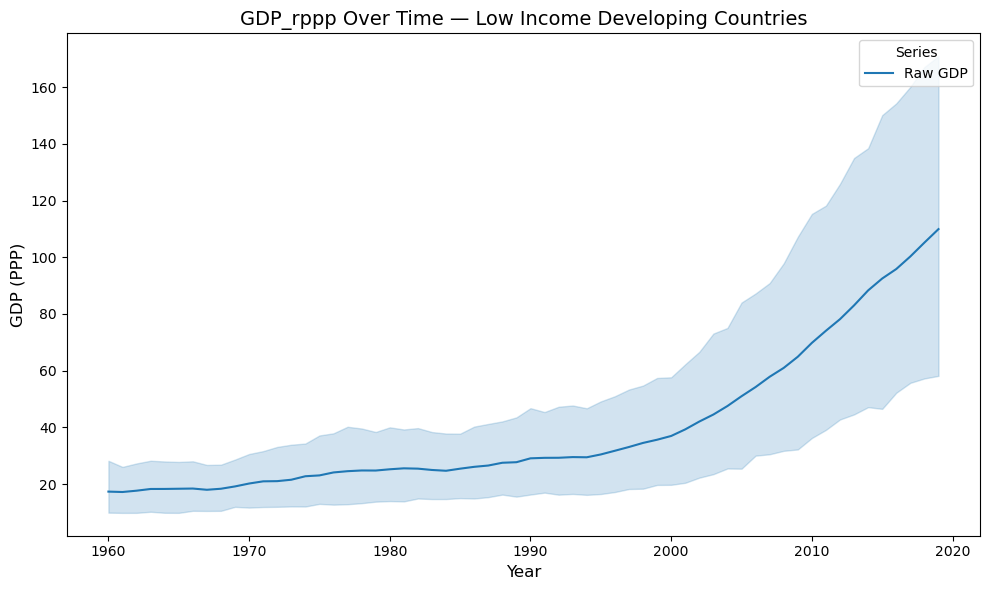

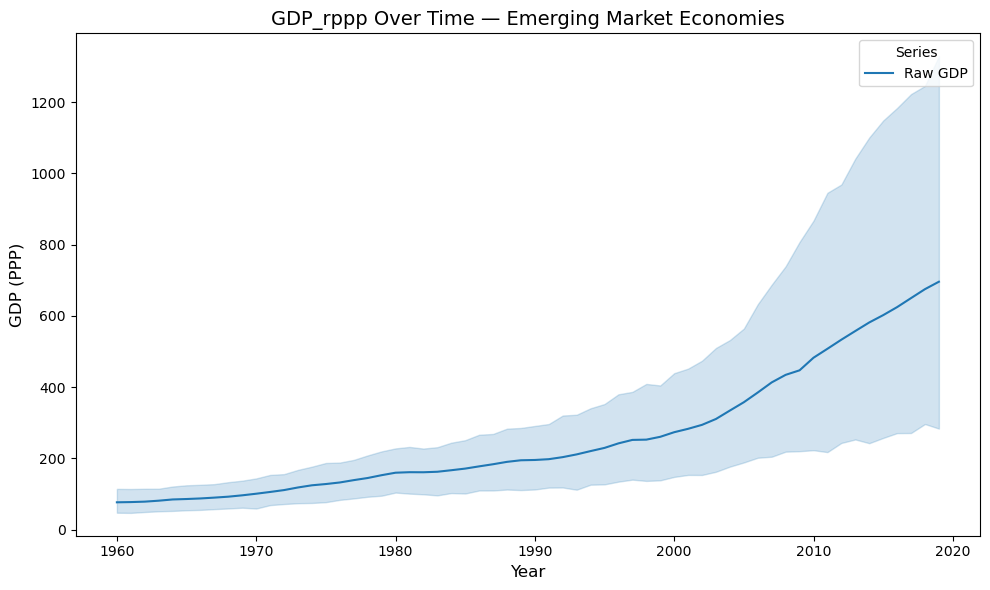

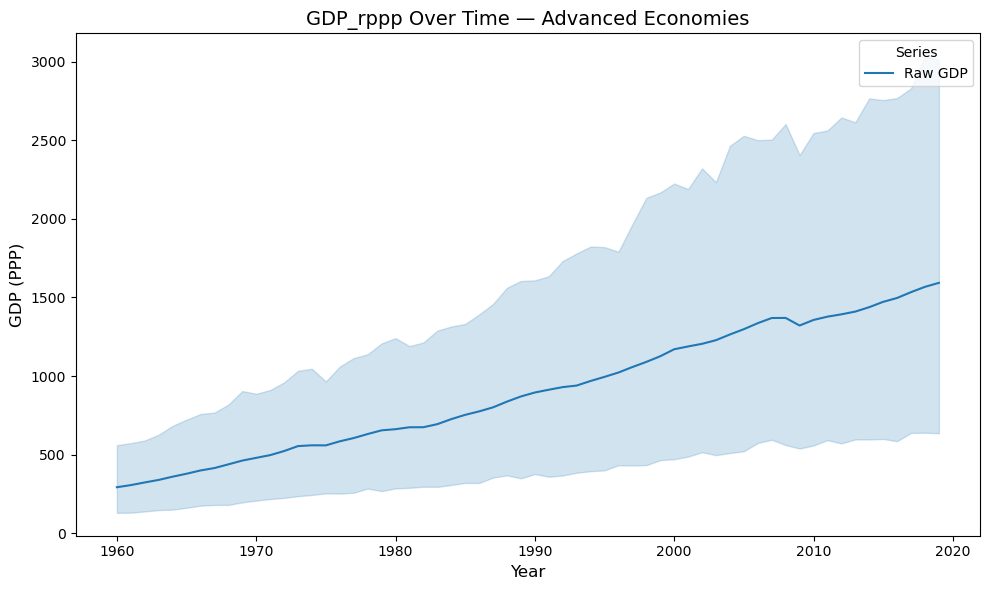

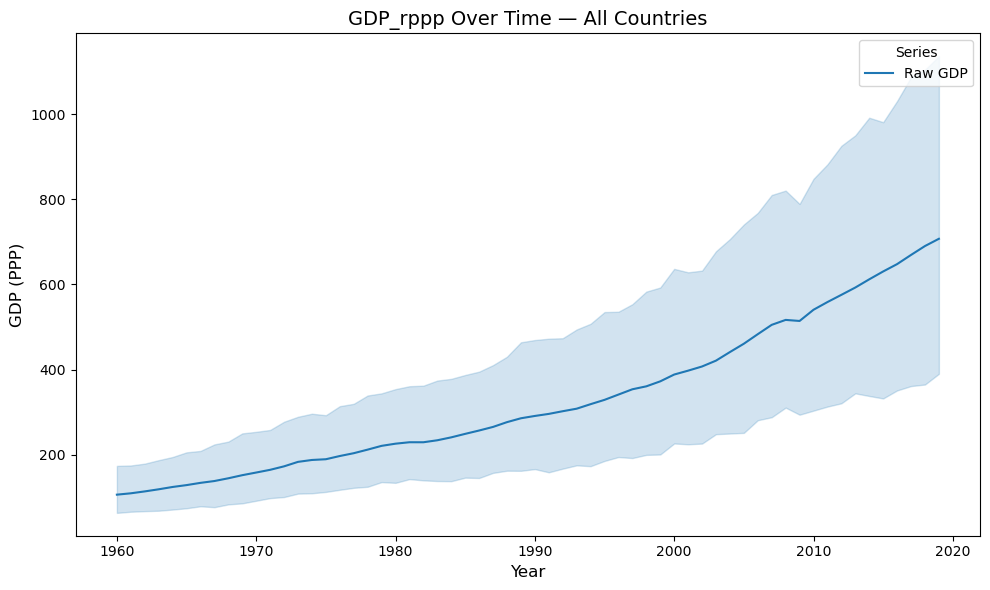

In [48]:
#  Raw GDP_rppp over time by income‐group
for group, group_df in panel_1_groups.items():
    df = group_df.reset_index()
    fig, ax = plt.subplots(figsize=(10,6))
    sns.lineplot(data=df, x='year', y='GDP_rppp', ax=ax, label='Raw GDP')
    ax.set_title(f'GDP_rppp Over Time — {group}', fontsize=14)
    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel('GDP (PPP)', fontsize=12)
    ax.legend(title='Series')
    fig.tight_layout()
    plt.show()

# raw full
df_all = panel_2.reset_index()
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(data=df_all, x='year', y='GDP_rppp', ax=ax, label='Raw GDP')
ax.set_title('GDP_rppp Over Time — All Countries', fontsize=14)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('GDP (PPP)', fontsize=12)
ax.legend(title='Series')
fig.tight_layout()
plt.show()


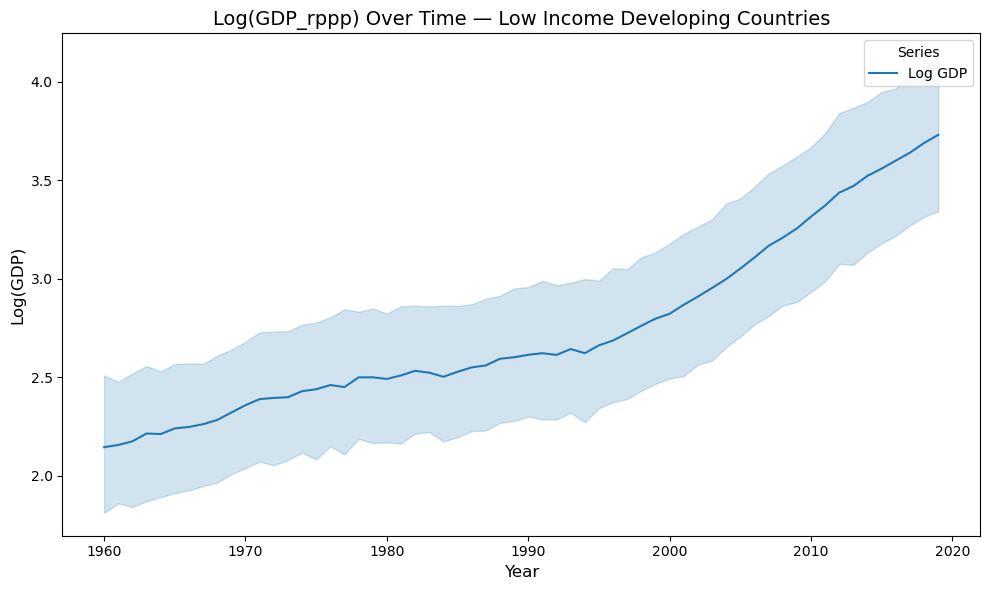

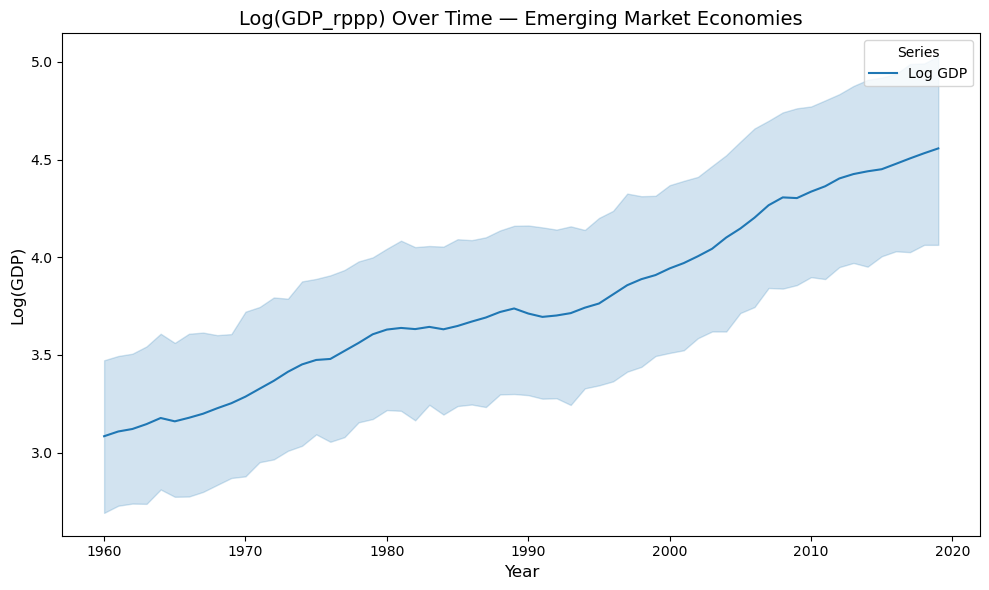

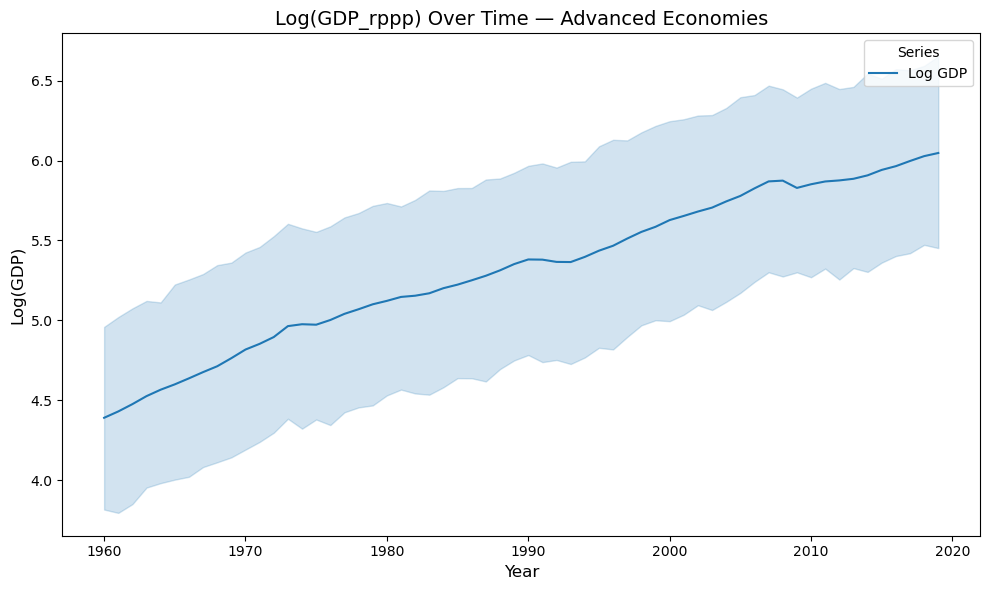

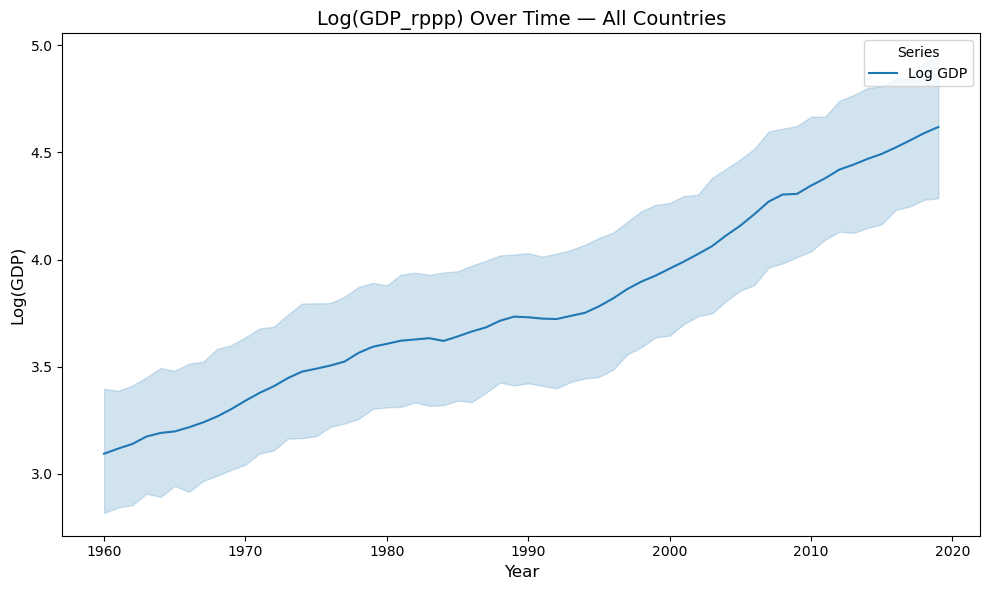

In [49]:
# Log‐transformed over time by income‐group
for group, group_df in panel_1_groups.items():
    df = group_df.reset_index()
    fig, ax = plt.subplots(figsize=(10,6))
    sns.lineplot(data=df, x='year', y= np.log1p(df['GDP_rppp']), ax=ax, label='Log GDP')
    ax.set_title(f'Log(GDP_rppp) Over Time — {group}', fontsize=14)
    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel('Log(GDP)', fontsize=12)
    ax.legend(title='Series')
    fig.tight_layout()
    plt.show()

# log full
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(data=df_all, x='year', y=np.log1p(df_all['GDP_rppp']), ax=ax, label='Log GDP')
ax.set_title('Log(GDP_rppp) Over Time — All Countries', fontsize=14)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Log(GDP)', fontsize=12)
ax.legend(title='Series')
fig.tight_layout()
plt.show()


In [50]:
def train_test_models(df, feature_cols, target='GDP_rppp', model_type='linear'):
    """Train-Test split modeling."""
    X = df[feature_cols]
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    if model_type == 'linear':
        model = LinearRegression()
    else:
        model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"{model_type.capitalize()} Model Test Results:")
    print(f"Test MSE: {mse:.4f}")
    print(f"Test R² : {r2:.4f}\n")

    return model, X_train_scaled, y_train

In [51]:
def log_transform_features(df, features_to_log, target_to_log=None):
    """Safely apply log1p transform to selected features and optionally the target."""
    df_transformed = df.copy()
    df_transformed = df_transformed[(df_transformed[features_to_log] >= 0).all(axis=1)]
    for col in features_to_log:
        df_transformed[f'log_{col}'] = np.log1p(df_transformed[col].fillna(0))
    if target_to_log:
        df_transformed[f'log_{target_to_log}'] = np.log1p(df_transformed[target_to_log].fillna(0))
    return df_transformed

In [52]:
def cross_validate_models(model, X, y, cv_type='timeseries', n_splits=5):
    """Cross-validate model with either TimeSeriesSplit and returning average MSE and R²."""
    
    if cv_type == 'timeseries':
        cv = TimeSeriesSplit(n_splits=n_splits)
    else:
        raise ValueError("Only 'timeseries' is supported in this version.")
    
    # Auto-reset y if it's a Series with non-sequential index
    if isinstance(y, pd.Series):
        if not (y.index.is_monotonic_increasing and (y.index == np.arange(len(y))).all()):
            y = y.reset_index(drop=True)
    
    mse_scores = []
    r2_scores = []
    
    for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        if isinstance(X, pd.DataFrame) or isinstance(X, pd.Series):
            X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
        else:
            X_tr, X_te = X[train_idx], X[test_idx]
        
        y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]
        
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_te)
        
        mse = mean_squared_error(y_te, y_pred)
        r2 = r2_score(y_te, y_pred)
        
        print(f"Fold {i+1}: MSE={mse:.4f}, R²={r2:.4f}")
        mse_scores.append(mse)
        r2_scores.append(r2)
    
    avg_mse = np.mean(mse_scores)
    avg_r2 = np.mean(r2_scores)
    
    print(f"\nAverage MSE: {avg_mse:.4f}")
    print(f"Average R² : {avg_r2:.4f}\n")
    
    return avg_mse, avg_r2


In [53]:
def print_feature_importance(model, feature_names):
    """Print feature importances for Random Forest models."""
    if hasattr(model, 'feature_importances_'):
        importance = pd.Series(model.feature_importances_, index=feature_names)
        importance = importance.sort_values(ascending=False)
        print("\nFeature Importances:")
        print(importance)
    else:
        print("Model does not support feature importances.")

In [54]:
def plot_residuals(y_true, y_pred, model_label="Model"):
    """Plot residual scatter and histogram for model evaluation."""
    resid = y_true - y_pred

    # Scatter plot
    plt.figure(figsize=(8,5))
    plt.scatter(y_pred, resid, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f'Residuals Scatter - {model_label}')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.grid(True)
    plt.show()

    # Histogram plot
    plt.figure(figsize=(8,5))
    sns.histplot(resid, kde=True, color='blue', bins=20)
    plt.title(f'Distribution of Residuals - {model_label}')
    plt.xlabel('Residuals')
    plt.grid(True)
    plt.show()


In [55]:
def train_test_models(
    df,
    feature_cols,
    target='GDP_rppp',
    model_type='linear',
    test_size=0.2,
    random_state=42
):
    """
    1) Drops any rows where the target is missing
    2) Builds a Pipeline(
    3) Fits on a time-ordered train split, evaluates on the hold-out
    4) Returns the fitted Pipeline plus the raw X_train, y_train for CV
    """
    # 1) select X/y and drop missing y
    X = df[feature_cols]
    y = df[target]
    mask = y.notna()
    X = X.loc[mask]
    y = y.loc[mask]

    # 2) train/test split (no shuffle → preserves time order)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        shuffle=False,
        random_state=random_state
    )

    # 3) build the pipeline
    steps = [
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]
    if model_type == 'linear':
        steps.append(('model', LinearRegression()))
    else:
        steps.append((
            'model',
            RandomForestRegressor(n_estimators=100, random_state=random_state, n_jobs=-1)
        ))
    pipeline = Pipeline(steps)

    # 4) fit & evaluate
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2  = r2_score(y_test, y_pred)

    print(f"{model_type.title()} Model Test Results:")
    print(f" → Test MSE: {mse:.4f}")
    print(f" → Test R² : {r2:.4f}\n")

    # 5) return the pipeline (handles impute/scale internally) plus raw train data for CV
    return pipeline, X_train, y_train


In [56]:
def evaluate_dataset(
    df,
    dataset_label: str,
    features: list,
    features_to_log: list,
    target: str = 'GDP_rppp',
    is_panel: bool = False,
      min_log_rows: int = 2 
):
    """
    Run No-Log, Log, and Panel FE specs on feature list
    Returns a list of result dicts.
    """
    results = []

    log_features = [f'log_{c}' for c in features]
    
    # 1) NO-LOG MODELS
    print(f"\n{'='*10} {dataset_label} – No Log Models {'='*10}")
    # Linear
    model_lr, X_train_lr, y_train_lr = train_test_models(df, features, target, 'linear')
    mse_lr, r2_lr = cross_validate_models(model_lr, X_train_lr, y_train_lr)
    plot_residuals(y_train_lr, model_lr.predict(X_train_lr),
                   model_label=f"Linear (No Log, {dataset_label})")
    results.append({
        'Dataset': dataset_label,
        'Model': 'Linear (No Log)',
        'MSE': mse_lr,
        'R2': r2_lr
    })
    # Random Forest
    model_rf, X_train_rf, y_train_rf = train_test_models(df, features, target, 'randomforest')
    mse_rf, r2_rf = cross_validate_models(model_rf, X_train_rf, y_train_rf)
    print_feature_importance(model_rf, features)
    plot_residuals(y_train_rf, model_rf.predict(X_train_rf),
                   model_label=f"Random Forest (No Log, {dataset_label})")
    results.append({
        'Dataset': dataset_label,
        'Model': 'Random Forest (No Log)',
        'MSE': mse_rf,
        'R2': r2_rf
    })
    
    # 2) LOG MODELS (Cobb–Douglas)
    
    print(f"\n{'='*10} {dataset_label} – Log Models {'='*10}")
    df_log = log_transform_features(df, features_to_log=features, target_to_log=target)
    
    if df_log.shape[0] < min_log_rows:
        print(f"Skipping Log Models for {dataset_label}: only {df_log.shape[0]} rows after log → need ≥ {min_log_rows}.")
    else:
        # Linear on log
        model_lr_log, X_lr_log, y_lr_log = train_test_models(
            df_log, log_features, target=f'log_{target}', model_type='linear'
        )
        mse_lr_log, r2_lr_log = cross_validate_models(model_lr_log, X_lr_log, y_lr_log)
        plot_residuals(y_lr_log, model_lr_log.predict(X_lr_log),
                       model_label=f"Linear (Log, {dataset_label})")
        results.append({
            'Dataset': dataset_label,
            'Model': 'Linear (Log)',
            'MSE': mse_lr_log,
            'R2': r2_lr_log
        })
        
        # RF on log
        model_rf_log, X_rf_log, y_rf_log = train_test_models(
            df_log, log_features, target=f'log_{target}', model_type='randomforest'
        )
        mse_rf_log, r2_rf_log = cross_validate_models(model_rf_log, X_rf_log, y_rf_log)
        print_feature_importance(model_rf_log, log_features)
        plot_residuals(y_rf_log, model_rf_log.predict(X_rf_log),
                       model_label=f"RF (Log, {dataset_label})")
        results.append({
            'Dataset': dataset_label,
            'Model': 'Random Forest (Log)',
            'MSE': mse_rf_log,
            'R2': r2_rf_log
        })
        

    return results



========== Full – set1 – No Log Models ==========
Linear Model Test Results:
 → Test MSE: 750051.4654
 → Test R² : 0.8359

Fold 1: MSE=160606.4430, R²=0.9352
Fold 2: MSE=64660.2085, R²=0.8833
Fold 3: MSE=107730.9505, R²=0.9163
Fold 4: MSE=6177.9166, R²=0.9351
Fold 5: MSE=10978.8247, R²=0.8093

Average MSE: 70030.8687
Average R² : 0.8958



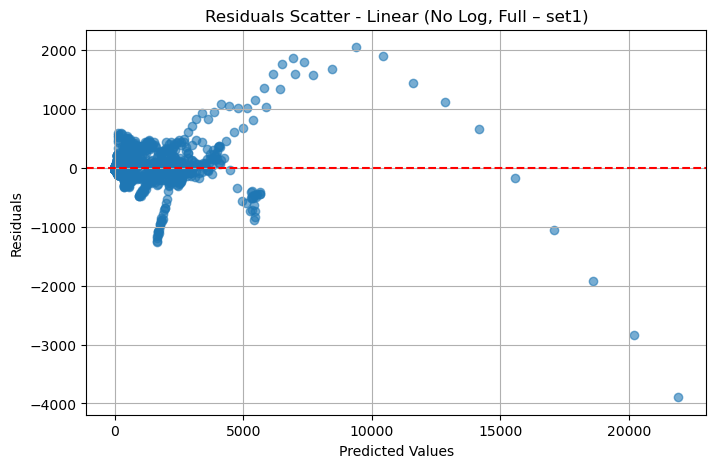

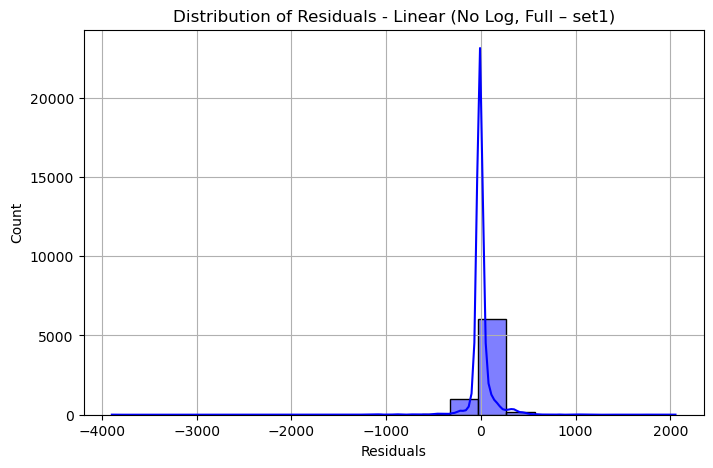

Randomforest Model Test Results:
 → Test MSE: 1599146.1277
 → Test R² : 0.6500

Fold 1: MSE=2046969.6200, R²=0.1745
Fold 2: MSE=68421.7404, R²=0.8765
Fold 3: MSE=150930.2150, R²=0.8828
Fold 4: MSE=12479.9609, R²=0.8689
Fold 5: MSE=10869.2168, R²=0.8112

Average MSE: 457934.1506
Average R² : 0.7228

Model does not support feature importances.


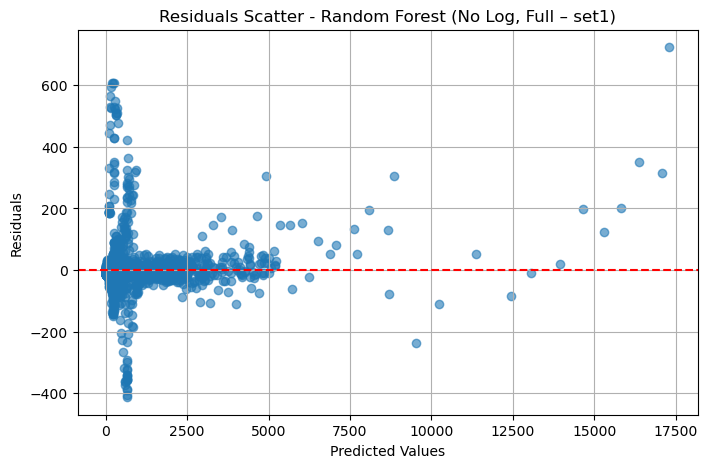

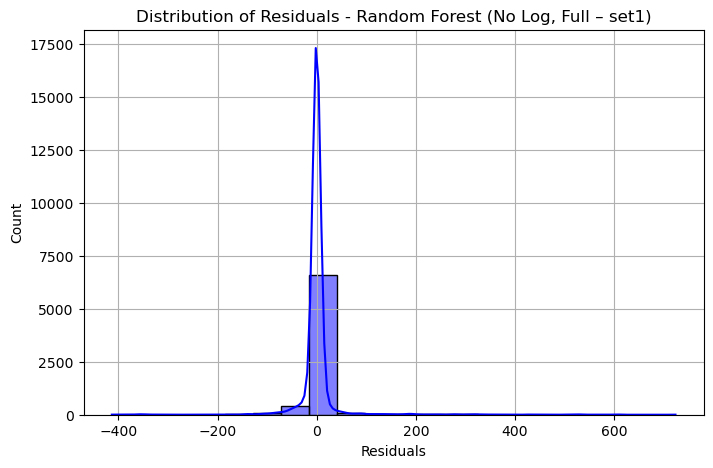


========== Full – set1 – Log Models ==========
Linear Model Test Results:
 → Test MSE: 0.1393
 → Test R² : 0.9649

Fold 1: MSE=0.1453, R²=0.9672
Fold 2: MSE=0.1147, R²=0.9700
Fold 3: MSE=0.1711, R²=0.9622
Fold 4: MSE=0.2027, R²=0.9135
Fold 5: MSE=0.0652, R²=0.9692

Average MSE: 0.1398
Average R² : 0.9564



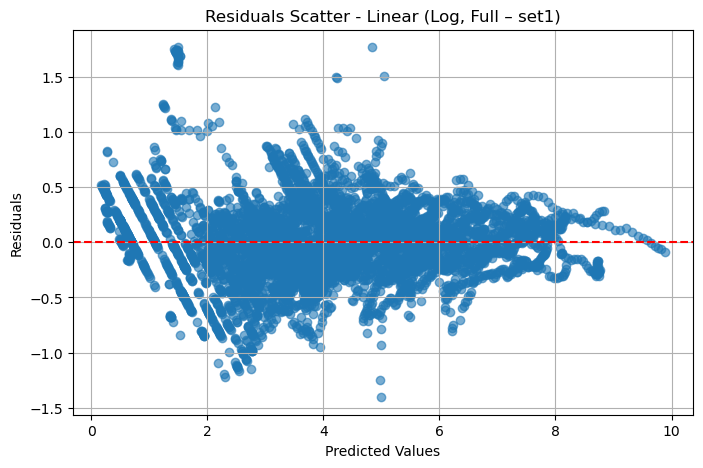

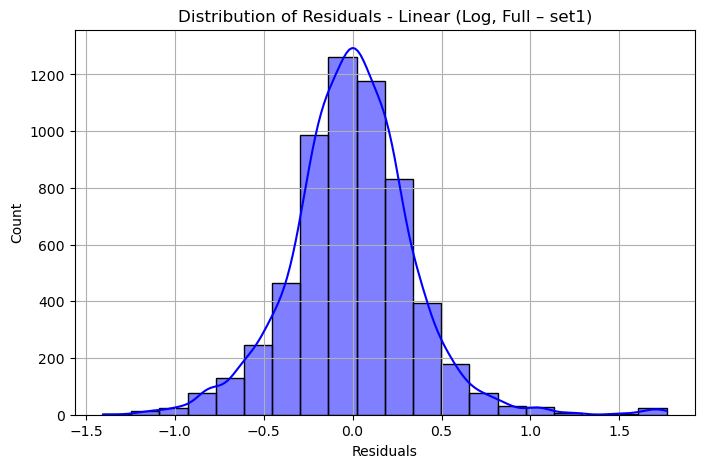

Randomforest Model Test Results:
 → Test MSE: 0.2110
 → Test R² : 0.9468

Fold 1: MSE=0.5665, R²=0.8722
Fold 2: MSE=0.2097, R²=0.9452
Fold 3: MSE=0.1968, R²=0.9565
Fold 4: MSE=0.1990, R²=0.9151
Fold 5: MSE=0.1013, R²=0.9521

Average MSE: 0.2547
Average R² : 0.9282

Model does not support feature importances.


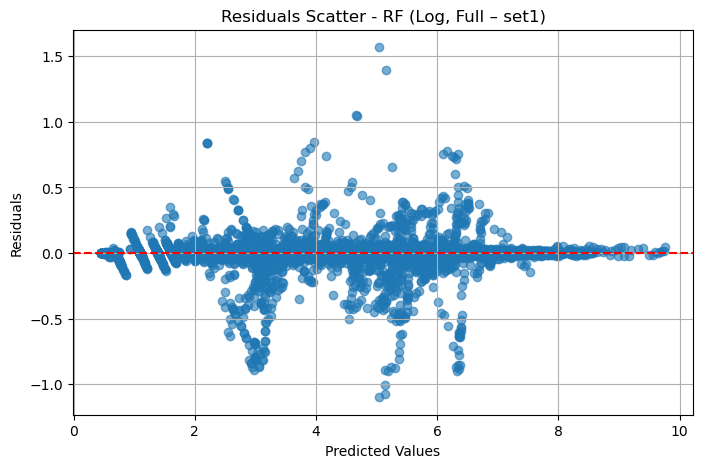

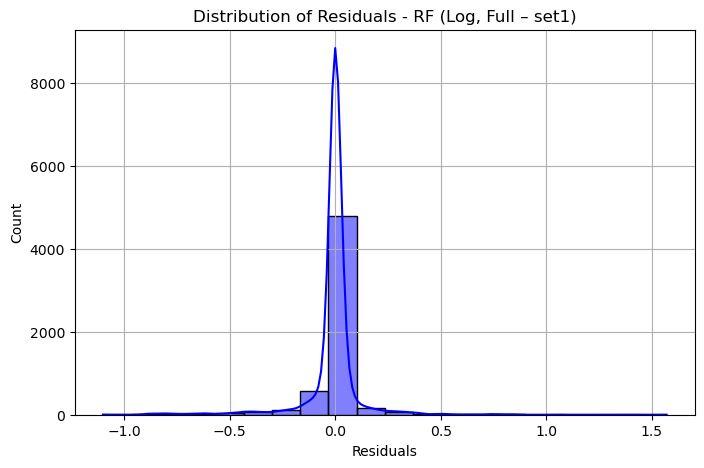


========== Full – set2 – No Log Models ==========
Linear Model Test Results:
 → Test MSE: 753980.5064
 → Test R² : 0.8350

Fold 1: MSE=131797.6449, R²=0.9469
Fold 2: MSE=71844.4771, R²=0.8703
Fold 3: MSE=104954.3501, R²=0.9185
Fold 4: MSE=6248.6792, R²=0.9343
Fold 5: MSE=11822.9599, R²=0.7947

Average MSE: 65333.6222
Average R² : 0.8929



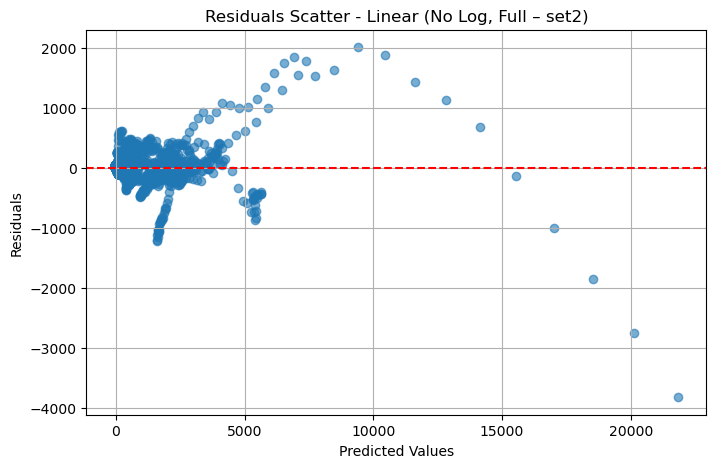

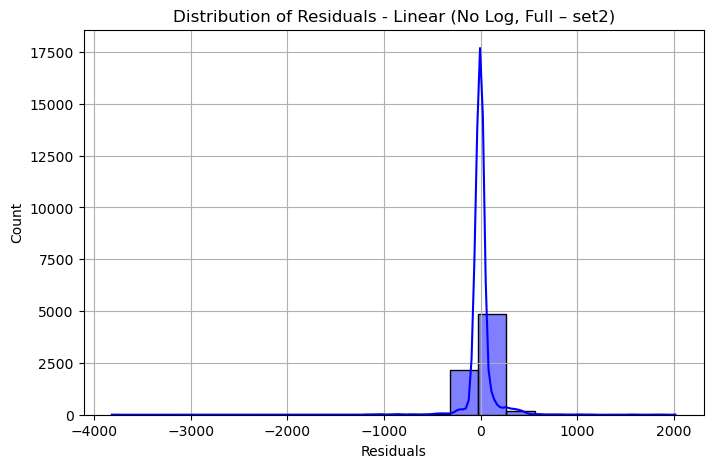

Randomforest Model Test Results:
 → Test MSE: 1195503.3932
 → Test R² : 0.7384

Fold 1: MSE=2029340.5063, R²=0.1817
Fold 2: MSE=81304.2206, R²=0.8533
Fold 3: MSE=139391.1381, R²=0.8917
Fold 4: MSE=12274.6279, R²=0.8710
Fold 5: MSE=11743.2839, R²=0.7960

Average MSE: 454810.7554
Average R² : 0.7187

Model does not support feature importances.


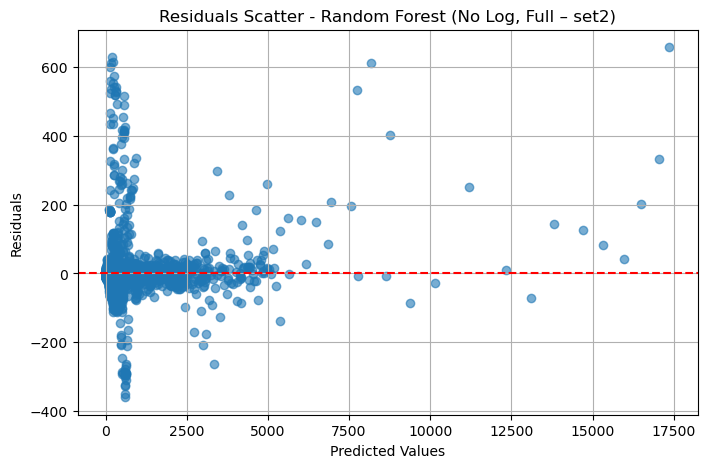

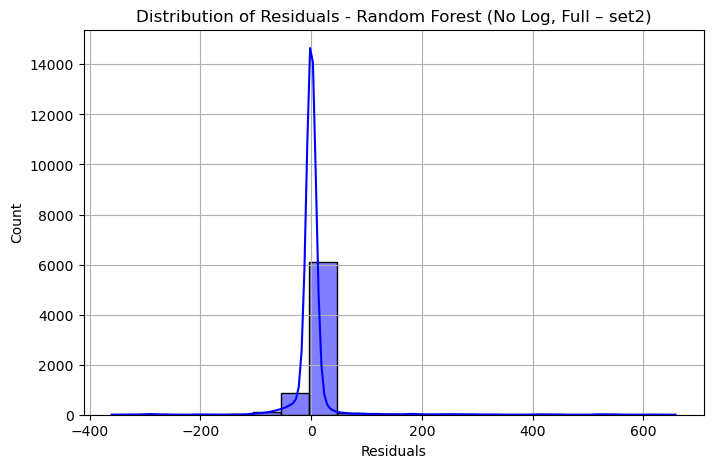


========== Full – set2 – Log Models ==========
Linear Model Test Results:
 → Test MSE: 0.0646
 → Test R² : 0.9734

Fold 1: MSE=0.0867, R²=0.9642
Fold 2: MSE=0.0935, R²=0.9639
Fold 3: MSE=0.1335, R²=0.9678
Fold 4: MSE=0.1874, R²=0.8830
Fold 5: MSE=0.0390, R²=0.9374

Average MSE: 0.1080
Average R² : 0.9433



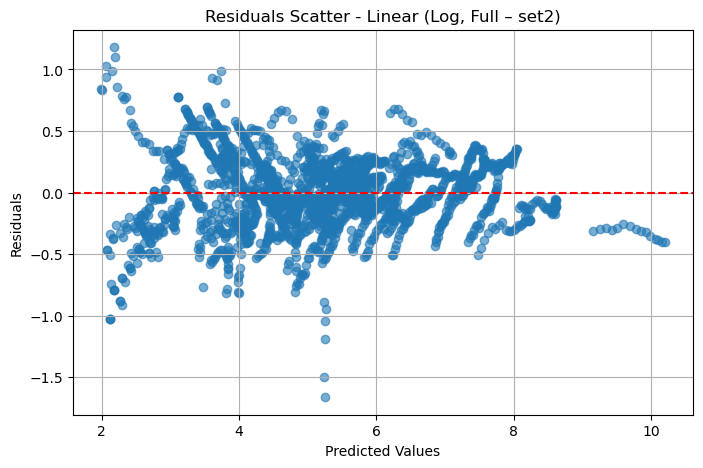

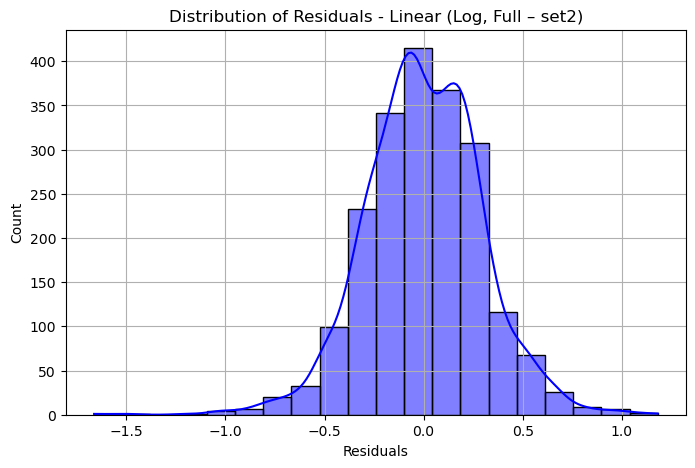

Randomforest Model Test Results:
 → Test MSE: 0.1116
 → Test R² : 0.9540

Fold 1: MSE=0.3377, R²=0.8607
Fold 2: MSE=0.1333, R²=0.9485
Fold 3: MSE=0.3714, R²=0.9104
Fold 4: MSE=0.1797, R²=0.8878
Fold 5: MSE=0.0634, R²=0.8982

Average MSE: 0.2171
Average R² : 0.9011

Model does not support feature importances.


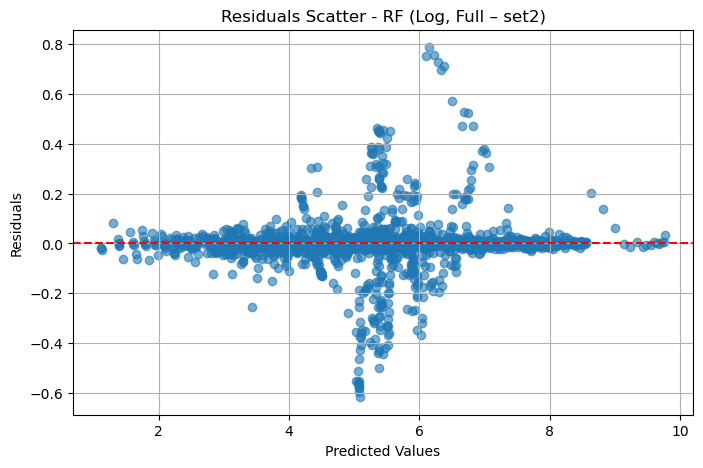

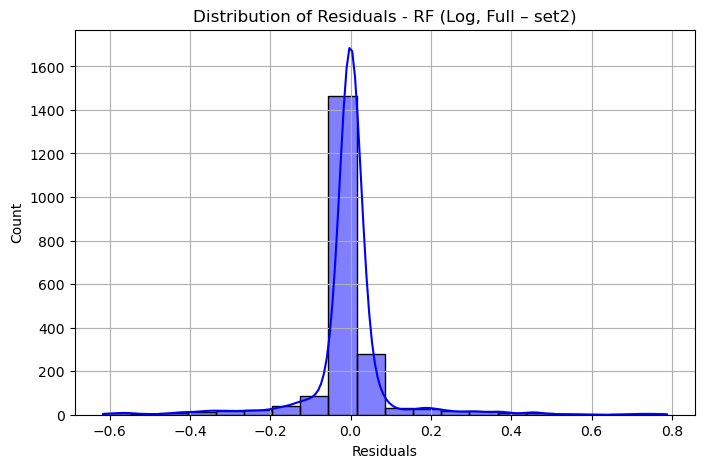


========== Full – set3 – No Log Models ==========
Linear Model Test Results:
 → Test MSE: 766769.4364
 → Test R² : 0.8322

Fold 1: MSE=173843.8881, R²=0.9299
Fold 2: MSE=71597.0338, R²=0.8708
Fold 3: MSE=112149.3611, R²=0.9129
Fold 4: MSE=5889.9522, R²=0.9381
Fold 5: MSE=12127.1876, R²=0.7894

Average MSE: 75121.4846
Average R² : 0.8882



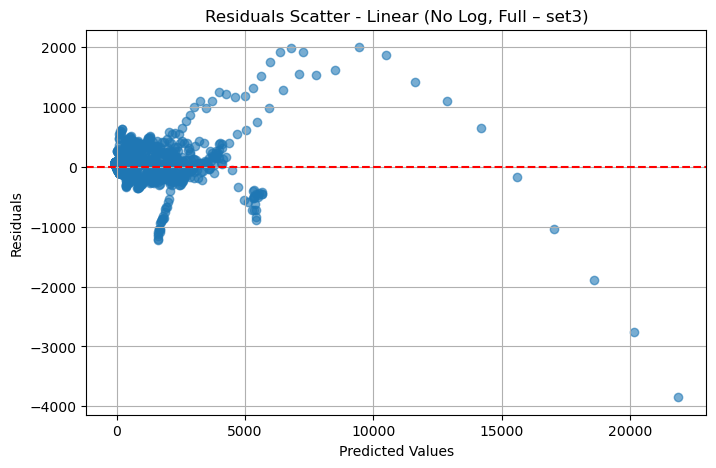

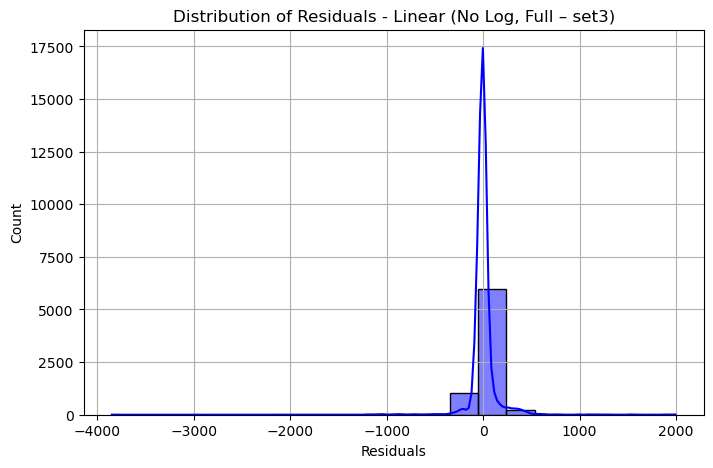

Randomforest Model Test Results:
 → Test MSE: 1191439.1400
 → Test R² : 0.7393

Fold 1: MSE=2050329.4005, R²=0.1732
Fold 2: MSE=79652.1193, R²=0.8562
Fold 3: MSE=140050.8683, R²=0.8912
Fold 4: MSE=11729.4543, R²=0.8767
Fold 5: MSE=11948.5041, R²=0.7925

Average MSE: 458742.0693
Average R² : 0.7180

Model does not support feature importances.


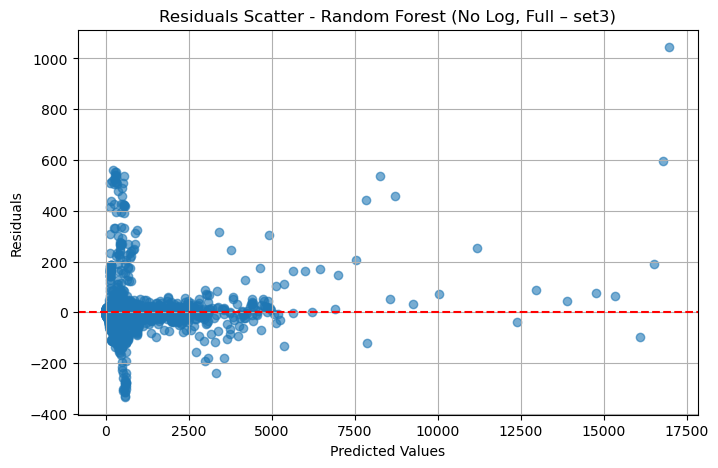

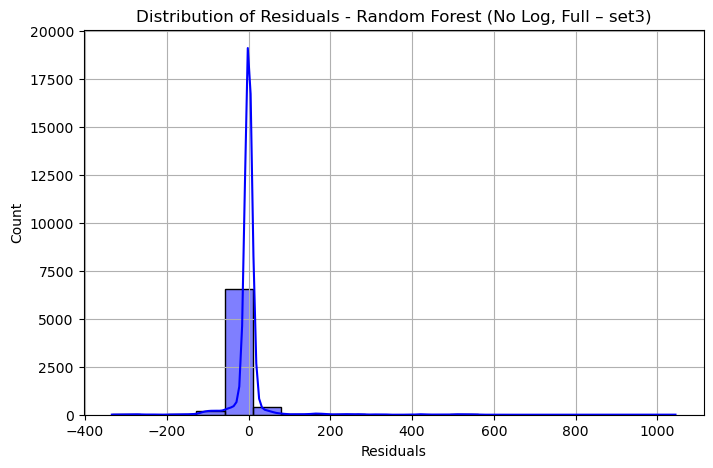


========== Full – set3 – Log Models ==========
Linear Model Test Results:
 → Test MSE: 0.0971
 → Test R² : 0.9166

Fold 1: MSE=1.1288, R²=-0.5446
Fold 2: MSE=0.0488, R²=0.8244
Fold 3: MSE=0.0146, R²=0.8927
Fold 4: MSE=0.0756, R²=0.8959
Fold 5: MSE=0.1460, R²=0.2594

Average MSE: 0.2828
Average R² : 0.4656



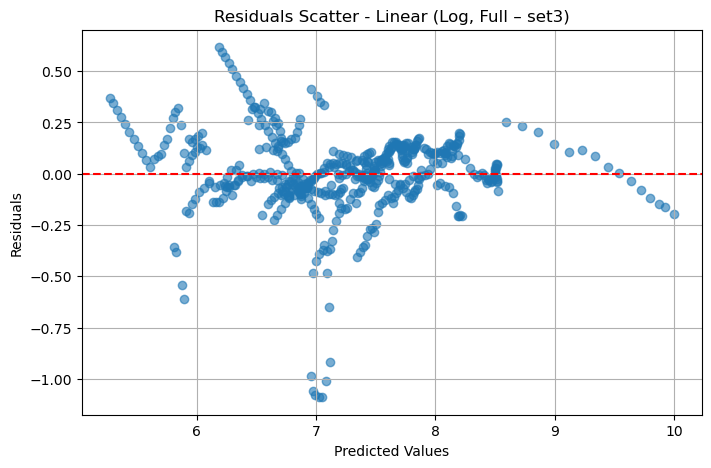

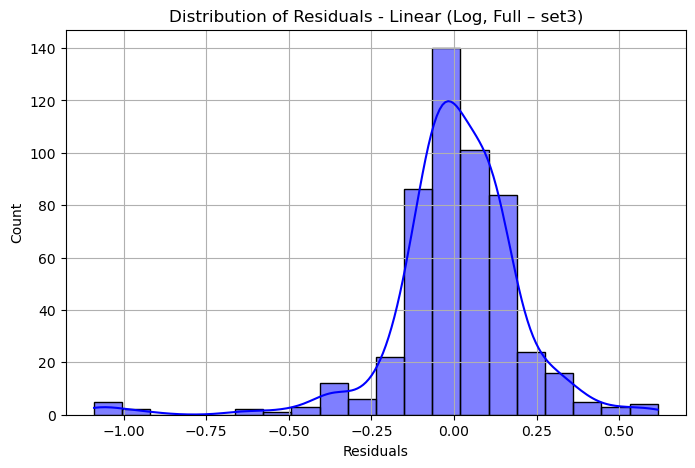

Randomforest Model Test Results:
 → Test MSE: 0.2504
 → Test R² : 0.7850

Fold 1: MSE=0.8388, R²=-0.1477
Fold 2: MSE=0.0501, R²=0.8201
Fold 3: MSE=0.0849, R²=0.3738
Fold 4: MSE=0.0291, R²=0.9599
Fold 5: MSE=0.1504, R²=0.2375

Average MSE: 0.2306
Average R² : 0.4487

Model does not support feature importances.


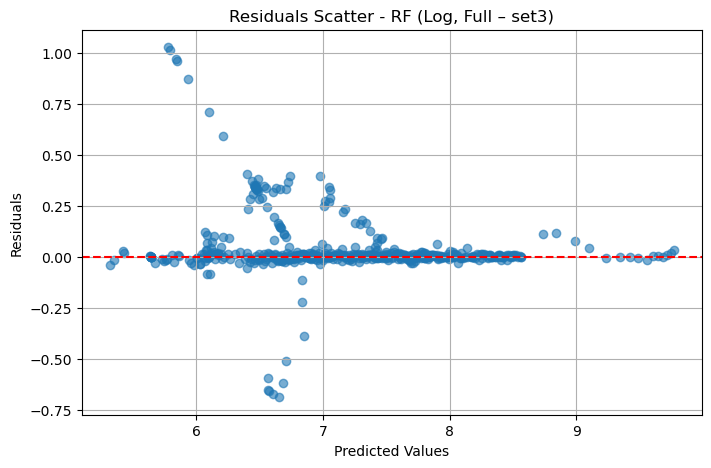

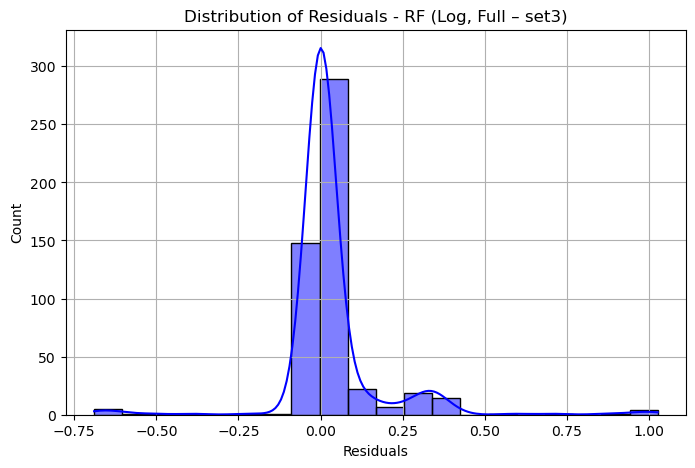


========== Full – set4 – No Log Models ==========
Linear Model Test Results:
 → Test MSE: 58567.1778
 → Test R² : 0.9872

Fold 1: MSE=208469.8660, R²=0.9159
Fold 2: MSE=34624.5609, R²=0.9375
Fold 3: MSE=253628.3580, R²=0.8030
Fold 4: MSE=16614.2531, R²=0.8254
Fold 5: MSE=17706.2660, R²=0.6925

Average MSE: 106208.6608
Average R² : 0.8349



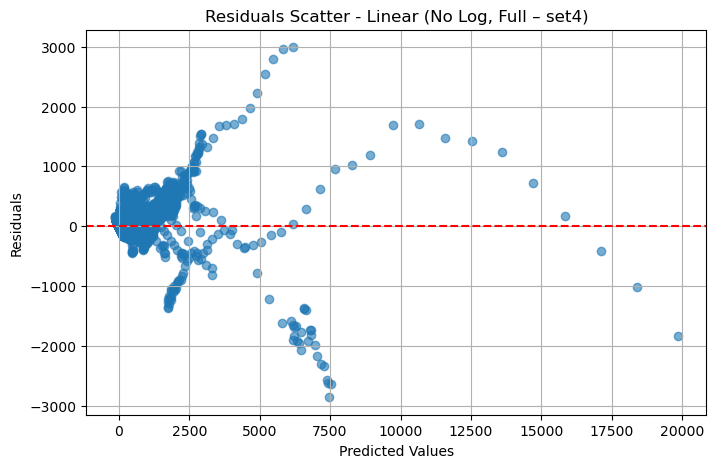

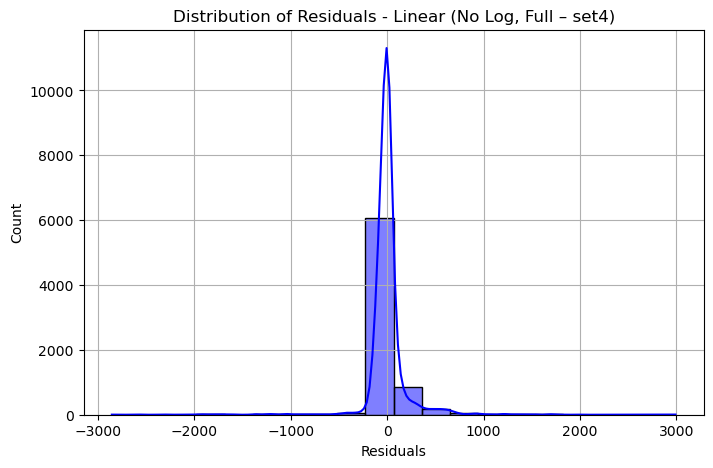

Randomforest Model Test Results:
 → Test MSE: 963243.8428
 → Test R² : 0.7892

Fold 1: MSE=2026843.6698, R²=0.1827
Fold 2: MSE=101578.2594, R²=0.8167
Fold 3: MSE=558180.2127, R²=0.5664
Fold 4: MSE=8865.4212, R²=0.9068
Fold 5: MSE=12419.3445, R²=0.7843

Average MSE: 541577.3815
Average R² : 0.6514

Model does not support feature importances.


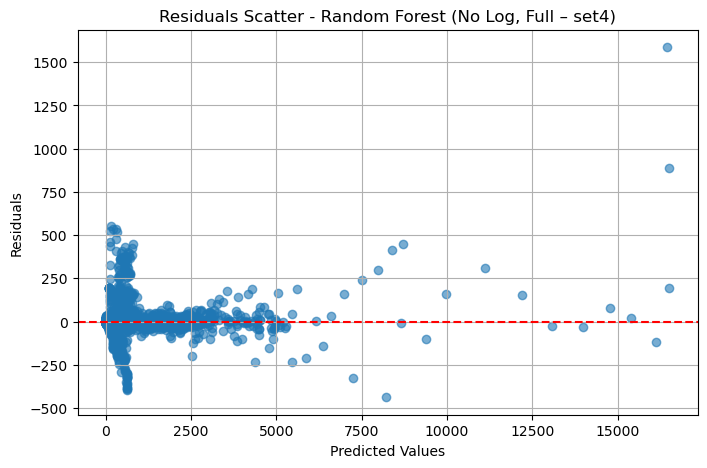

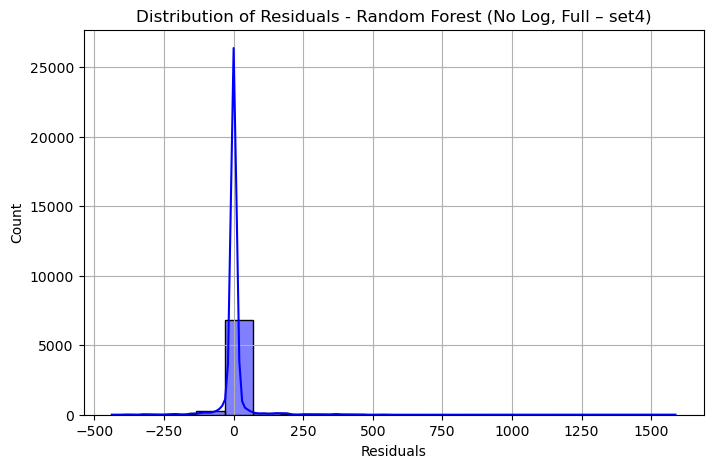


========== Full – set4 – Log Models ==========
Linear Model Test Results:
 → Test MSE: 0.0568
 → Test R² : 0.9401

Fold 1: MSE=0.2835, R²=0.6466
Fold 2: MSE=0.0716, R²=0.6118
Fold 3: MSE=0.0565, R²=0.6476
Fold 4: MSE=0.1141, R²=0.8617
Fold 5: MSE=0.1768, R²=0.0805

Average MSE: 0.1405
Average R² : 0.5696



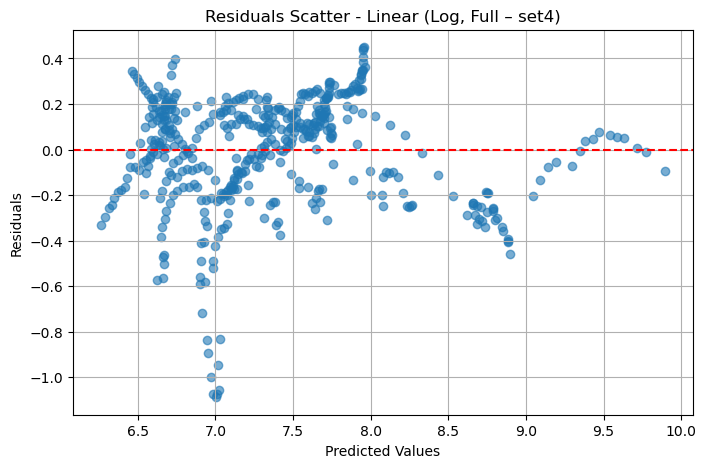

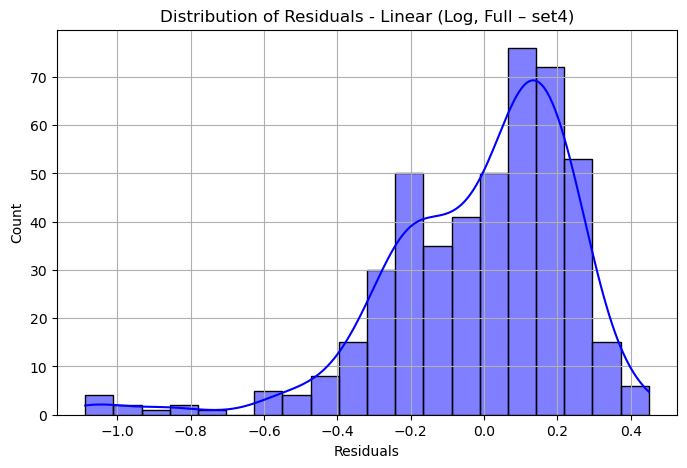

Randomforest Model Test Results:
 → Test MSE: 0.3552
 → Test R² : 0.6257

Fold 1: MSE=1.3140, R²=-0.6381
Fold 2: MSE=0.0799, R²=0.5667
Fold 3: MSE=0.0321, R²=0.7998
Fold 4: MSE=0.0680, R²=0.9176
Fold 5: MSE=0.1951, R²=-0.0147

Average MSE: 0.3378
Average R² : 0.3263

Model does not support feature importances.


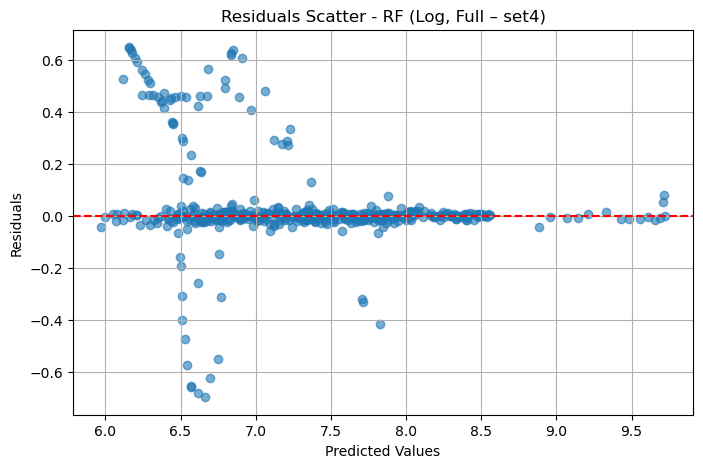

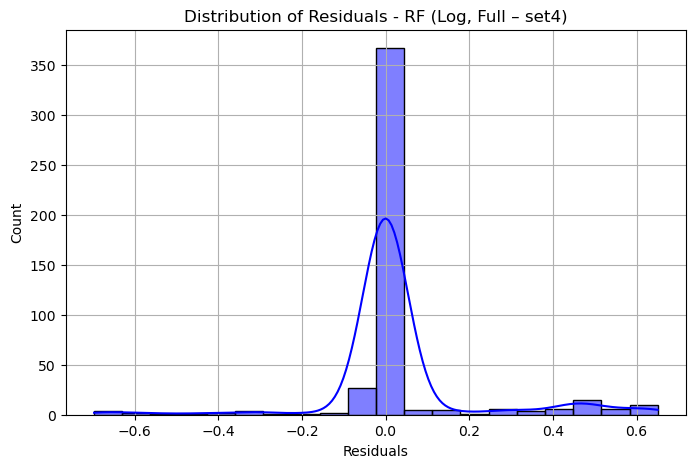

In [58]:
# Loop over all feature sets; produce both panel_2 (full) and each income_group
all_results = []

# 1) Full dataset (panel_2)
for set_name, feat in features_sets.items():
    all_results += evaluate_dataset(
        panel_2.reset_index(),      # need country & year columns
        dataset_label=f"Full – {set_name}",
        features=feat,
        features_to_log=feat,
        is_panel=True
    )



========== Low Income Developing Countries – set1 – No Log Models ==========
Linear Model Test Results:
 → Test MSE: 3850.7509
 → Test R² : 0.4881

Fold 1: MSE=26.0958, R²=0.9198
Fold 2: MSE=217.0184, R²=0.8427
Fold 3: MSE=166.5287, R²=0.8686
Fold 4: MSE=259.8709, R²=0.8281
Fold 5: MSE=7787.5343, R²=0.7562

Average MSE: 1691.4096
Average R² : 0.8431



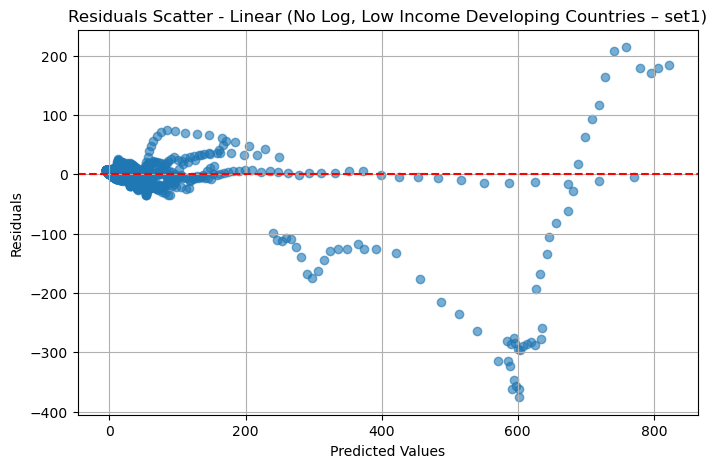

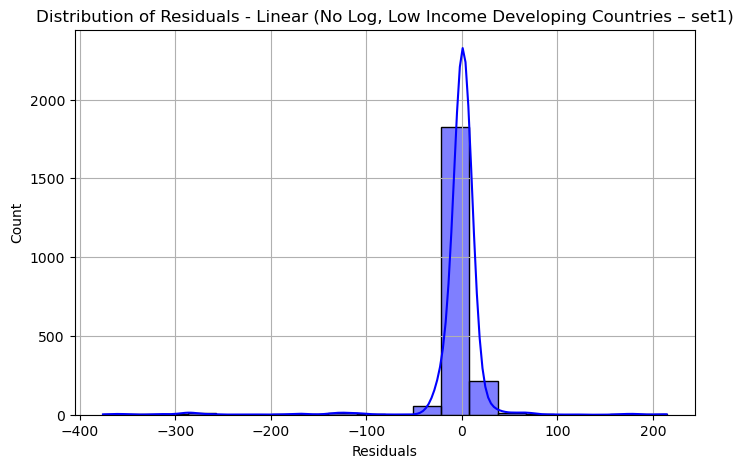

Randomforest Model Test Results:
 → Test MSE: 2499.3259
 → Test R² : 0.6678

Fold 1: MSE=87.4890, R²=0.7310
Fold 2: MSE=696.1010, R²=0.4956
Fold 3: MSE=158.9817, R²=0.8746
Fold 4: MSE=296.3507, R²=0.8040
Fold 5: MSE=5838.3814, R²=0.8172

Average MSE: 1415.4608
Average R² : 0.7445

Model does not support feature importances.


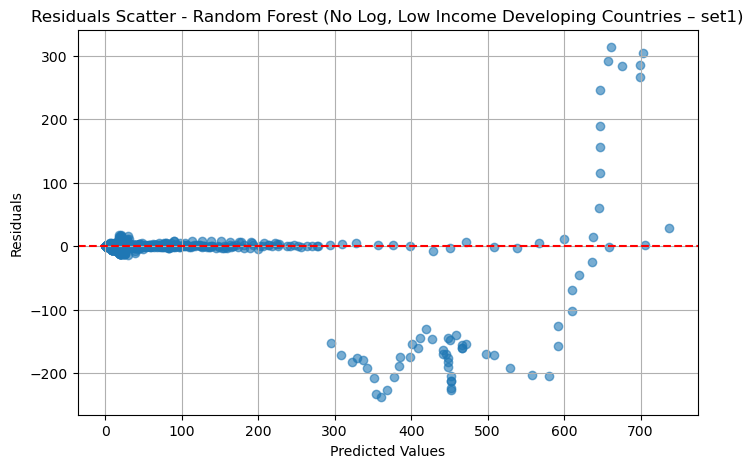

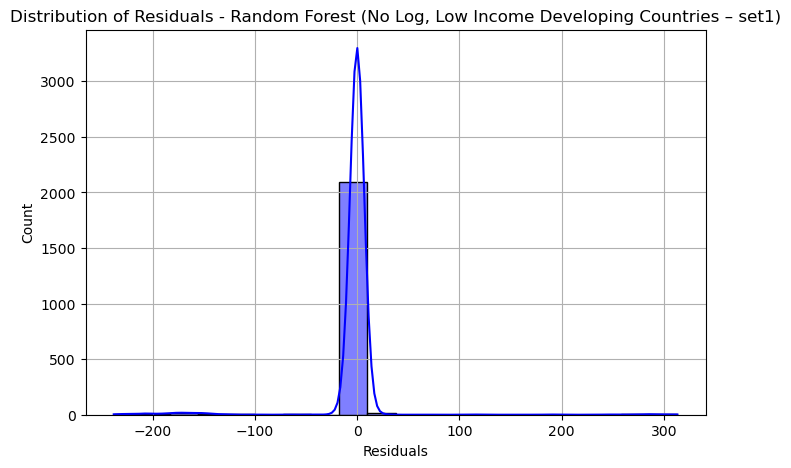


========== Low Income Developing Countries – set1 – Log Models ==========
Linear Model Test Results:
 → Test MSE: 0.3958
 → Test R² : 0.6572

Fold 1: MSE=0.7663, R²=0.4838
Fold 2: MSE=0.2001, R²=0.8898
Fold 3: MSE=0.3476, R²=0.7592
Fold 4: MSE=0.1246, R²=0.8390
Fold 5: MSE=0.2258, R²=0.8969

Average MSE: 0.3329
Average R² : 0.7737



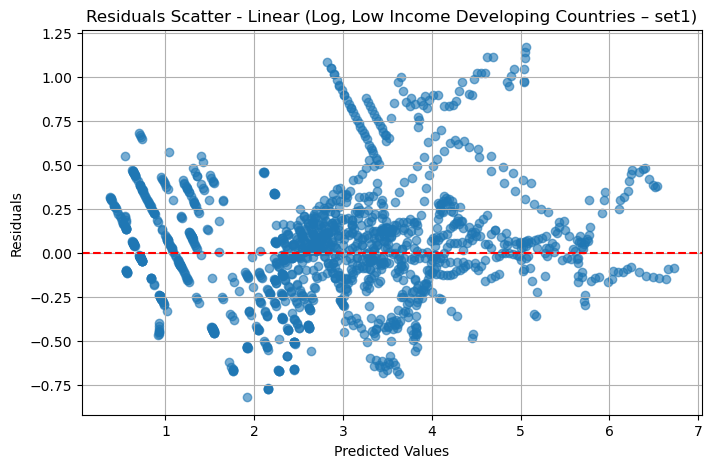

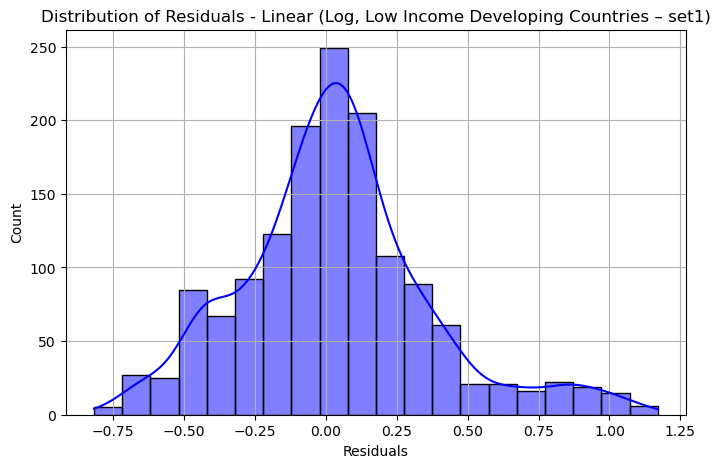

Randomforest Model Test Results:
 → Test MSE: 0.5221
 → Test R² : 0.5479

Fold 1: MSE=0.1181, R²=0.9204
Fold 2: MSE=0.1755, R²=0.9034
Fold 3: MSE=0.8148, R²=0.4357
Fold 4: MSE=0.2609, R²=0.6629
Fold 5: MSE=0.2167, R²=0.9011

Average MSE: 0.3172
Average R² : 0.7647

Model does not support feature importances.


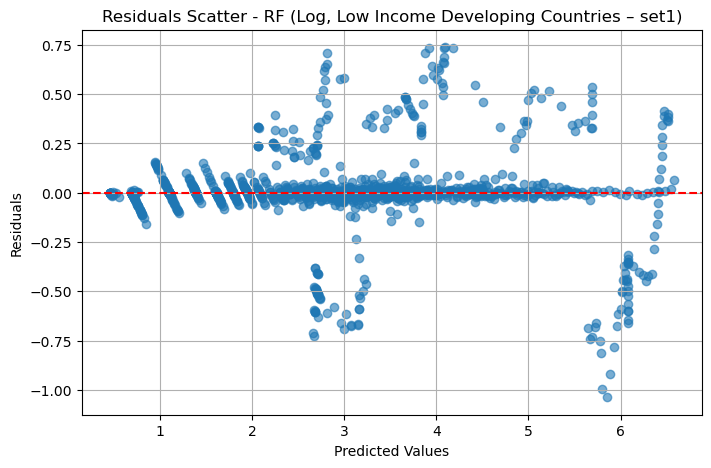

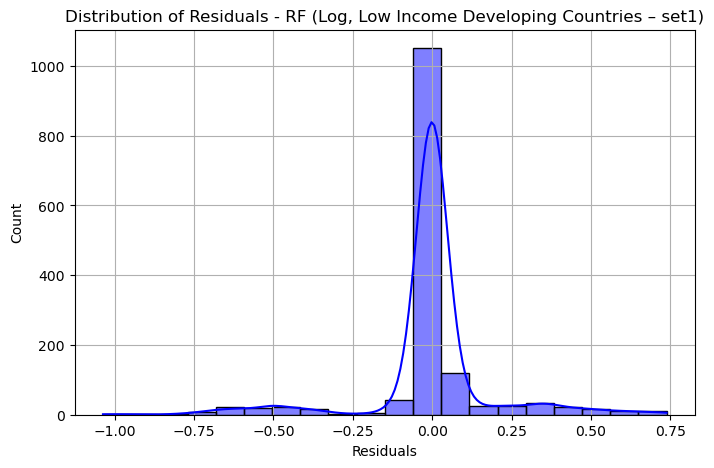


========== Emerging Market Economies – set1 – No Log Models ==========
Linear Model Test Results:
 → Test MSE: 63076.1655
 → Test R² : 0.4042

Fold 1: MSE=54023.7737, R²=0.8250
Fold 2: MSE=3238815.3318, R²=0.2960
Fold 3: MSE=240110.6594, R²=0.8028
Fold 4: MSE=16936.7660, R²=0.9008
Fold 5: MSE=5454.3088, R²=0.8252

Average MSE: 711068.1679
Average R² : 0.7300



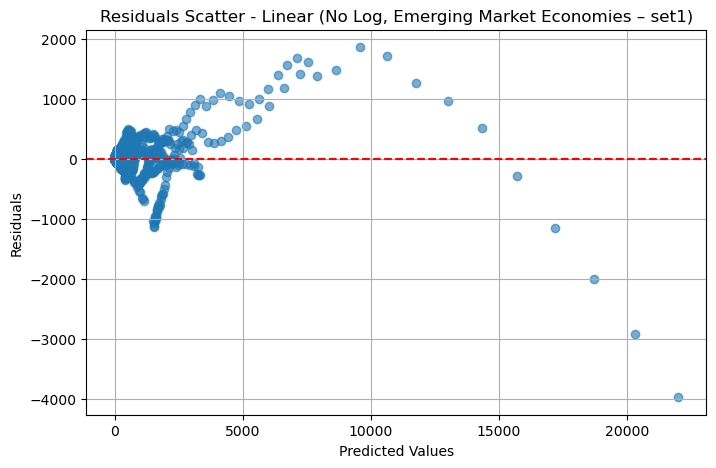

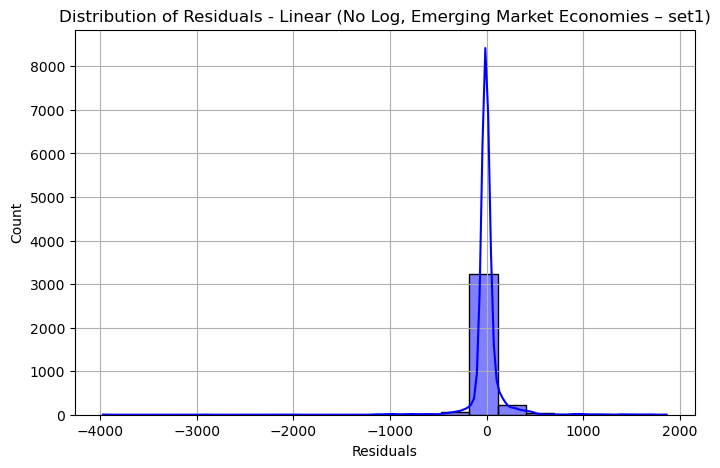

Randomforest Model Test Results:
 → Test MSE: 32116.3167
 → Test R² : 0.6966

Fold 1: MSE=141324.1630, R²=0.5423
Fold 2: MSE=2974528.4438, R²=0.3535
Fold 3: MSE=315076.6234, R²=0.7413
Fold 4: MSE=28311.7628, R²=0.8342
Fold 5: MSE=5316.7209, R²=0.8297

Average MSE: 692911.5428
Average R² : 0.6602

Model does not support feature importances.


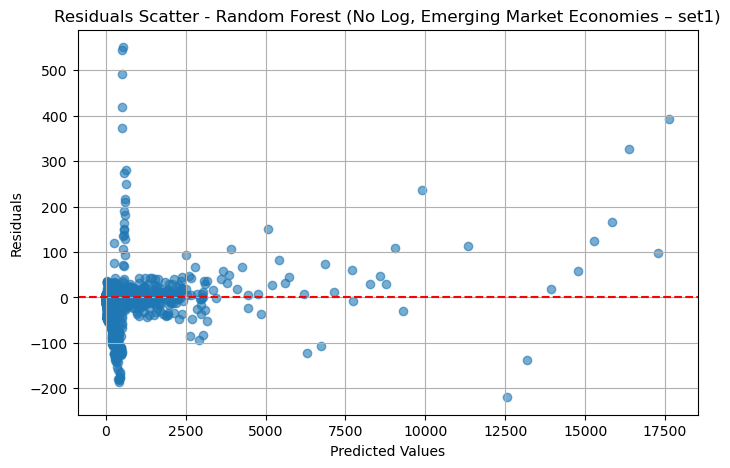

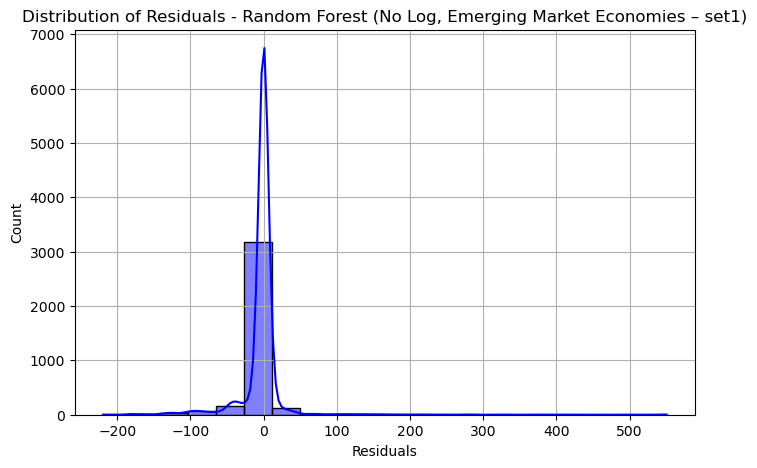


========== Emerging Market Economies – set1 – Log Models ==========
Linear Model Test Results:
 → Test MSE: 0.1169
 → Test R² : 0.9674

Fold 1: MSE=0.1831, R²=0.9531
Fold 2: MSE=0.1122, R²=0.9664
Fold 3: MSE=0.0815, R²=0.9789
Fold 4: MSE=0.2621, R²=0.8796
Fold 5: MSE=0.1030, R²=0.9576

Average MSE: 0.1484
Average R² : 0.9471



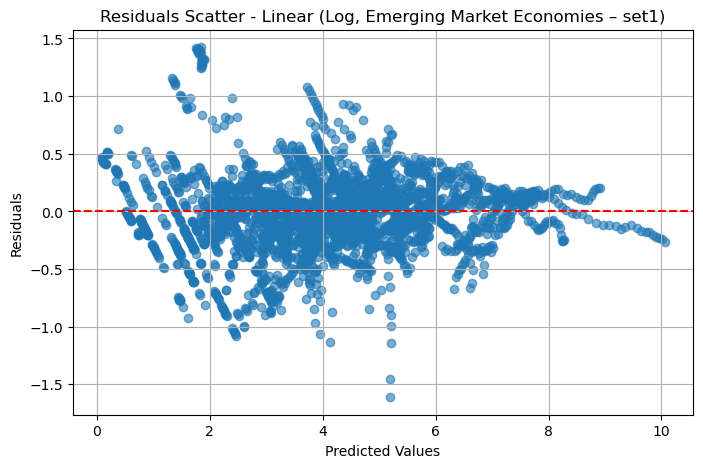

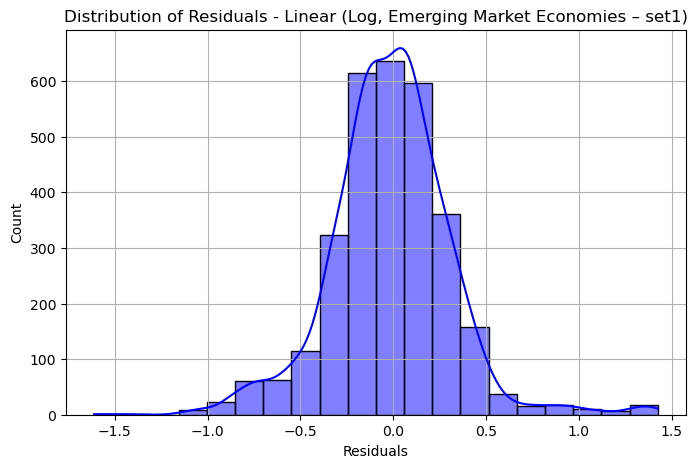

Randomforest Model Test Results:
 → Test MSE: 0.1627
 → Test R² : 0.9546

Fold 1: MSE=0.4971, R²=0.8726
Fold 2: MSE=0.3176, R²=0.9049
Fold 3: MSE=0.1899, R²=0.9509
Fold 4: MSE=0.3267, R²=0.8499
Fold 5: MSE=0.1992, R²=0.9180

Average MSE: 0.3061
Average R² : 0.8992

Model does not support feature importances.


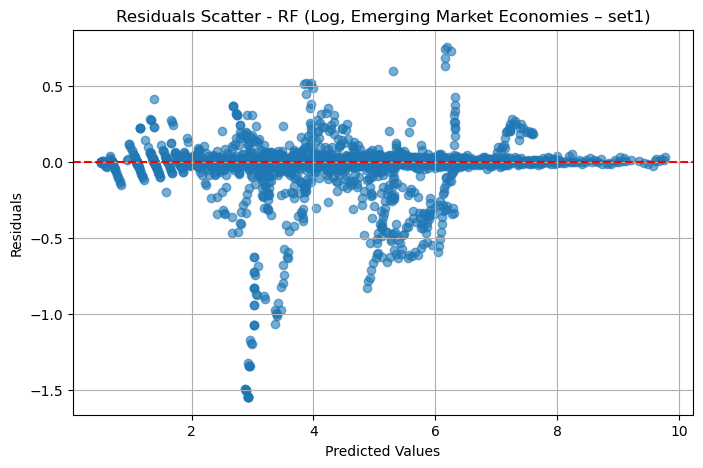

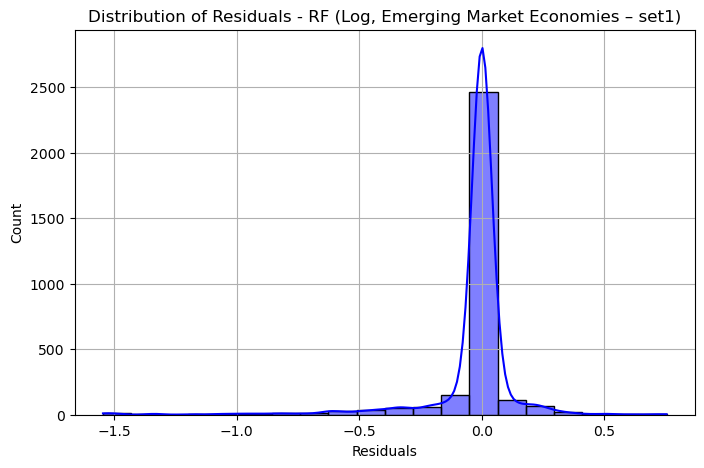


========== Advanced Economies – set1 – No Log Models ==========
Linear Model Test Results:
 → Test MSE: 1956600.4116
 → Test R² : 0.8911

Fold 1: MSE=4312.4449, R²=0.9767
Fold 2: MSE=29529.1641, R²=0.9832
Fold 3: MSE=144324.4460, R²=0.9402
Fold 4: MSE=3140.4392, R²=0.9517
Fold 5: MSE=1046.2091, R²=0.9100

Average MSE: 36470.5407
Average R² : 0.9523



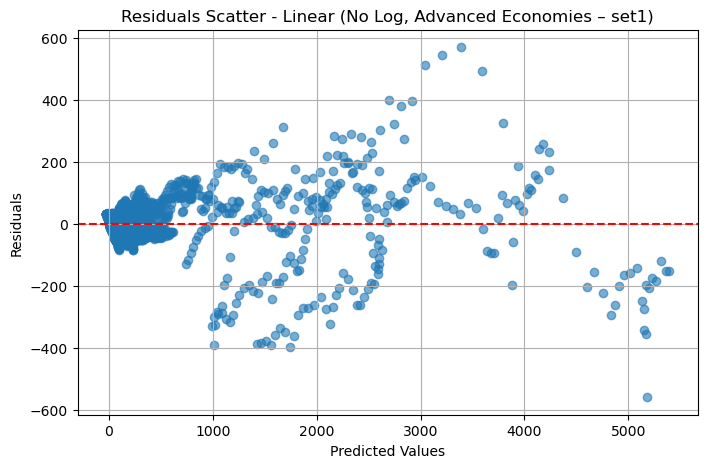

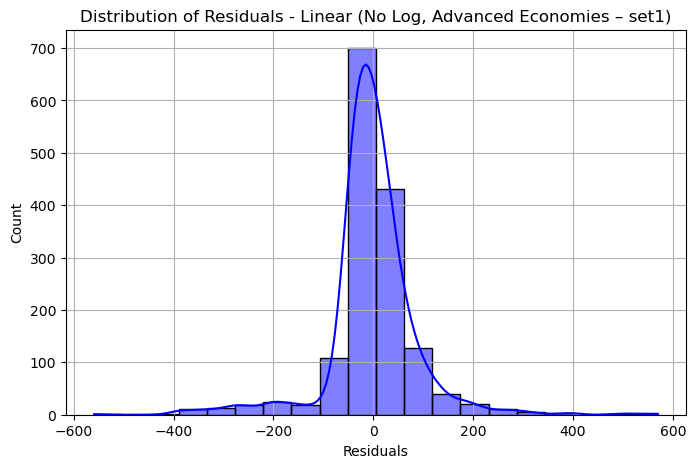

Randomforest Model Test Results:
 → Test MSE: 9913196.1698
 → Test R² : 0.4485

Fold 1: MSE=9889.5409, R²=0.9466
Fold 2: MSE=441458.7196, R²=0.7482
Fold 3: MSE=85008.2275, R²=0.9648
Fold 4: MSE=970.1281, R²=0.9851
Fold 5: MSE=959.8652, R²=0.9174

Average MSE: 107657.2963
Average R² : 0.9124

Model does not support feature importances.


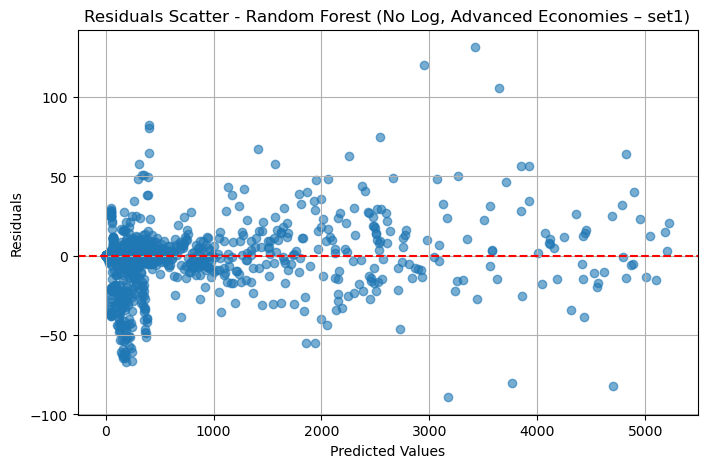

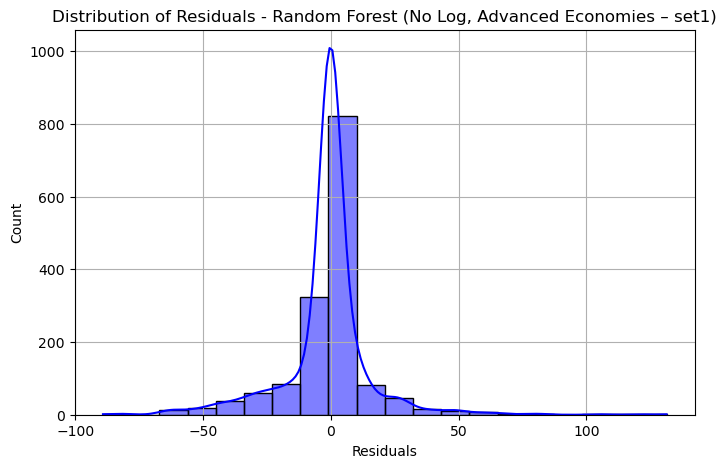


========== Advanced Economies – set1 – Log Models ==========
Linear Model Test Results:
 → Test MSE: 0.0874
 → Test R² : 0.9711

Fold 1: MSE=0.1570, R²=0.9001
Fold 2: MSE=0.1643, R²=0.9681
Fold 3: MSE=0.2223, R²=0.9270
Fold 4: MSE=0.2229, R²=0.7698
Fold 5: MSE=0.1131, R²=0.7966

Average MSE: 0.1759
Average R² : 0.8723



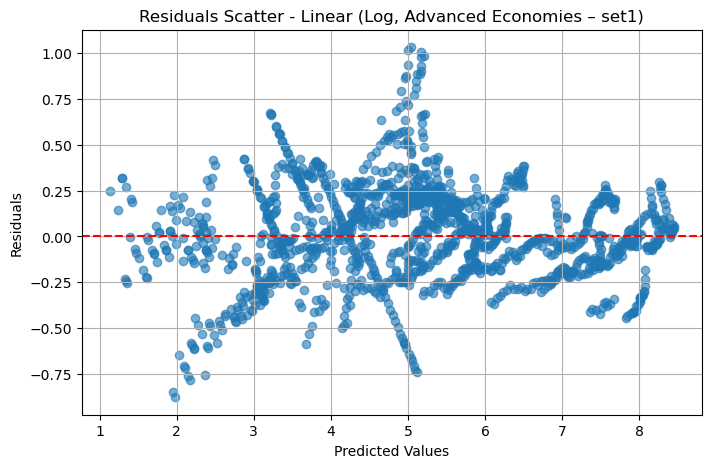

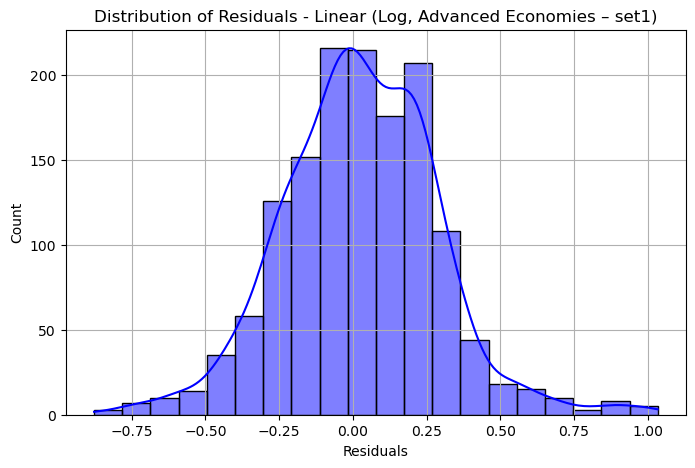

Randomforest Model Test Results:
 → Test MSE: 0.1680
 → Test R² : 0.9444

Fold 1: MSE=2.0465, R²=-0.3019
Fold 2: MSE=0.2233, R²=0.9566
Fold 3: MSE=0.0387, R²=0.9873
Fold 4: MSE=0.4226, R²=0.5637
Fold 5: MSE=0.0529, R²=0.9050

Average MSE: 0.5568
Average R² : 0.6221

Model does not support feature importances.


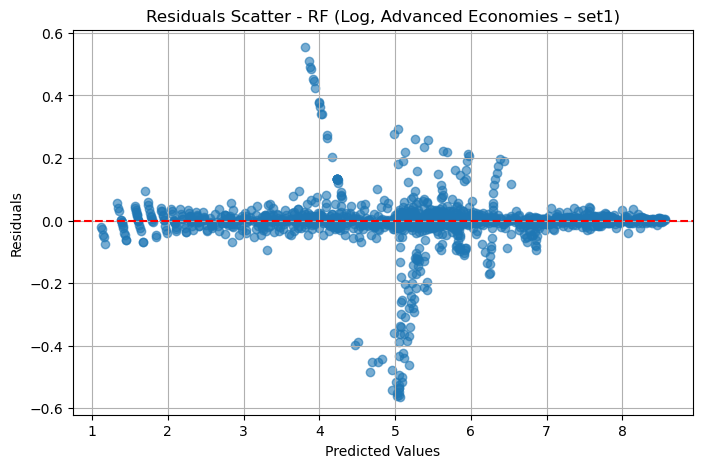

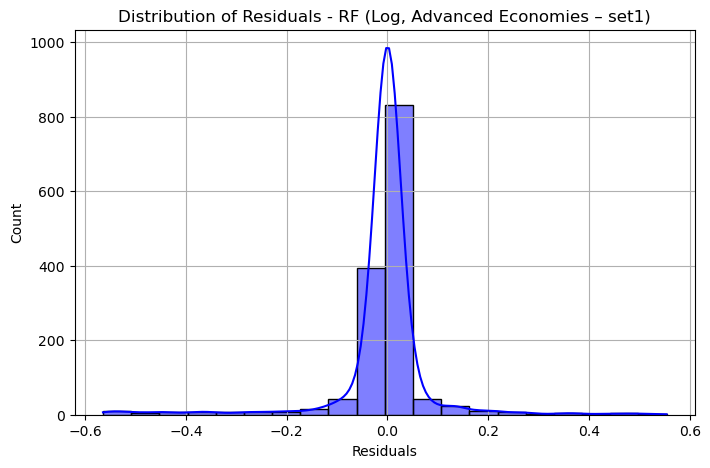


========== Low Income Developing Countries – set2 – No Log Models ==========
Linear Model Test Results:
 → Test MSE: 4001.5642
 → Test R² : 0.4681

Fold 1: MSE=23.4561, R²=0.9279
Fold 2: MSE=195.5810, R²=0.8583
Fold 3: MSE=146.8388, R²=0.8841
Fold 4: MSE=306.3759, R²=0.7974
Fold 5: MSE=7692.0854, R²=0.7592

Average MSE: 1672.8674
Average R² : 0.8454



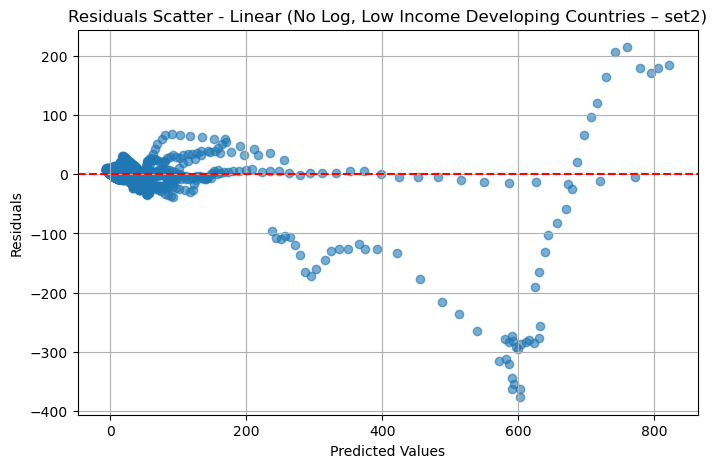

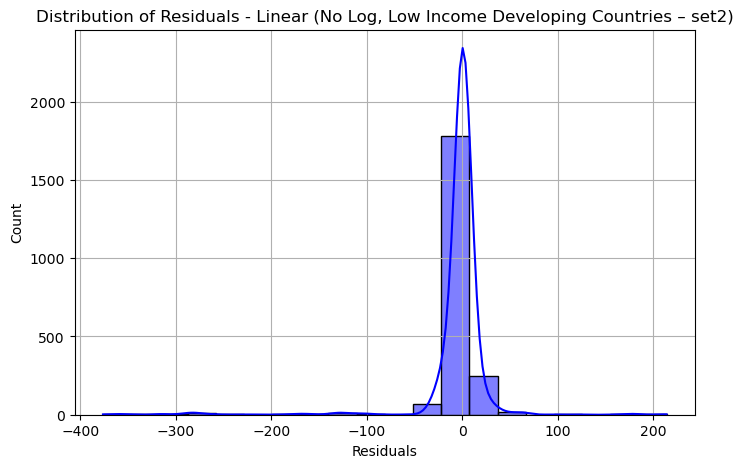

Randomforest Model Test Results:
 → Test MSE: 2678.8385
 → Test R² : 0.6439

Fold 1: MSE=33.2114, R²=0.8979
Fold 2: MSE=430.7674, R²=0.6879
Fold 3: MSE=268.1481, R²=0.7884
Fold 4: MSE=283.5510, R²=0.8125
Fold 5: MSE=5105.7787, R²=0.8402

Average MSE: 1224.2913
Average R² : 0.8054

Model does not support feature importances.


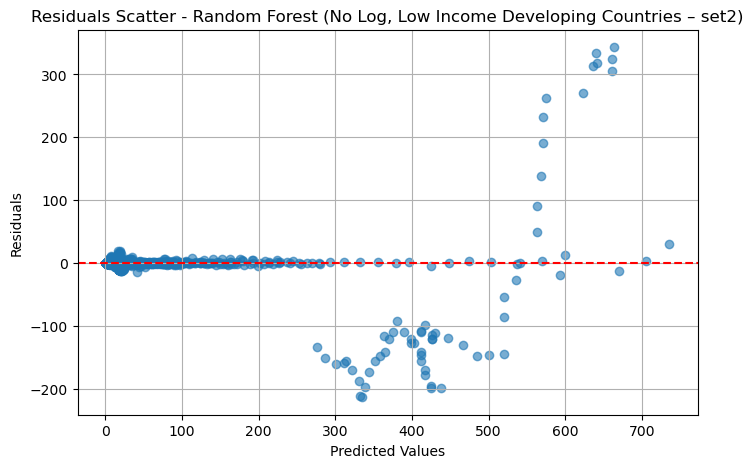

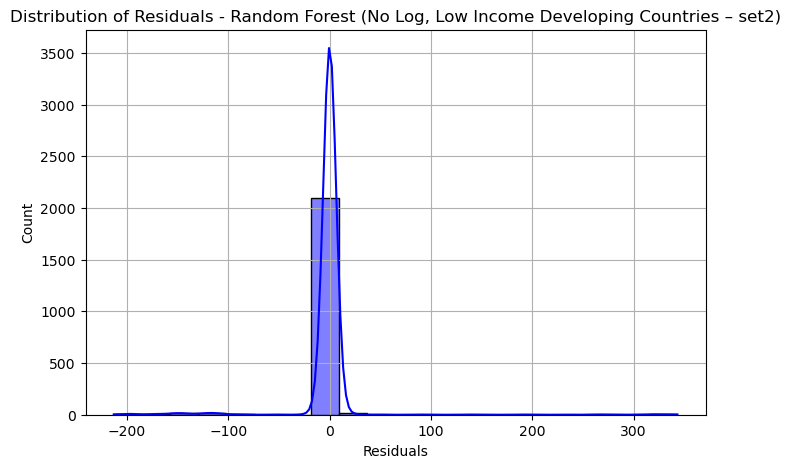


========== Low Income Developing Countries – set2 – Log Models ==========
Linear Model Test Results:
 → Test MSE: 0.3838
 → Test R² : -17.6145

Fold 1: MSE=0.0000, R²=0.0000
Fold 2: MSE=0.0000, R²=0.0000
Fold 3: MSE=0.0000, R²=1.0000
Fold 4: MSE=0.0751, R²=-0.7205
Fold 5: MSE=3811.8799, R²=-7165.9366

Average MSE: 762.3910
Average R² : -1433.1314



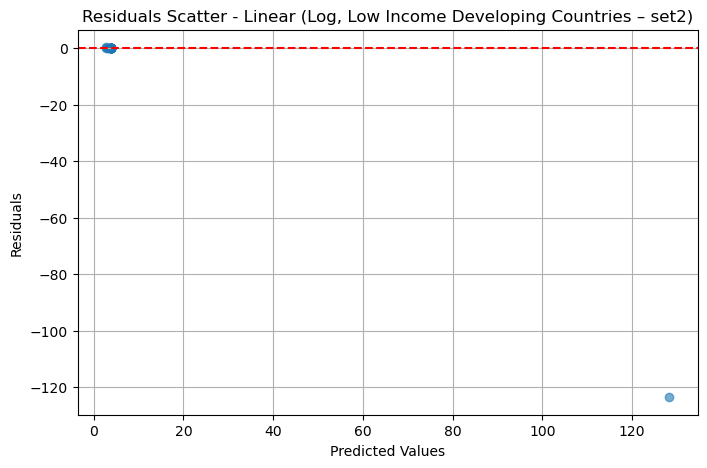

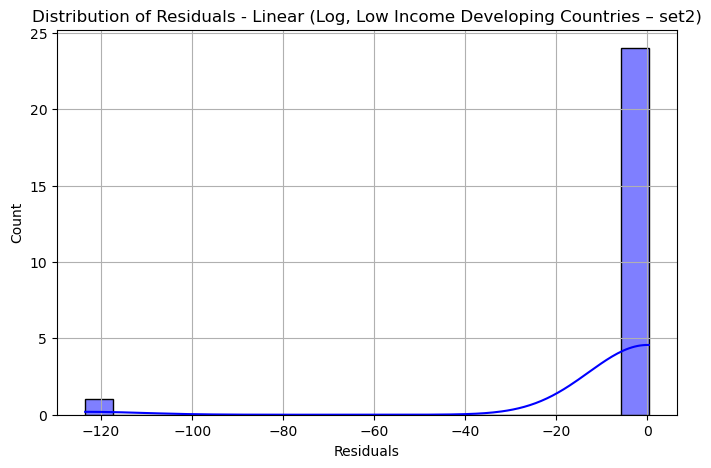

Randomforest Model Test Results:
 → Test MSE: 1.1708
 → Test R² : -55.7793

Fold 1: MSE=0.0000, R²=0.0000
Fold 2: MSE=0.0000, R²=0.0000
Fold 3: MSE=0.0000, R²=0.0000
Fold 4: MSE=0.0751, R²=-0.7205
Fold 5: MSE=0.5012, R²=0.0577

Average MSE: 0.1153
Average R² : -0.1326

Model does not support feature importances.


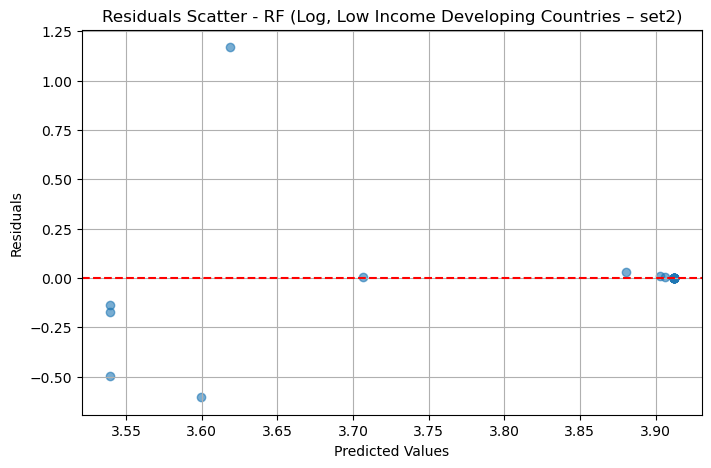

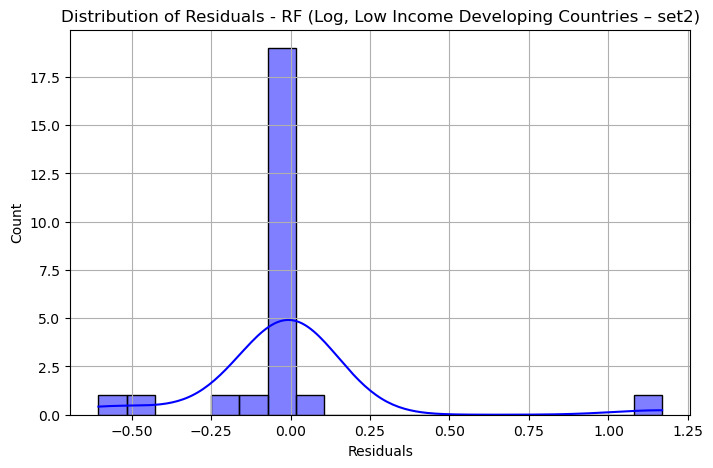


========== Emerging Market Economies – set2 – No Log Models ==========
Linear Model Test Results:
 → Test MSE: 52768.8475
 → Test R² : 0.5016

Fold 1: MSE=55048.8647, R²=0.8217
Fold 2: MSE=3209292.7040, R²=0.3024
Fold 3: MSE=224617.8956, R²=0.8156
Fold 4: MSE=19451.9317, R²=0.8861
Fold 5: MSE=6911.2147, R²=0.7786

Average MSE: 703064.5221
Average R² : 0.7209



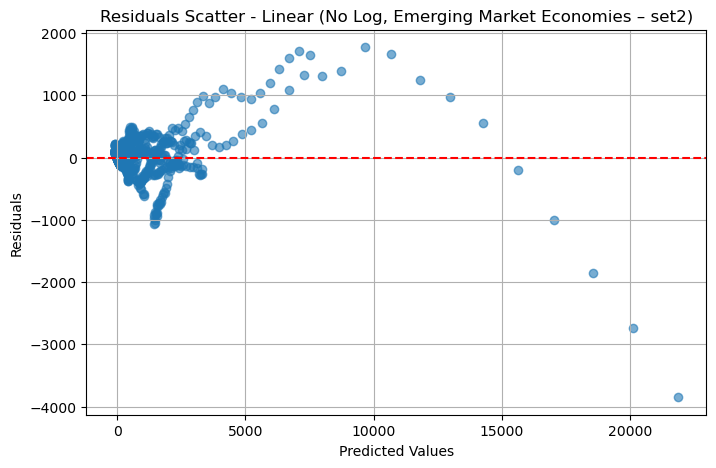

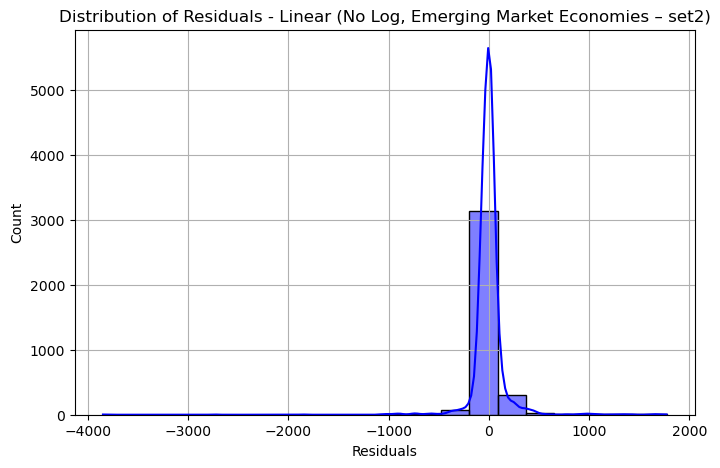

Randomforest Model Test Results:
 → Test MSE: 38630.6712
 → Test R² : 0.6351

Fold 1: MSE=139324.3071, R²=0.5488
Fold 2: MSE=3069789.3580, R²=0.3328
Fold 3: MSE=353986.3318, R²=0.7093
Fold 4: MSE=28621.9759, R²=0.8324
Fold 5: MSE=6761.6017, R²=0.7834

Average MSE: 719696.7149
Average R² : 0.6413

Model does not support feature importances.


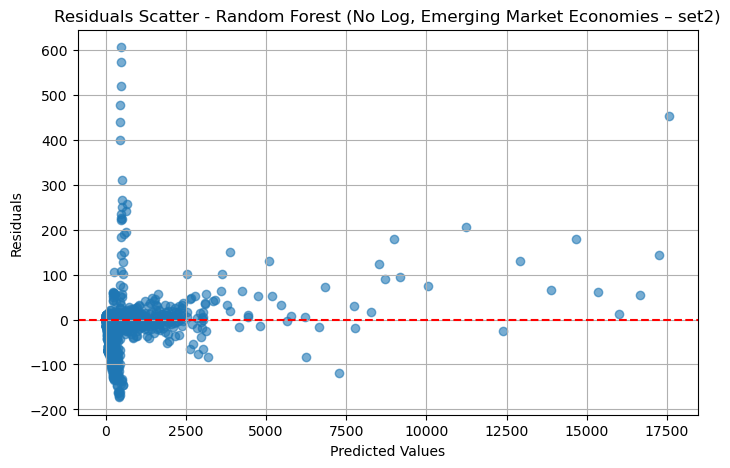

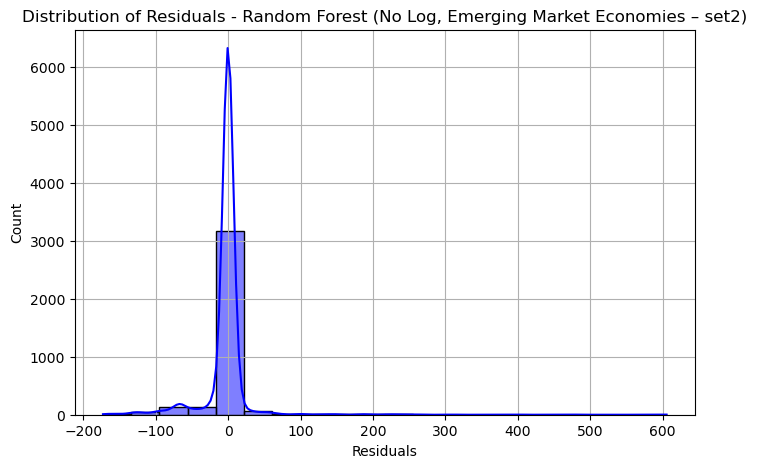


========== Emerging Market Economies – set2 – Log Models ==========
Linear Model Test Results:
 → Test MSE: 0.0984
 → Test R² : 0.8942

Fold 1: MSE=1.0767, R²=0.4081
Fold 2: MSE=0.0582, R²=0.9798
Fold 3: MSE=0.0583, R²=0.9031
Fold 4: MSE=0.2489, R²=0.6542
Fold 5: MSE=0.0547, R²=0.8124

Average MSE: 0.2994
Average R² : 0.7515



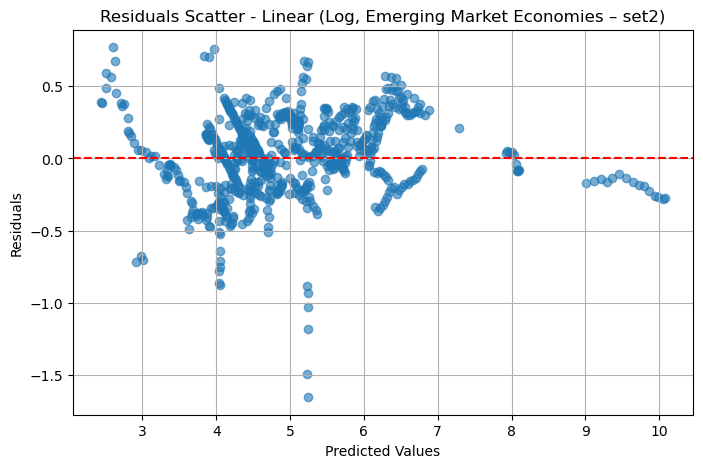

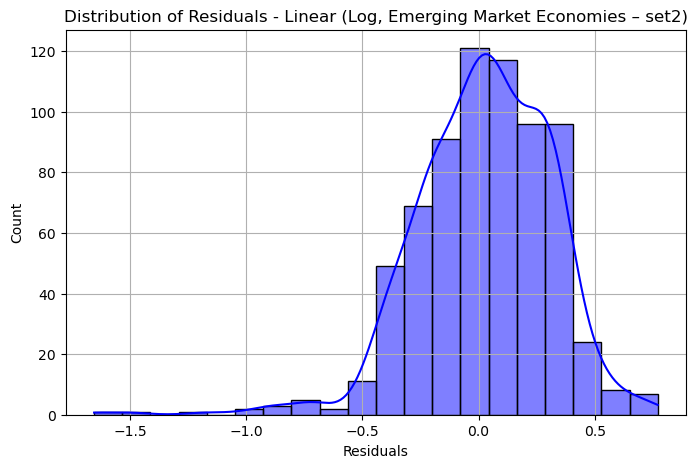

Randomforest Model Test Results:
 → Test MSE: 0.1423
 → Test R² : 0.8470

Fold 1: MSE=0.3684, R²=0.7975
Fold 2: MSE=0.6885, R²=0.7615
Fold 3: MSE=0.0923, R²=0.8466
Fold 4: MSE=0.4519, R²=0.3723
Fold 5: MSE=0.2945, R²=-0.0108

Average MSE: 0.3791
Average R² : 0.5534

Model does not support feature importances.


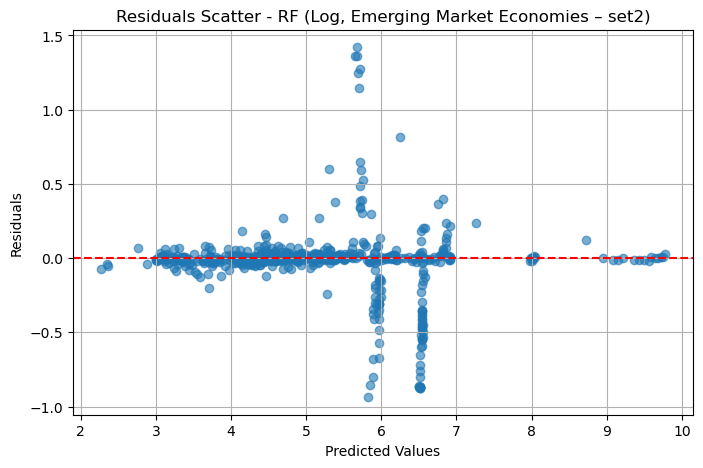

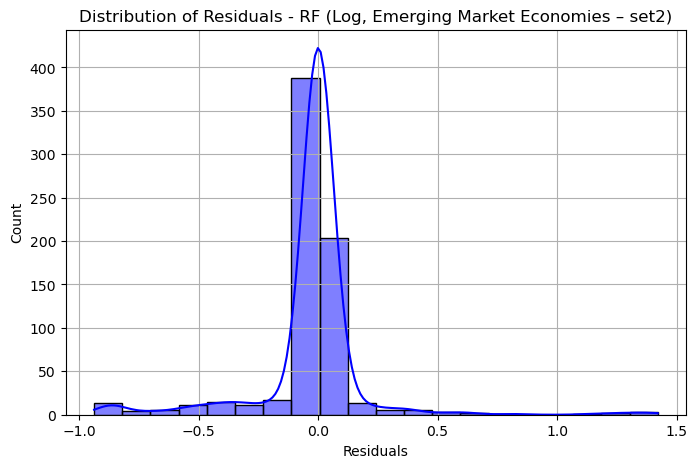


========== Advanced Economies – set2 – No Log Models ==========
Linear Model Test Results:
 → Test MSE: 1978670.4307
 → Test R² : 0.8899

Fold 1: MSE=3592.1788, R²=0.9806
Fold 2: MSE=19267.8745, R²=0.9890
Fold 3: MSE=145588.5000, R²=0.9396
Fold 4: MSE=2127.5812, R²=0.9673
Fold 5: MSE=850.2296, R²=0.9268

Average MSE: 34285.2728
Average R² : 0.9607



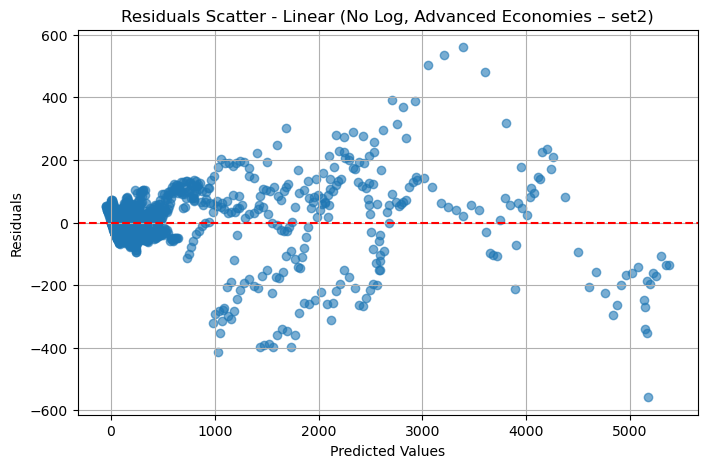

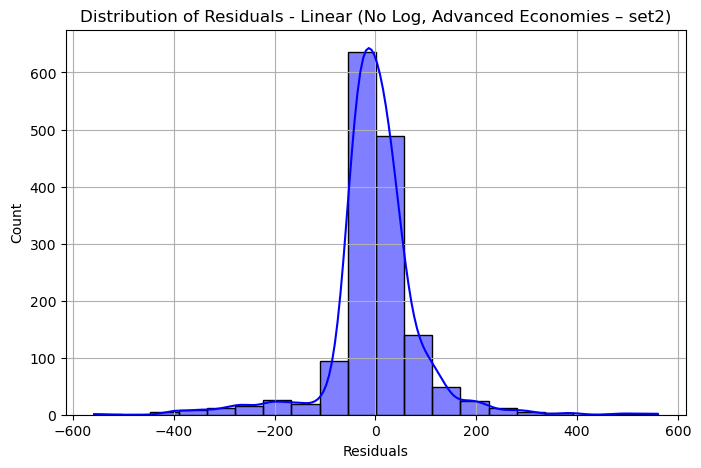

Randomforest Model Test Results:
 → Test MSE: 9726694.0311
 → Test R² : 0.4588

Fold 1: MSE=8129.7205, R²=0.9561
Fold 2: MSE=436034.3386, R²=0.7513
Fold 3: MSE=77063.1690, R²=0.9680
Fold 4: MSE=827.0485, R²=0.9873
Fold 5: MSE=1739.7138, R²=0.8503

Average MSE: 104758.7981
Average R² : 0.9026

Model does not support feature importances.


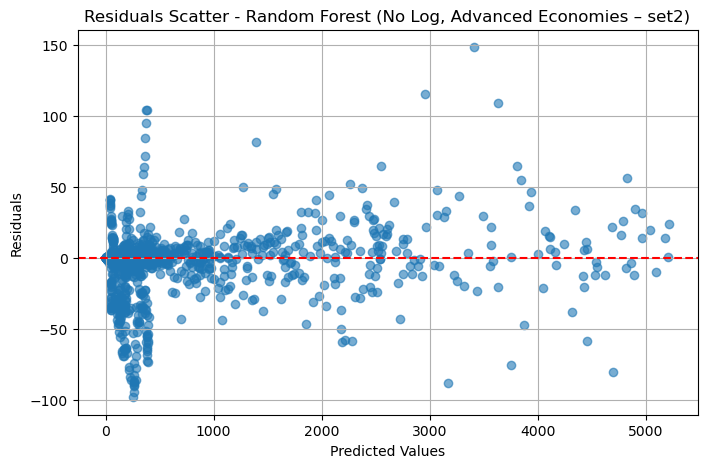

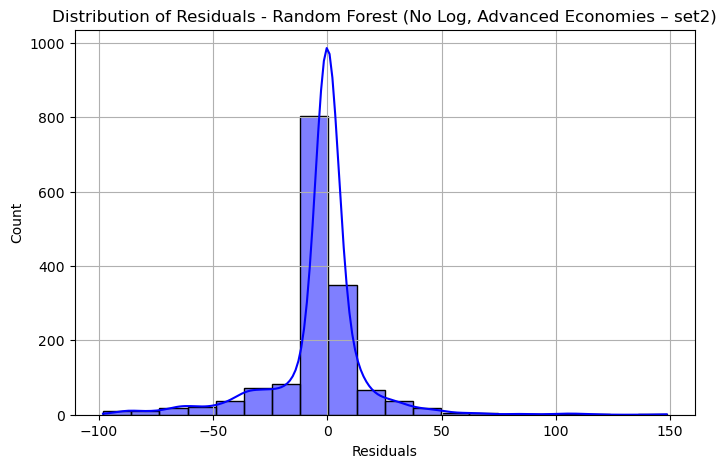


========== Advanced Economies – set2 – Log Models ==========
Linear Model Test Results:
 → Test MSE: 0.0462
 → Test R² : 0.9846

Fold 1: MSE=0.1615, R²=0.8946
Fold 2: MSE=0.1024, R²=0.9811
Fold 3: MSE=0.1814, R²=0.9350
Fold 4: MSE=0.1701, R²=0.8678
Fold 5: MSE=0.0413, R²=0.9244

Average MSE: 0.1313
Average R² : 0.9206



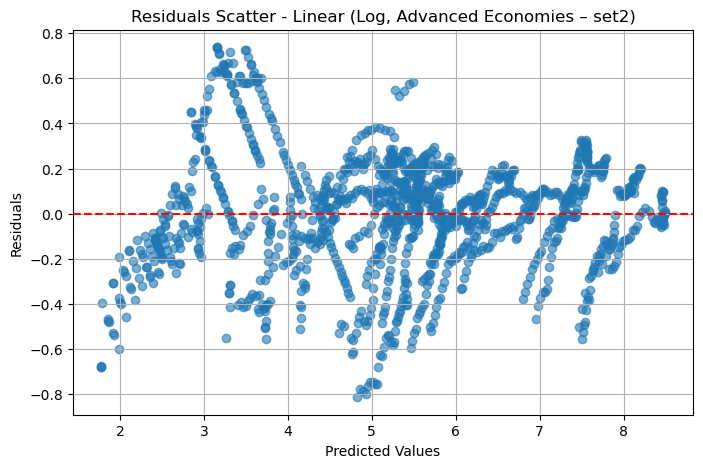

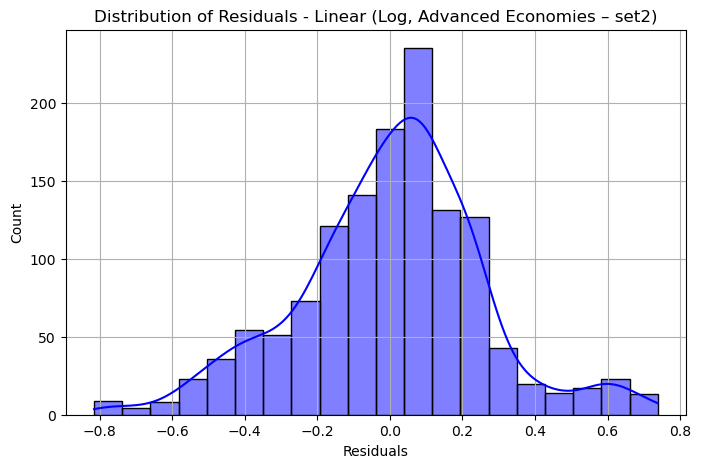

Randomforest Model Test Results:
 → Test MSE: 0.1783
 → Test R² : 0.9406

Fold 1: MSE=1.1205, R²=0.2688
Fold 2: MSE=0.7593, R²=0.8599
Fold 3: MSE=0.1322, R²=0.9526
Fold 4: MSE=0.2497, R²=0.8058
Fold 5: MSE=0.0559, R²=0.8978

Average MSE: 0.4635
Average R² : 0.7570

Model does not support feature importances.


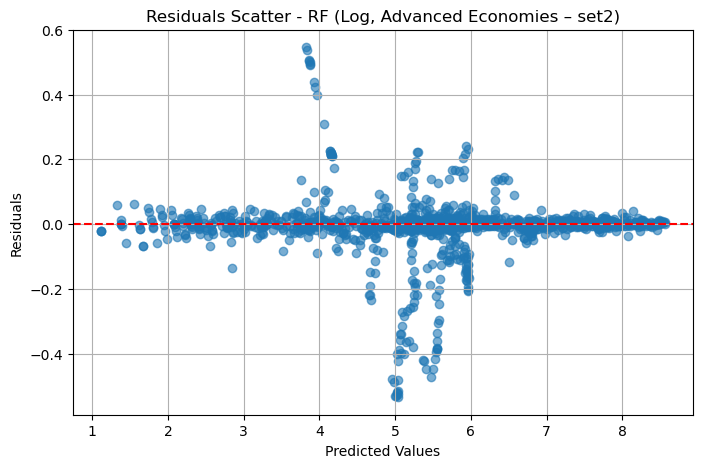

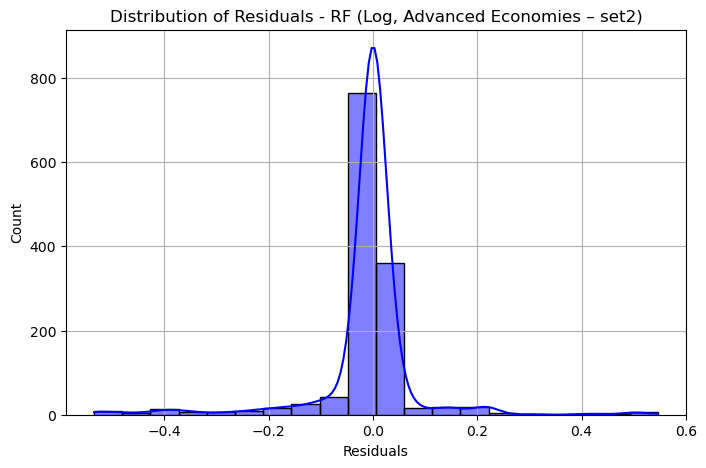


========== Low Income Developing Countries – set3 – No Log Models ==========
Linear Model Test Results:
 → Test MSE: 4343.6294
 → Test R² : 0.4226

Fold 1: MSE=316.0769, R²=0.0283
Fold 2: MSE=242.3379, R²=0.8244
Fold 3: MSE=275.7884, R²=0.7824
Fold 4: MSE=239.9876, R²=0.8413
Fold 5: MSE=8722.3801, R²=0.7270

Average MSE: 1959.3142
Average R² : 0.6407



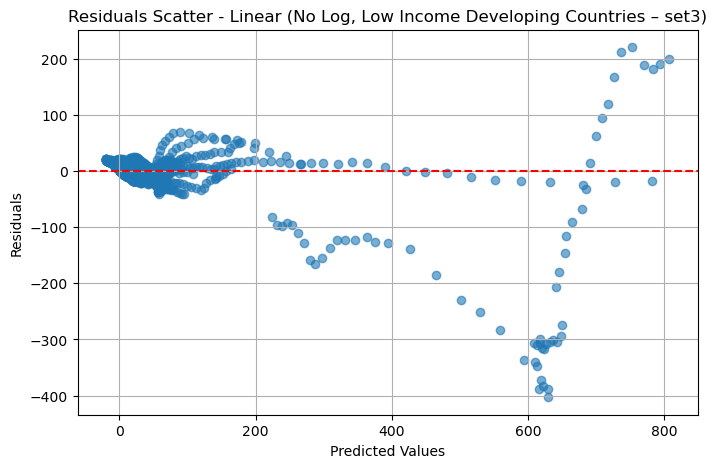

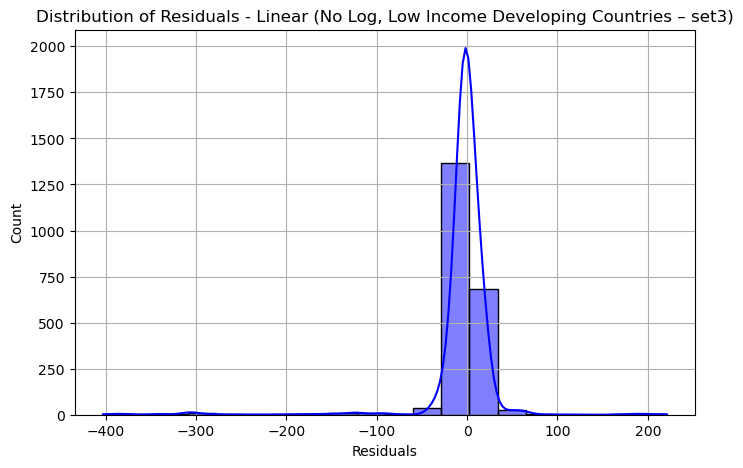

Randomforest Model Test Results:
 → Test MSE: 3014.3505
 → Test R² : 0.5993

Fold 1: MSE=67.7586, R²=0.7917
Fold 2: MSE=119.4807, R²=0.9134
Fold 3: MSE=281.1174, R²=0.7782
Fold 4: MSE=239.3779, R²=0.8417
Fold 5: MSE=5842.4053, R²=0.8171

Average MSE: 1310.0280
Average R² : 0.8284

Model does not support feature importances.


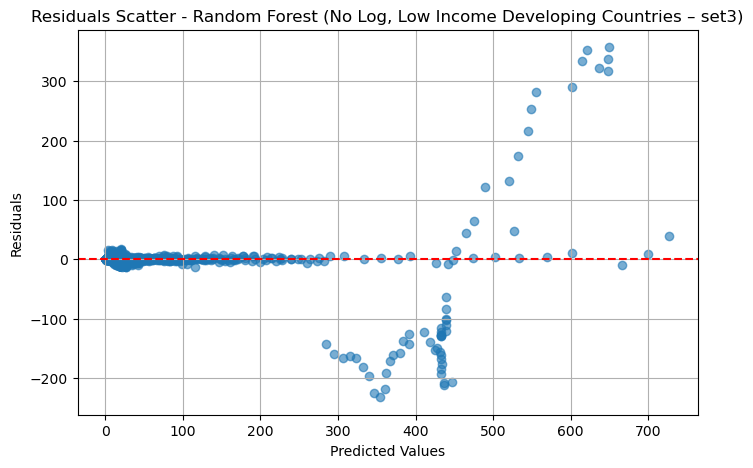

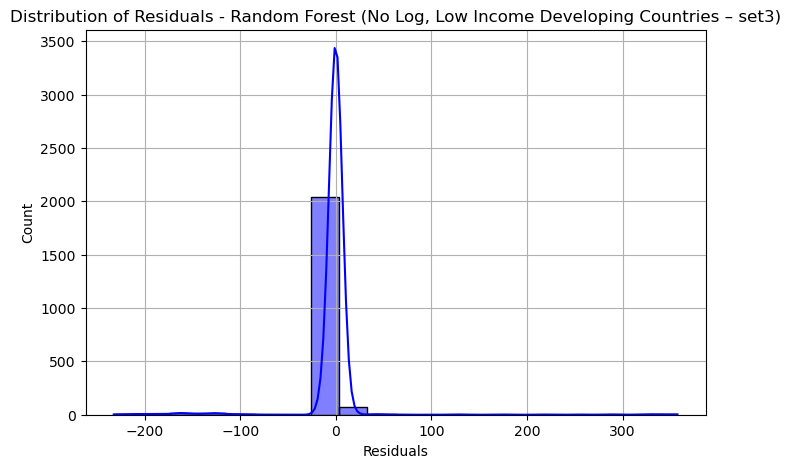


========== Low Income Developing Countries – set3 – Log Models ==========
Skipping Log Models for Low Income Developing Countries – set3: only 0 rows after log → need ≥ 2.

========== Emerging Market Economies – set3 – No Log Models ==========
Linear Model Test Results:
 → Test MSE: 54826.8915
 → Test R² : 0.4821

Fold 1: MSE=62535.2083, R²=0.7975
Fold 2: MSE=2650346.8430, R²=0.4239
Fold 3: MSE=234079.0281, R²=0.8078
Fold 4: MSE=18484.9481, R²=0.8917
Fold 5: MSE=7186.8613, R²=0.7697

Average MSE: 594526.5778
Average R² : 0.7381



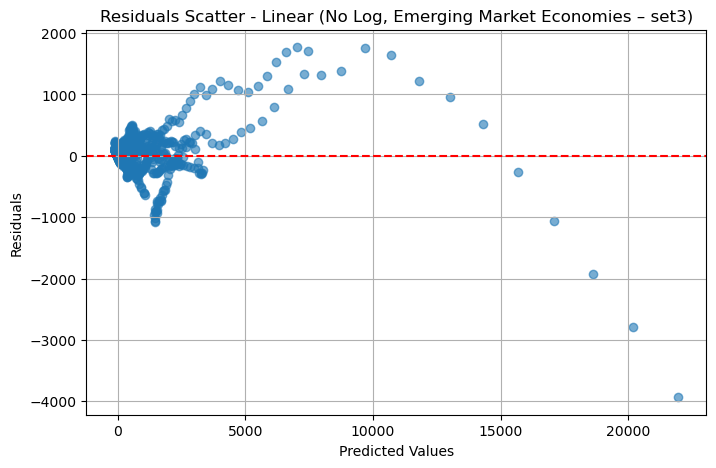

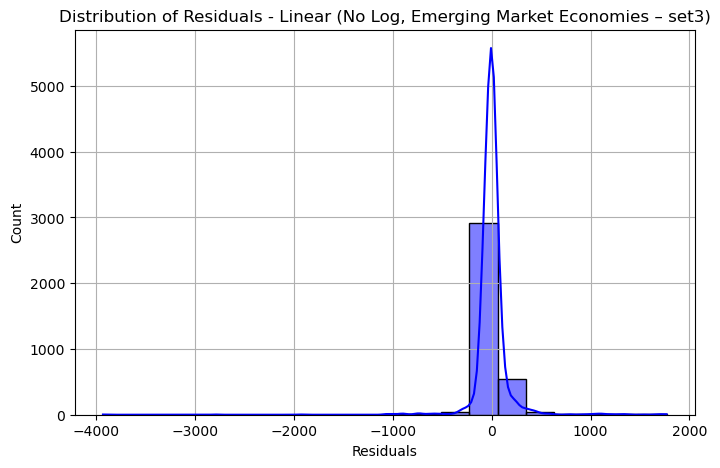

Randomforest Model Test Results:
 → Test MSE: 35895.4626
 → Test R² : 0.6609

Fold 1: MSE=145490.1000, R²=0.5288
Fold 2: MSE=3037988.2123, R²=0.3397
Fold 3: MSE=354842.8788, R²=0.7086
Fold 4: MSE=31652.5067, R²=0.8146
Fold 5: MSE=7666.5879, R²=0.7544

Average MSE: 715528.0571
Average R² : 0.6292

Model does not support feature importances.


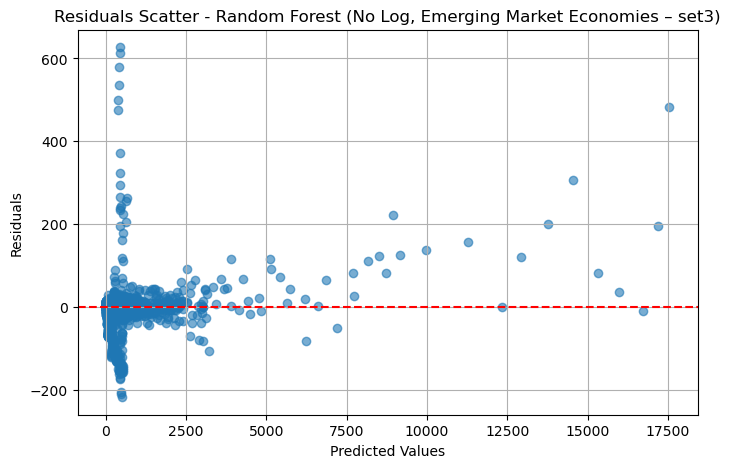

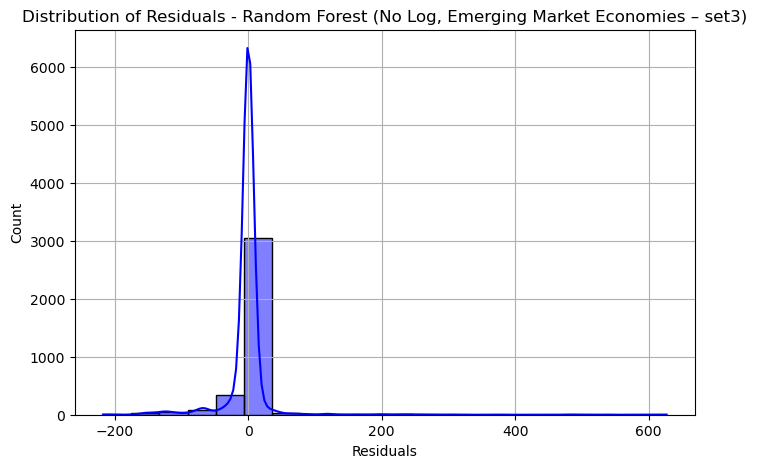


========== Emerging Market Economies – set3 – Log Models ==========
Linear Model Test Results:
 → Test MSE: 0.3158
 → Test R² : -1.7948

Fold 1: MSE=0.9956, R²=0.7047
Fold 2: MSE=0.7026, R²=-2.3265
Fold 3: MSE=0.0119, R²=0.6696
Fold 4: MSE=0.0458, R²=0.6277
Fold 5: MSE=0.1602, R²=-2.1125

Average MSE: 0.3832
Average R² : -0.4874



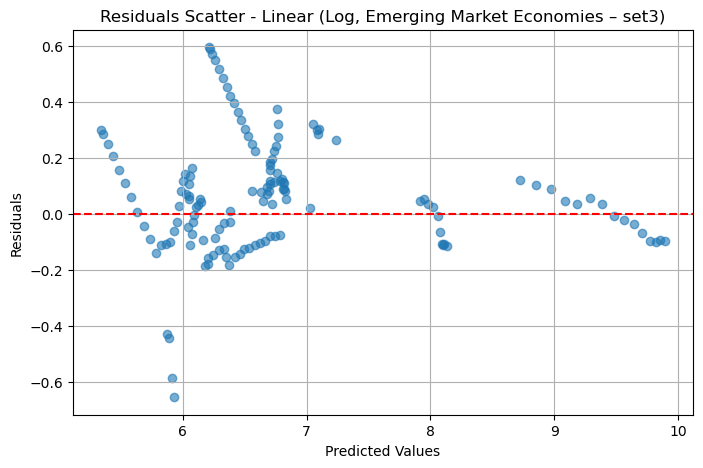

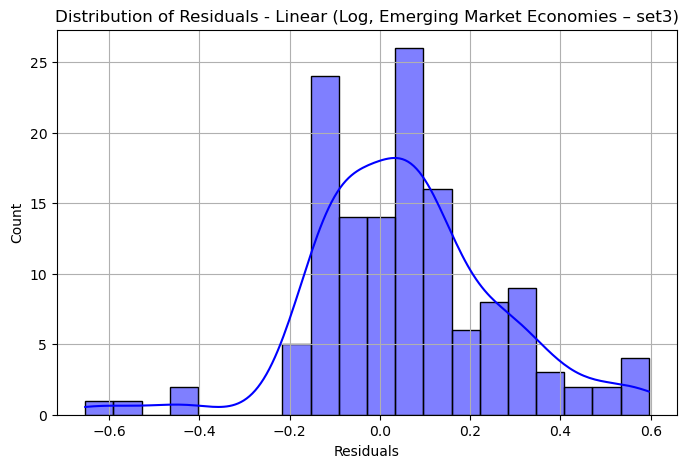

Randomforest Model Test Results:
 → Test MSE: 0.4928
 → Test R² : -3.3614

Fold 1: MSE=0.8324, R²=0.7531
Fold 2: MSE=0.4887, R²=-1.3140
Fold 3: MSE=0.0199, R²=0.4460
Fold 4: MSE=0.0300, R²=0.7559
Fold 5: MSE=0.1036, R²=-1.0125

Average MSE: 0.2949
Average R² : -0.0743

Model does not support feature importances.


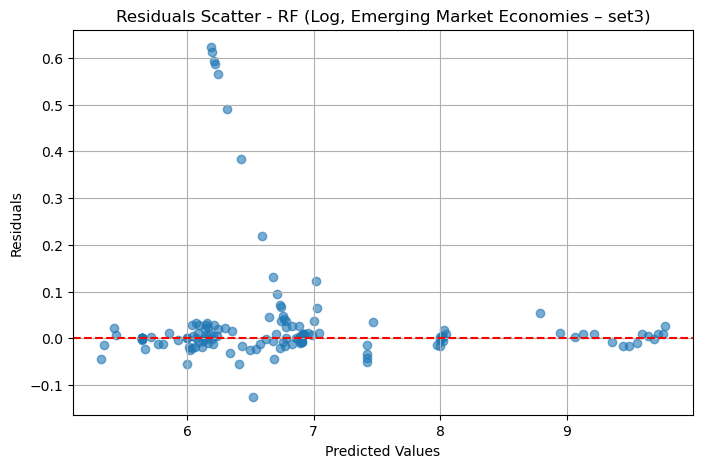

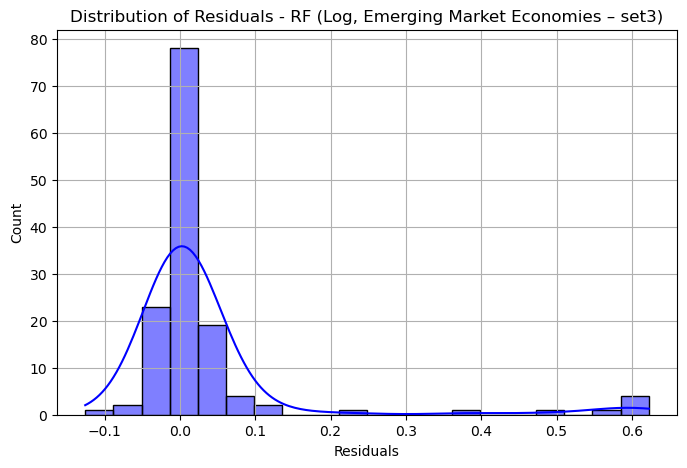


========== Advanced Economies – set3 – No Log Models ==========
Linear Model Test Results:
 → Test MSE: 2198057.5478
 → Test R² : 0.8777

Fold 1: MSE=7759.2282, R²=0.9581
Fold 2: MSE=23683.9314, R²=0.9865
Fold 3: MSE=167066.3840, R²=0.9307
Fold 4: MSE=2543.9919, R²=0.9609
Fold 5: MSE=2692.4379, R²=0.7683

Average MSE: 40749.1947
Average R² : 0.9209



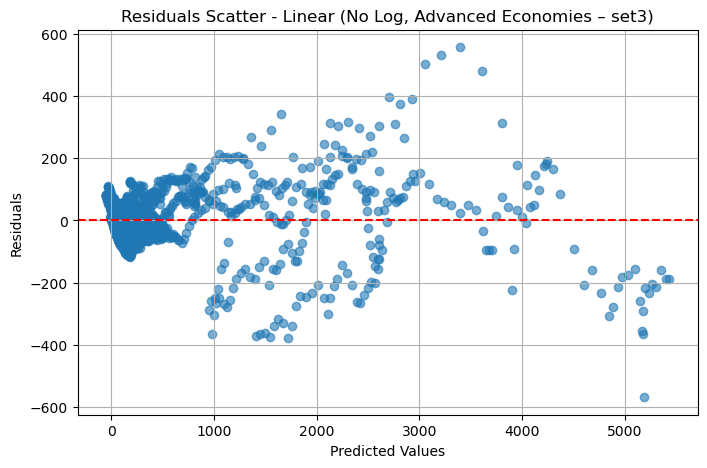

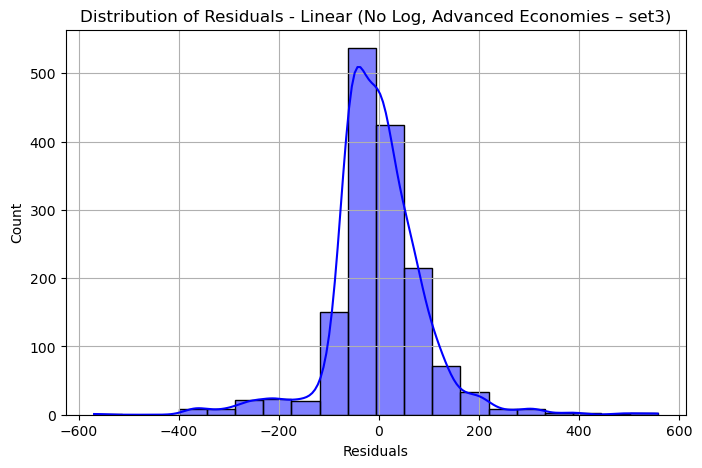

Randomforest Model Test Results:
 → Test MSE: 9603877.8661
 → Test R² : 0.4657

Fold 1: MSE=11253.1629, R²=0.9393
Fold 2: MSE=437514.1661, R²=0.7504
Fold 3: MSE=70288.1406, R²=0.9709
Fold 4: MSE=1084.4526, R²=0.9833
Fold 5: MSE=2285.4676, R²=0.8033

Average MSE: 104485.0779
Average R² : 0.8894

Model does not support feature importances.


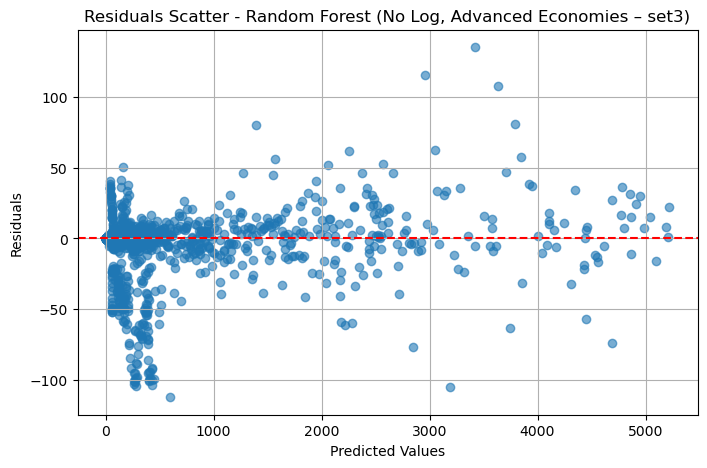

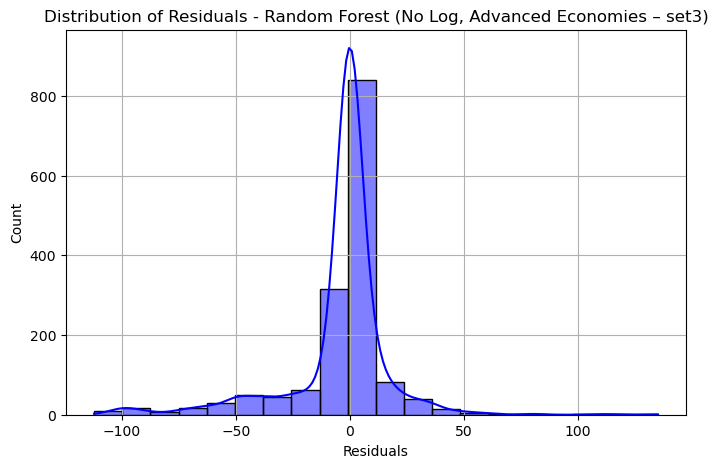


========== Advanced Economies – set3 – Log Models ==========
Linear Model Test Results:
 → Test MSE: 0.1501
 → Test R² : 0.7755

Fold 1: MSE=0.4618, R²=-2.7648
Fold 2: MSE=0.0117, R²=0.9086
Fold 3: MSE=0.0187, R²=0.9262
Fold 4: MSE=0.0666, R²=0.6979
Fold 5: MSE=0.0074, R²=0.9212

Average MSE: 0.1132
Average R² : 0.1378



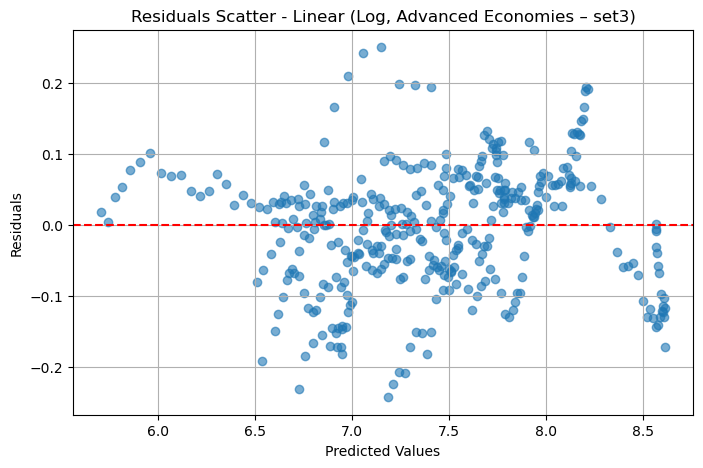

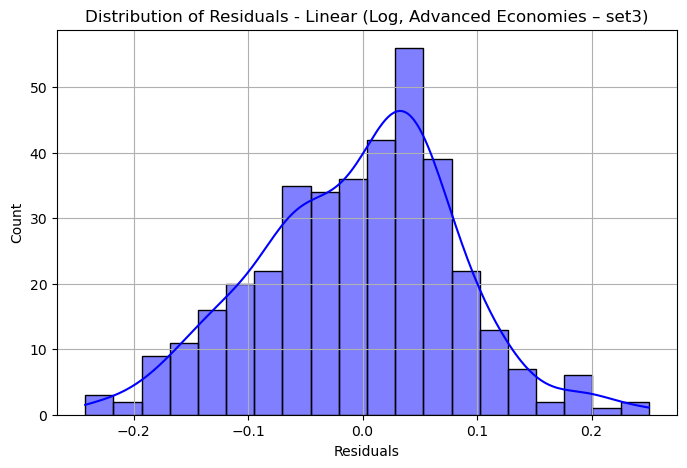

Randomforest Model Test Results:
 → Test MSE: 0.4817
 → Test R² : 0.2794

Fold 1: MSE=0.5472, R²=-3.4611
Fold 2: MSE=0.0392, R²=0.6940
Fold 3: MSE=0.0275, R²=0.8914
Fold 4: MSE=0.0232, R²=0.8947
Fold 5: MSE=0.0120, R²=0.8724

Average MSE: 0.1298
Average R² : -0.0217

Model does not support feature importances.


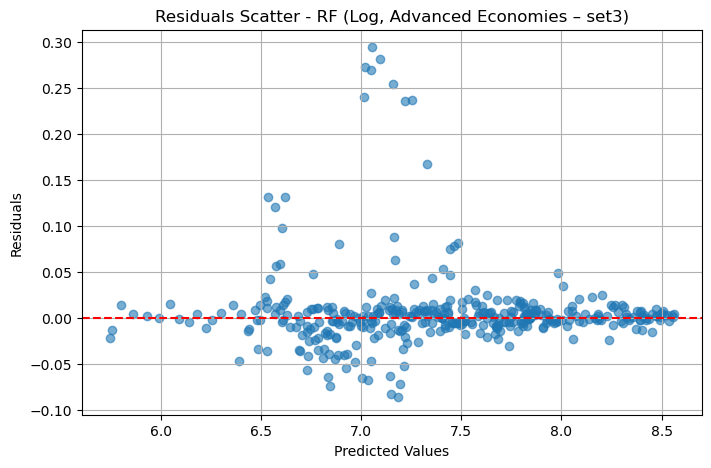

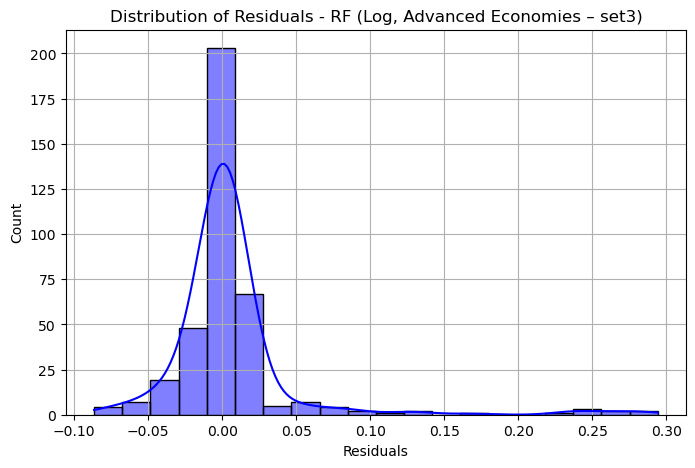


========== Low Income Developing Countries – set4 – No Log Models ==========
Linear Model Test Results:
 → Test MSE: 5226.8323
 → Test R² : 0.3052

Fold 1: MSE=978.7354, R²=-2.0088
Fold 2: MSE=126.0547, R²=0.9087
Fold 3: MSE=442.7403, R²=0.6506
Fold 4: MSE=292.5088, R²=0.8065
Fold 5: MSE=11110.7056, R²=0.6522

Average MSE: 2590.1489
Average R² : 0.2019



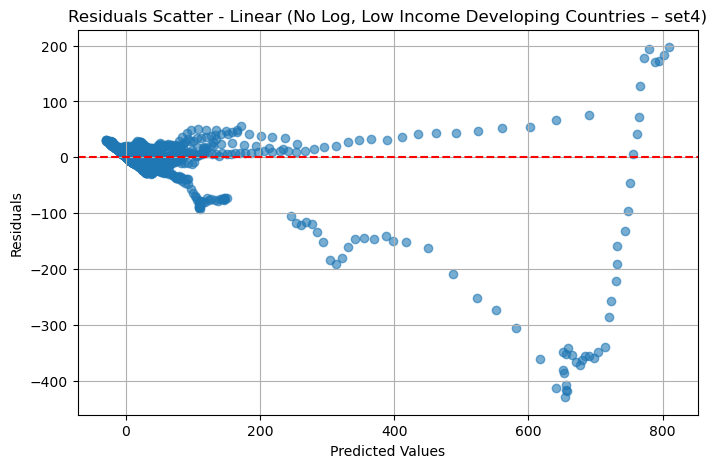

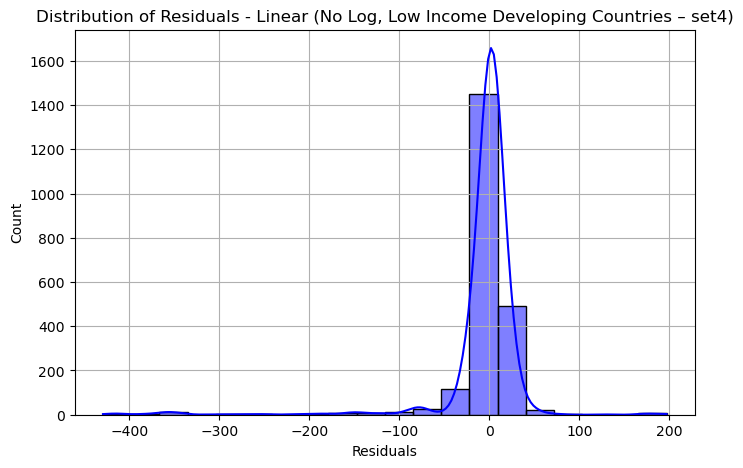

Randomforest Model Test Results:
 → Test MSE: 4916.9247
 → Test R² : 0.3464

Fold 1: MSE=94.6241, R²=0.7091
Fold 2: MSE=182.2594, R²=0.8679
Fold 3: MSE=981.3294, R²=0.2257
Fold 4: MSE=224.9941, R²=0.8512
Fold 5: MSE=4470.7832, R²=0.8601

Average MSE: 1190.7980
Average R² : 0.7028

Model does not support feature importances.


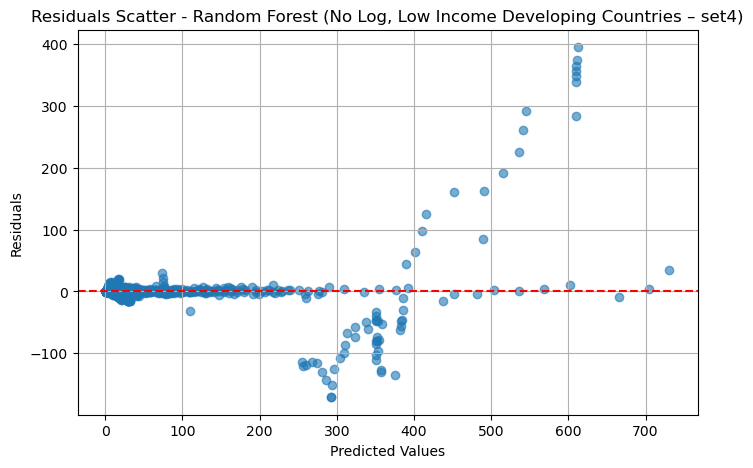

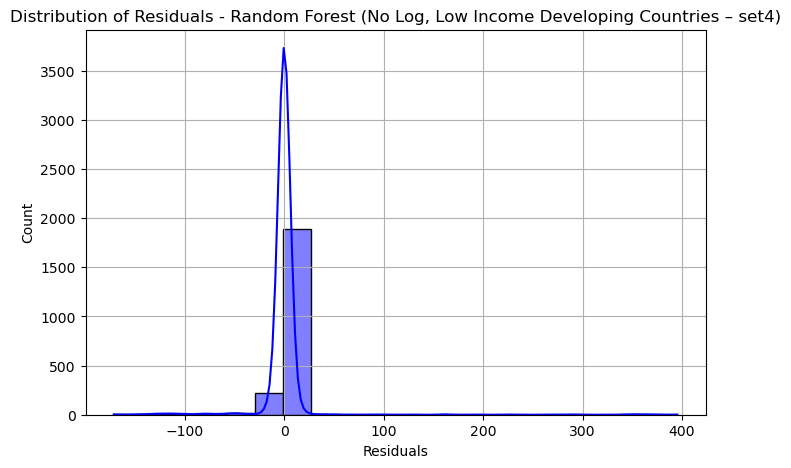


========== Low Income Developing Countries – set4 – Log Models ==========
Skipping Log Models for Low Income Developing Countries – set4: only 0 rows after log → need ≥ 2.

========== Emerging Market Economies – set4 – No Log Models ==========
Linear Model Test Results:
 → Test MSE: 41986.8420
 → Test R² : 0.6034

Fold 1: MSE=155298.6310, R²=0.4970
Fold 2: MSE=260822.6787, R²=0.9433
Fold 3: MSE=126848.5760, R²=0.8958
Fold 4: MSE=29712.4227, R²=0.8260
Fold 5: MSE=9844.9141, R²=0.6846

Average MSE: 116505.4445
Average R² : 0.7693



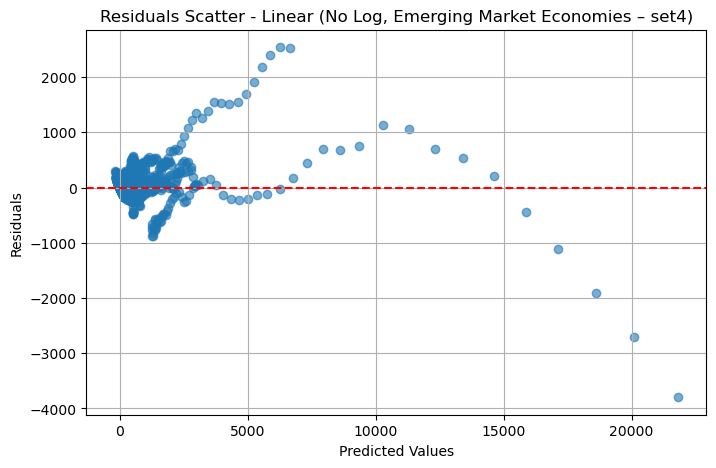

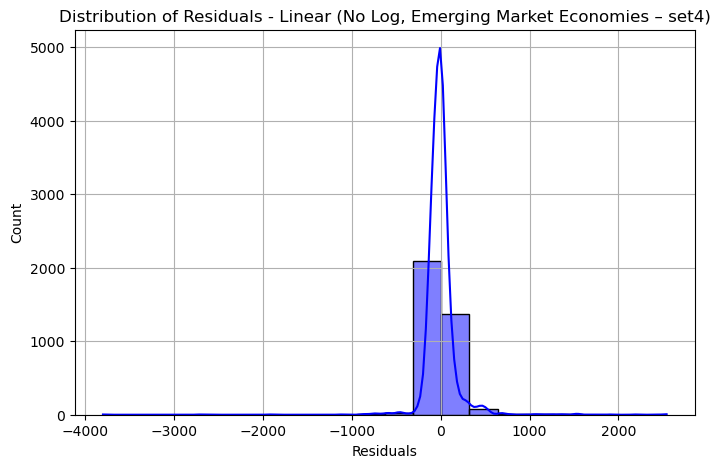

Randomforest Model Test Results:
 → Test MSE: 57446.8700
 → Test R² : 0.4574

Fold 1: MSE=164832.0327, R²=0.4662
Fold 2: MSE=2915893.2023, R²=0.3662
Fold 3: MSE=227365.2591, R²=0.8133
Fold 4: MSE=31924.7601, R²=0.8130
Fold 5: MSE=4882.7291, R²=0.8436

Average MSE: 668979.5967
Average R² : 0.6605

Model does not support feature importances.


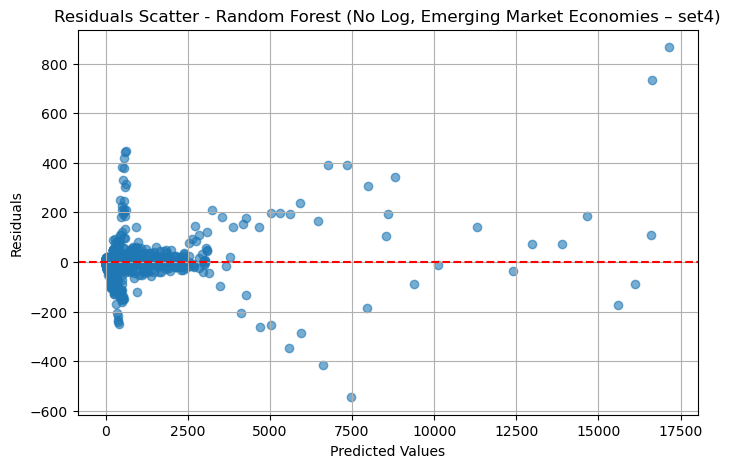

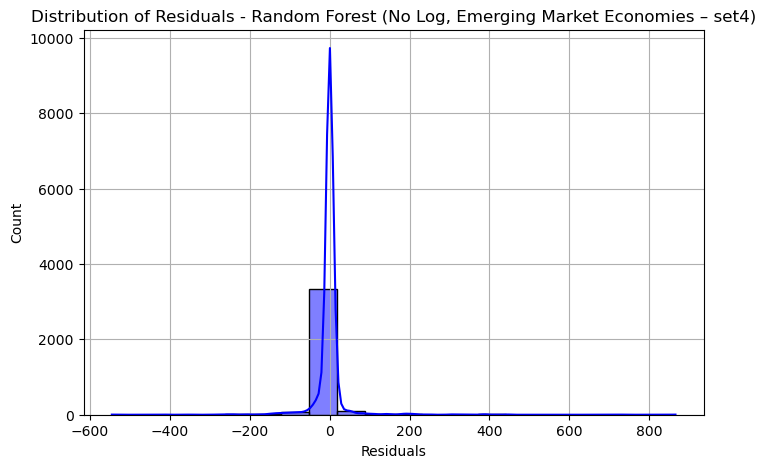


========== Emerging Market Economies – set4 – Log Models ==========
Linear Model Test Results:
 → Test MSE: 0.3843
 → Test R² : -2.9855

Fold 1: MSE=3.0389, R²=-8.1696
Fold 2: MSE=0.2064, R²=0.9313
Fold 3: MSE=0.1219, R²=-0.8467
Fold 4: MSE=0.2099, R²=-3.8089
Fold 5: MSE=0.0252, R²=-3545833064498282324260028416.0000

Average MSE: 0.7205
Average R² : -709166612899656519827587072.0000



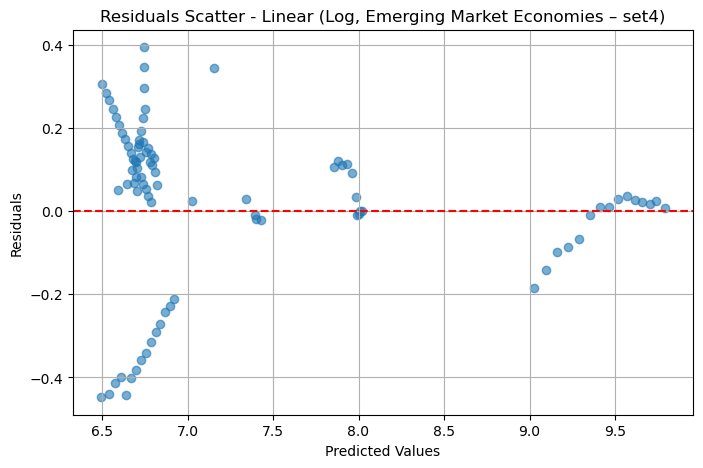

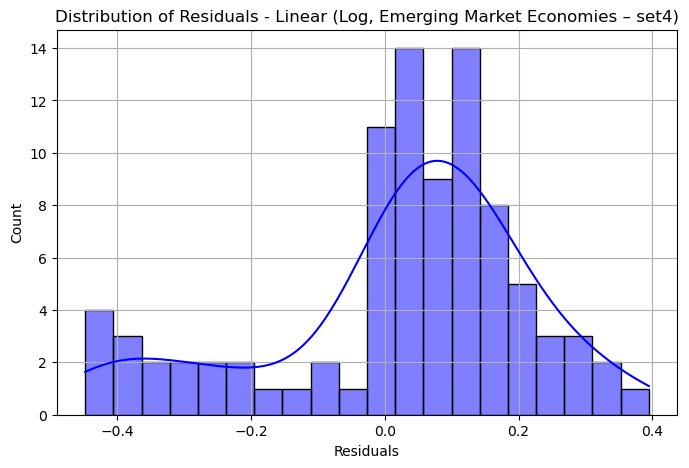

Randomforest Model Test Results:
 → Test MSE: 0.3615
 → Test R² : -2.7483

Fold 1: MSE=1.4280, R²=-3.3090
Fold 2: MSE=0.4068, R²=0.8646
Fold 3: MSE=0.1178, R²=-0.7851
Fold 4: MSE=0.1435, R²=-2.2871
Fold 5: MSE=0.0016, R²=-228212662779801294782595072.0000

Average MSE: 0.4195
Average R² : -45642532555960257238532096.0000

Model does not support feature importances.


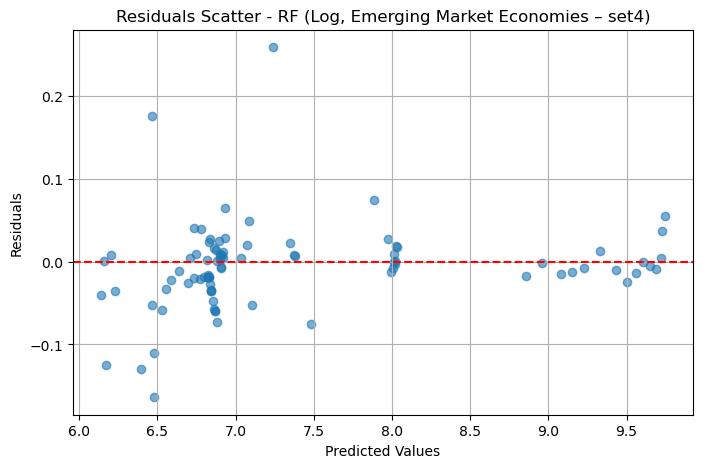

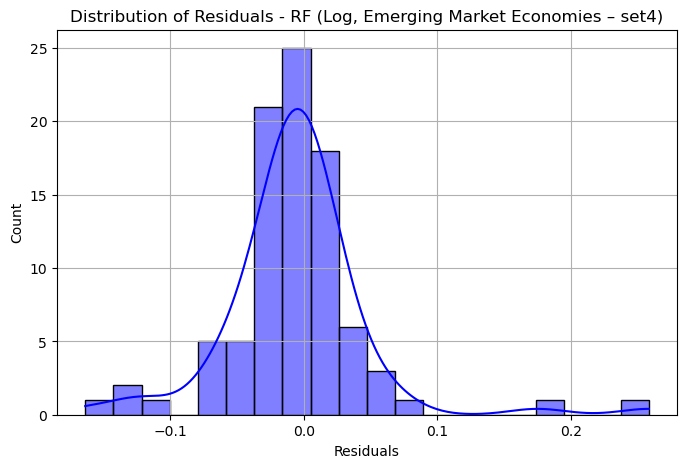


========== Advanced Economies – set4 – No Log Models ==========
Linear Model Test Results:
 → Test MSE: 772754.3606
 → Test R² : 0.9570

Fold 1: MSE=61953.0573, R²=0.6657
Fold 2: MSE=219988.7170, R²=0.8745
Fold 3: MSE=1419494.0834, R²=0.4115
Fold 4: MSE=26417.5535, R²=0.5937
Fold 5: MSE=16396.6247, R²=-0.4112

Average MSE: 348850.0072
Average R² : 0.4268



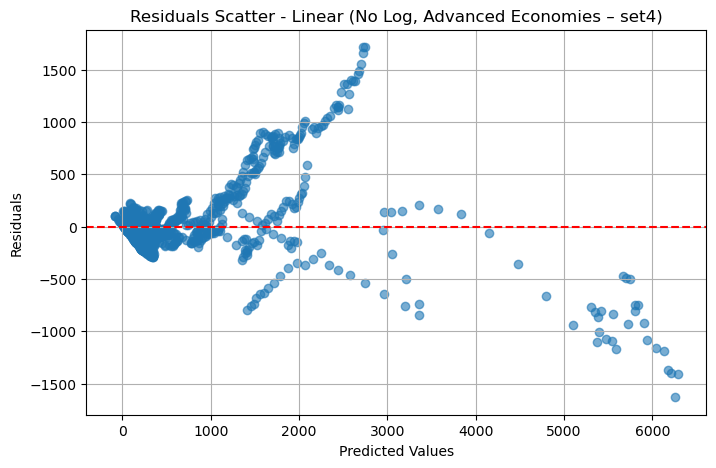

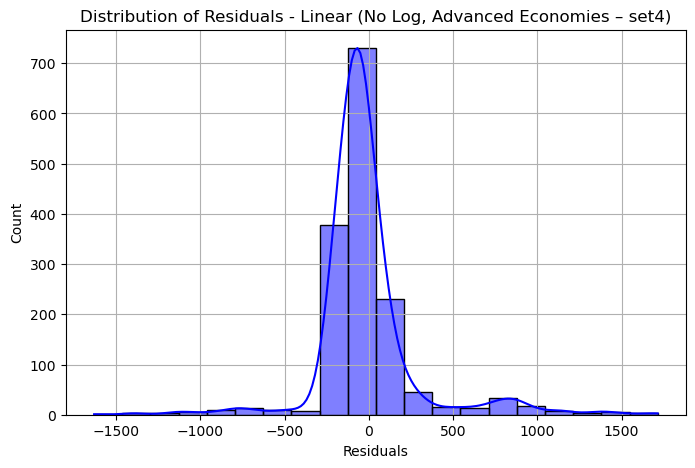

Randomforest Model Test Results:
 → Test MSE: 9519671.4333
 → Test R² : 0.4704

Fold 1: MSE=14061.7739, R²=0.9241
Fold 2: MSE=480679.9151, R²=0.7258
Fold 3: MSE=146331.8107, R²=0.9393
Fold 4: MSE=5920.5478, R²=0.9089
Fold 5: MSE=5030.5745, R²=0.5670

Average MSE: 130404.9244
Average R² : 0.8130

Model does not support feature importances.


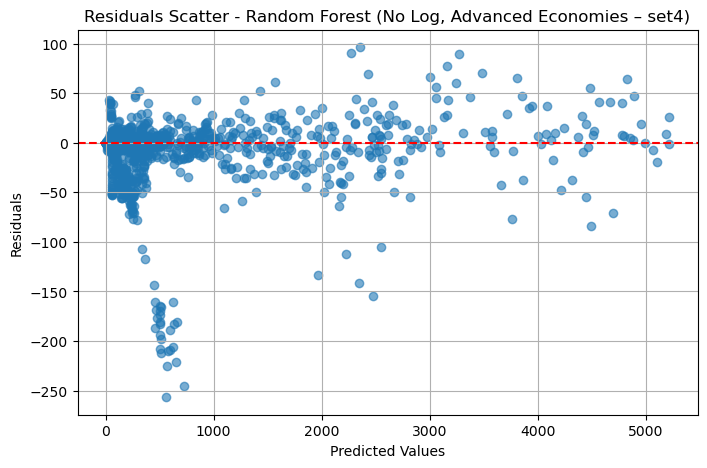

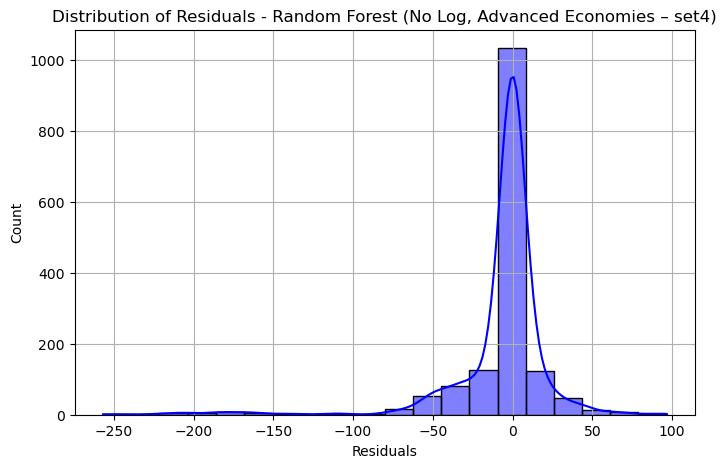


========== Advanced Economies – set4 – Log Models ==========
Linear Model Test Results:
 → Test MSE: 0.0570
 → Test R² : 0.9148

Fold 1: MSE=0.4486, R²=-1.9489
Fold 2: MSE=0.2069, R²=-0.3818
Fold 3: MSE=0.0316, R²=0.8488
Fold 4: MSE=0.4599, R²=-0.1893
Fold 5: MSE=0.0094, R²=0.9005

Average MSE: 0.2313
Average R² : -0.1541



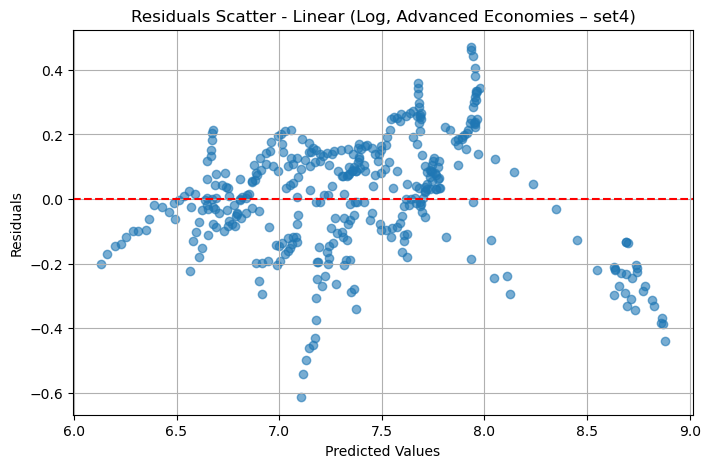

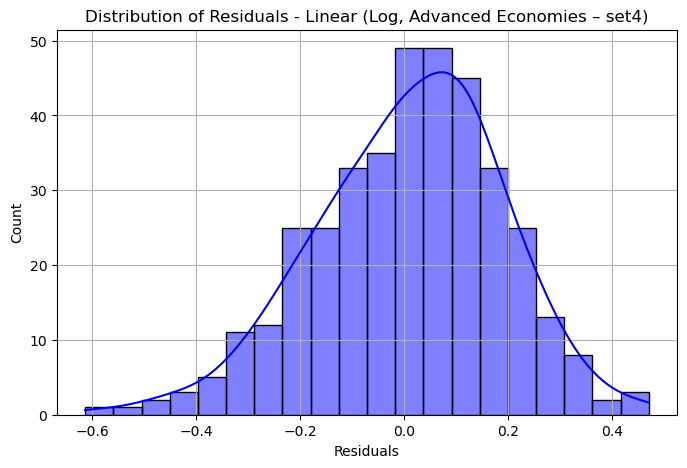

Randomforest Model Test Results:
 → Test MSE: 0.4707
 → Test R² : 0.2959

Fold 1: MSE=0.7337, R²=-3.8233
Fold 2: MSE=0.0624, R²=0.5833
Fold 3: MSE=0.0385, R²=0.8158
Fold 4: MSE=0.0461, R²=0.8807
Fold 5: MSE=0.0681, R²=0.2766

Average MSE: 0.1898
Average R² : -0.2534

Model does not support feature importances.


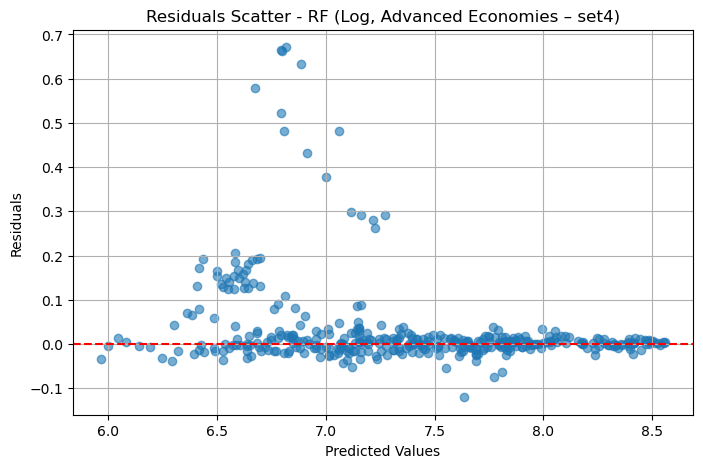

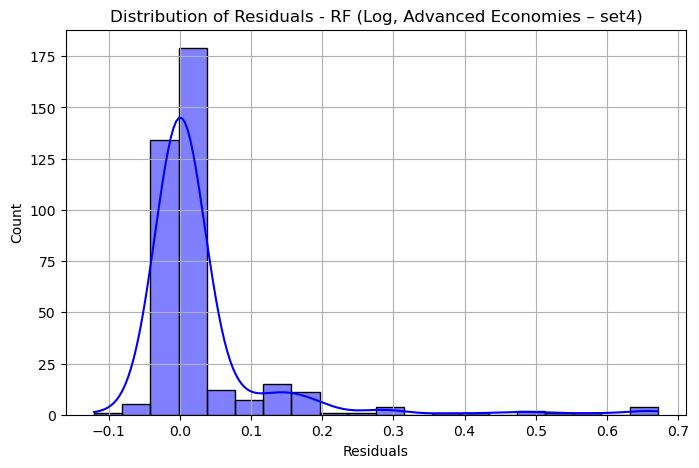

In [59]:
# Loop over all feature sets; produce for each income_group

#  By income_group panels
for set_name, feat in features_sets.items():
    for grp, df_grp in panel_1_groups.items():
        all_results += evaluate_dataset(
            df_grp.reset_index(),
            dataset_label=f"{grp} – {set_name}",
            features=feat,
            features_to_log=feat,
            is_panel=False
        )


In [60]:
#  Consolidate results into a DataFrame
df_results = pd.DataFrame(all_results)
display(df_results.sort_values(['Dataset','Model']).reset_index(drop=True))


Dataset                   Model       MSE  \
0                Advanced Economies – set1            Linear (Log)      0.18   
1                Advanced Economies – set1         Linear (No Log)  36470.54   
2                Advanced Economies – set1     Random Forest (Log)      0.56   
3                Advanced Economies – set1  Random Forest (No Log) 107657.30   
4                Advanced Economies – set2            Linear (Log)      0.13   
5                Advanced Economies – set2         Linear (No Log)  34285.27   
6                Advanced Economies – set2     Random Forest (Log)      0.46   
7                Advanced Economies – set2  Random Forest (No Log) 104758.80   
8                Advanced Economies – set3            Linear (Log)      0.11   
9                Advanced Economies – set3         Linear (No Log)  40749.19   
10               Advanced Economies – set3     Random Forest (Log)      0.13   
11               Advanced Economies – set3  Random Forest (No Log) 104485.08   
12               Advanced Economies – set4            Linear (Log)      0.23   
13               Advanced Economies – set4         Linear (No Log) 348850.01   
14               Advanced Economies – set4     Random Forest (Log)      0.19   
15               Advanced Economies – set4  Random Forest (No Log) 130404.92   
16        Emerging Market Economies – set1            Linear (Log)      0.15   
17        Emerging Market Economies – set1         Linear (No Log) 711068.17   
18        Emerging Market Economies – set1     Random Forest (Log)      0.31   
19        Emerging Market Economies – set1  Random Forest (No Log) 692911.54   
20        Emerging Market Economies – set2            Linear (Log)      0.30   
21        Emerging Market Economies – set2         Linear (No Log) 703064.52   
22        Emerging Market Economies – set2     Random Forest (Log)      0.38   
23        Emerging Market Economies – set2  Random Forest (No Log) 719696.71   
24        Emerging Market Economies – set3            Linear (Log)      0.38   
25        Emerging Market Economies – set3         Linear (No Log) 594526.58   
26        Emerging Market Economies – set3     Random Forest (Log)      0.29   
27        Emerging Market Economies – set3  Random Forest (No Log) 715528.06   
28        Emerging Market Economies – set4            Linear (Log)      0.72   
29        Emerging Market Economies – set4         Linear (No Log) 116505.44   
30        Emerging Market Economies – set4     Random Forest (Log)      0.42   
31        Emerging Market Economies – set4  Random Forest (No Log) 668979.60   
32                             Full – set1            Linear (Log)      0.14   
33                             Full – set1         Linear (No Log)  70030.87   
34                             Full – set1     Random Forest (Log)      0.25   
35                             Full – set1  Random Forest (No Log) 457934.15   
36                             Full – set2            Linear (Log)      0.11   
37                             Full – set2         Linear (No Log)  65333.62   
38                             Full – set2     Random Forest (Log)      0.22   
39                             Full – set2  Random Forest (No Log) 454810.76   
40                             Full – set3            Linear (Log)      0.28   
41                             Full – set3         Linear (No Log)  75121.48   
42                             Full – set3     Random Forest (Log)      0.23   
43                             Full – set3  Random Forest (No Log) 458742.07   
44                             Full – set4            Linear (Log)      0.14   
45                             Full – set4         Linear (No Log) 106208.66   
46                             Full – set4     Random Forest (Log)      0.34   
47                             Full – set4  Random Forest (No Log) 541577.38   
48  Low Income Developing Countries – set1            Linear (Log)      0.33   
49  Low Income Developing Countries

In [61]:

# 1. Drop exact duplicates and make a true copy
df_clean = (
    df_results
    .drop_duplicates(subset=['Dataset','Model','MSE','R2'])
    .reset_index(drop=True)
    .copy()
)

# 2. Derive helper columns WITHOUT SettingWithCopy
df_clean.loc[:, 'Group'] = df_clean['Dataset'].str.rsplit(' – ', n=1).str[0]
df_clean.loc[:, 'Feature_Set'] = df_clean['Dataset'].str.rsplit(' – ', n=1).str[-1]

# 3. Force ordering if you like
feat_order  = ['set1','set2','set3','set4']
model_order = ['Linear (No Log)','Random Forest (No Log)','Linear (Log)','Random Forest (Log)']

df_clean.loc[:, 'Feature_Set'] = pd.Categorical(df_clean['Feature_Set'],
                                               categories=feat_order, ordered=True)
df_clean.loc[:, 'Model']       = pd.Categorical(df_clean['Model'],
                                               categories=model_order, ordered=True)


In [62]:
# Build group_tables
group_tables = {}
for grp, sub in df_clean.groupby('Group', sort=True):
    pivot = sub.pivot_table(
        index='Model',
        columns='Feature_Set',
        values='R2',
        aggfunc='max'
    )
    group_tables[grp] = pivot
    
    # Display the pivot
    print(f"\n=== {grp} ===")
    display(pivot)


=== Advanced Economies ===


Feature_Set             set1  set2  set3  set4
Model                                         
Linear (Log)            0.87  0.92  0.14 -0.15
Linear (No Log)         0.95  0.96  0.92  0.43
Random Forest (Log)     0.62  0.76 -0.02 -0.25
Random Forest (No Log)  0.91  0.90  0.89  0.81


=== Emerging Market Economies ===


Feature_Set             set1  set2  set3                            set4
Model                                                                   
Linear (Log)            0.95  0.75 -0.49 -709166612899656519827587072.00
Linear (No Log)         0.73  0.72  0.74                            0.77
Random Forest (Log)     0.90  0.55 -0.07  -45642532555960257238532096.00
Random Forest (No Log)  0.66  0.64  0.63                            0.66


=== Full ===


Feature_Set             set1  set2  set3  set4
Model                                         
Linear (Log)            0.96  0.94  0.47  0.57
Linear (No Log)         0.90  0.89  0.89  0.83
Random Forest (Log)     0.93  0.90  0.45  0.33
Random Forest (No Log)  0.72  0.72  0.72  0.65


=== Low Income Developing Countries ===


Feature_Set             set1     set2  set3  set4
Model                                            
Linear (Log)            0.77 -1433.13   NaN   NaN
Linear (No Log)         0.84     0.85  0.64  0.20
Random Forest (Log)     0.76    -0.13   NaN   NaN
Random Forest (No Log)  0.74     0.81  0.83  0.70

In [63]:
# Build set_tables
set_tables = {}
for fs, sub in df_clean.groupby('Feature_Set', sort=True):
    pivot = sub.pivot_table(
        index='Model',
        columns='Group',
        values='R2',
        aggfunc='max'
    )
    set_tables[fs] = pivot
    
    #  Display the pivot
    print(f"\n=== {fs} ===")
    display(pivot)



=== set1 ===


Group                   Advanced Economies  Emerging Market Economies  Full  \
Model                                                                         
Linear (Log)                          0.87                       0.95  0.96   
Linear (No Log)                       0.95                       0.73  0.90   
Random Forest (Log)                   0.62                       0.90  0.93   
Random Forest (No Log)                0.91                       0.66  0.72   

Group                   Low Income Developing Countries  
Model                                                    
Linear (Log)                                       0.77  
Linear (No Log)                                    0.84  
Random Forest (Log)                                0.76  
Random Forest (No Log)                             0.74


=== set2 ===


Group                   Advanced Economies  Emerging Market Economies  Full  \
Model                                                                         
Linear (Log)                          0.92                       0.75  0.94   
Linear (No Log)                       0.96                       0.72  0.89   
Random Forest (Log)                   0.76                       0.55  0.90   
Random Forest (No Log)                0.90                       0.64  0.72   

Group                   Low Income Developing Countries  
Model                                                    
Linear (Log)                                   -1433.13  
Linear (No Log)                                    0.85  
Random Forest (Log)                               -0.13  
Random Forest (No Log)                             0.81


=== set3 ===


Group                   Advanced Economies  Emerging Market Economies  Full  \
Model                                                                         
Linear (Log)                          0.14                      -0.49  0.47   
Linear (No Log)                       0.92                       0.74  0.89   
Random Forest (Log)                  -0.02                      -0.07  0.45   
Random Forest (No Log)                0.89                       0.63  0.72   

Group                   Low Income Developing Countries  
Model                                                    
Linear (Log)                                        NaN  
Linear (No Log)                                    0.64  
Random Forest (Log)                                 NaN  
Random Forest (No Log)                             0.83


=== set4 ===


Group                   Advanced Economies       Emerging Market Economies  \
Model                                                                        
Linear (Log)                         -0.15 -709166612899656519827587072.00   
Linear (No Log)                       0.43                            0.77   
Random Forest (Log)                  -0.25  -45642532555960257238532096.00   
Random Forest (No Log)                0.81                            0.66   

Group                   Full  Low Income Developing Countries  
Model                                                          
Linear (Log)            0.57                              NaN  
Linear (No Log)         0.83                             0.20  
Random Forest (Log)     0.33                              NaN  
Random Forest (No Log)  0.65                             0.70

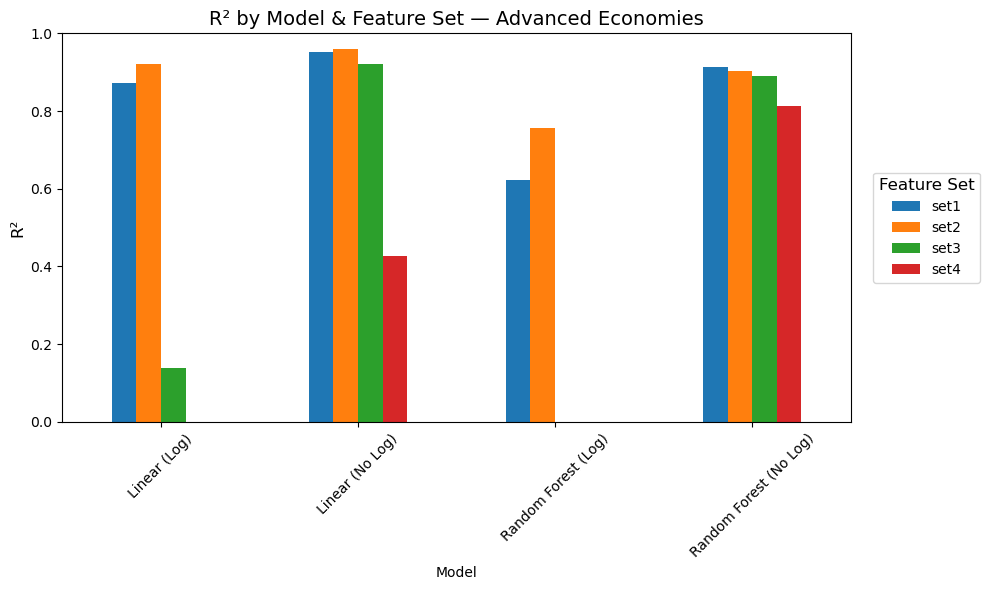

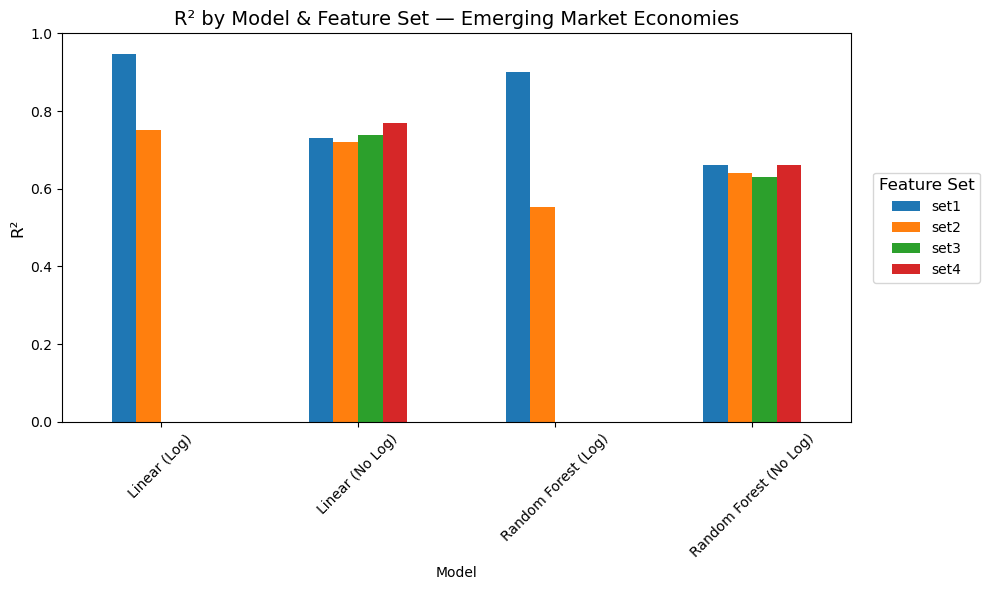

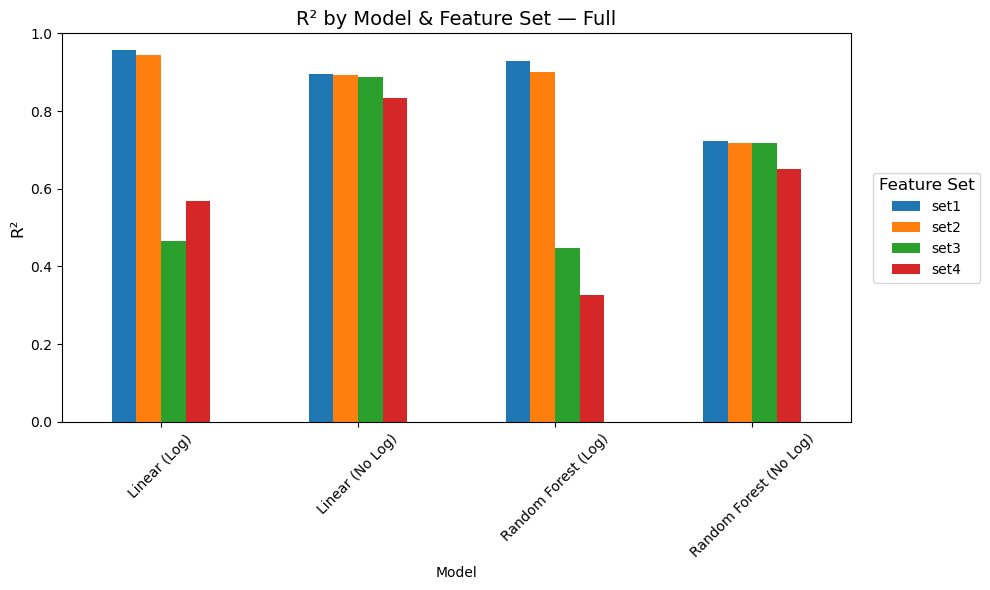

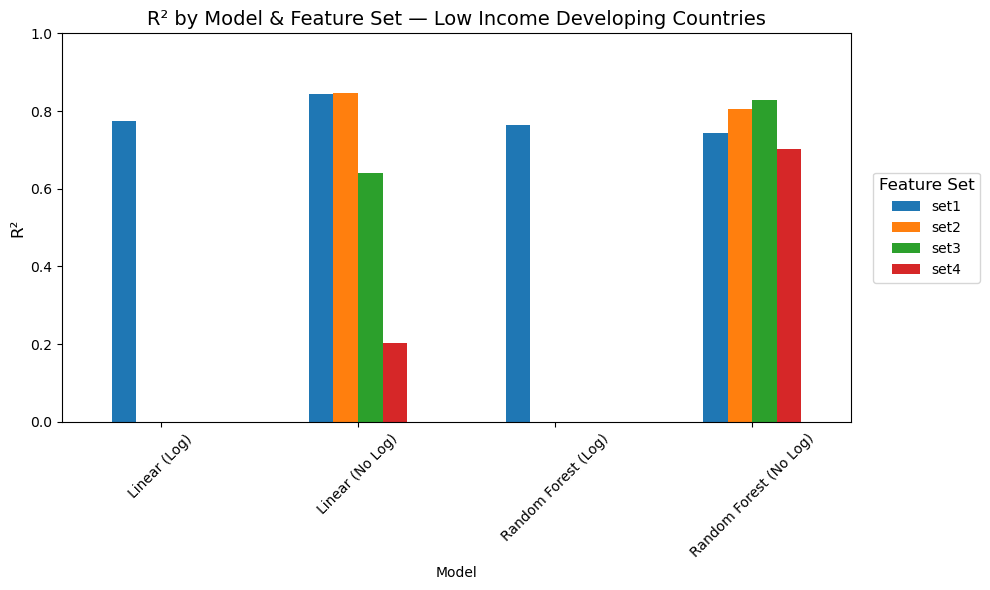

In [64]:
# #Plot Income Group R2

for grp, pivot in group_tables.items():
    fig, ax = plt.subplots(figsize=(10,6))
    pivot.plot.bar(ax=ax)
    ax.set_title(f'R² by Model & Feature Set — {grp}', fontsize=14)
    ax.set_ylim(0,1)
    ax.set_ylabel('R²', fontsize=12)
    ax.tick_params(axis='x', rotation=45)
    ax.legend(
        title='Feature Set',
        bbox_to_anchor=(1.02,0.5),
        loc='center left',
        fontsize=10,
        title_fontsize=12
    )
    fig.tight_layout()
    plt.show()


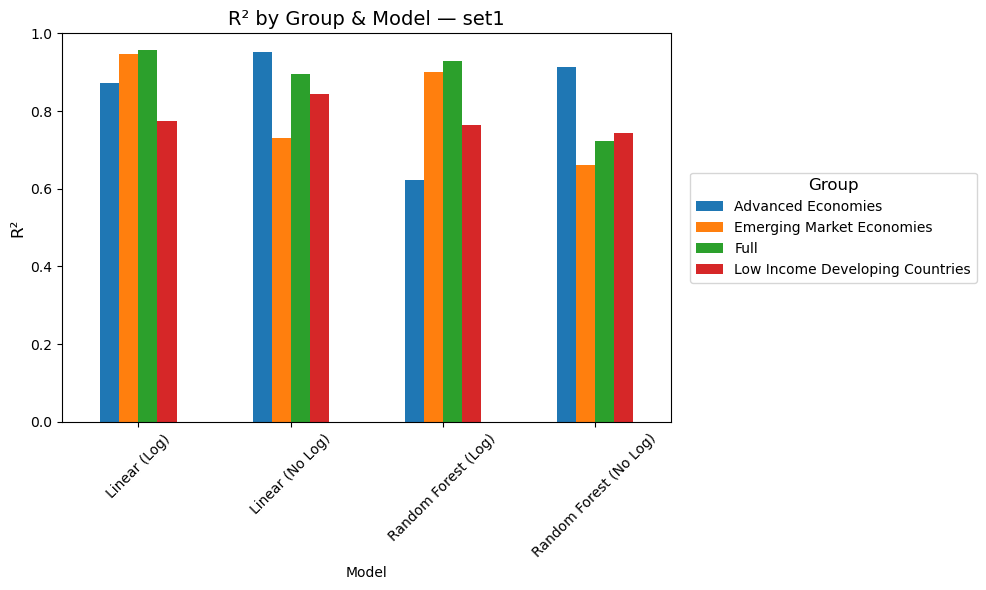

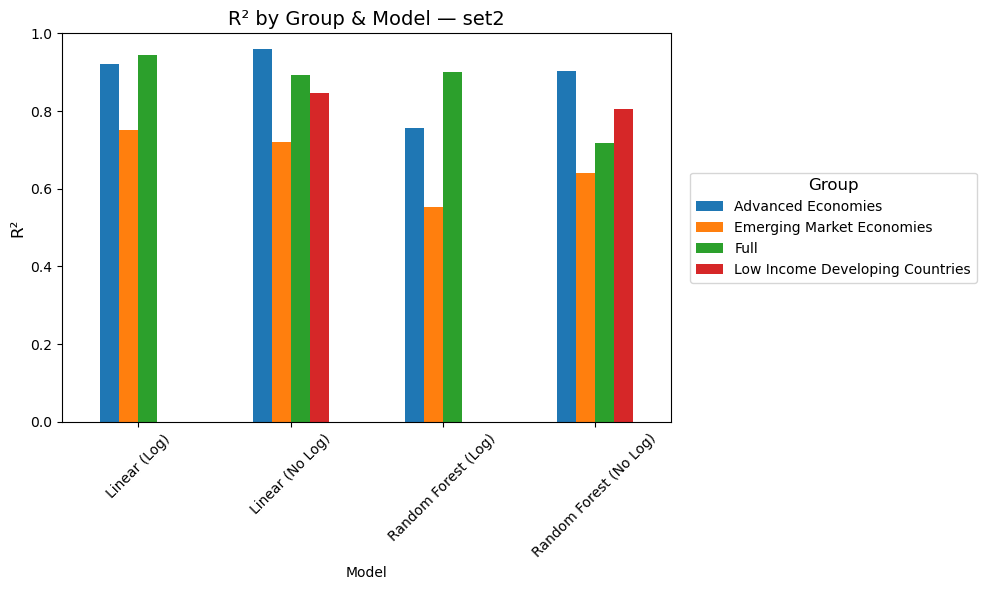

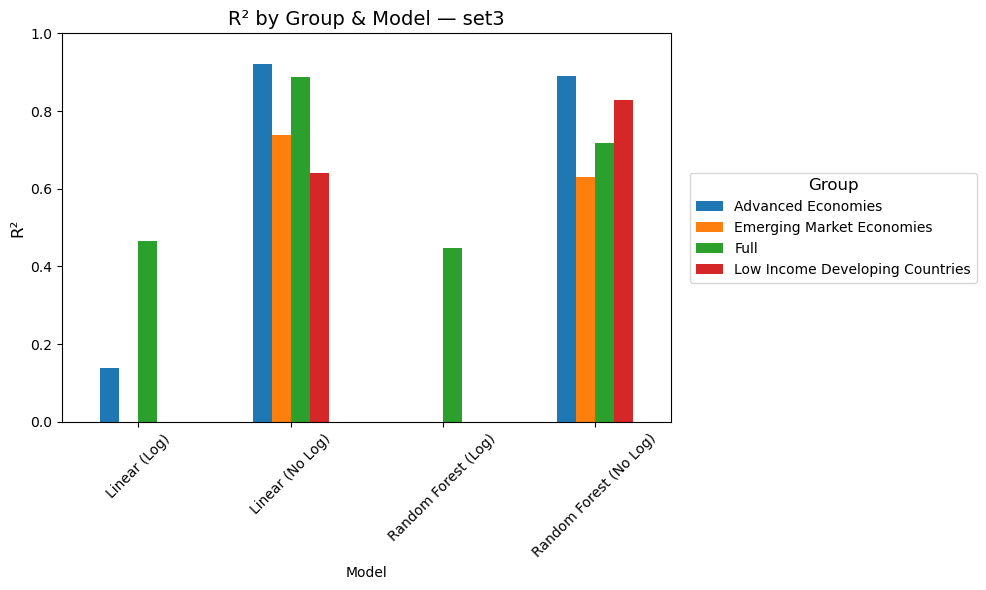

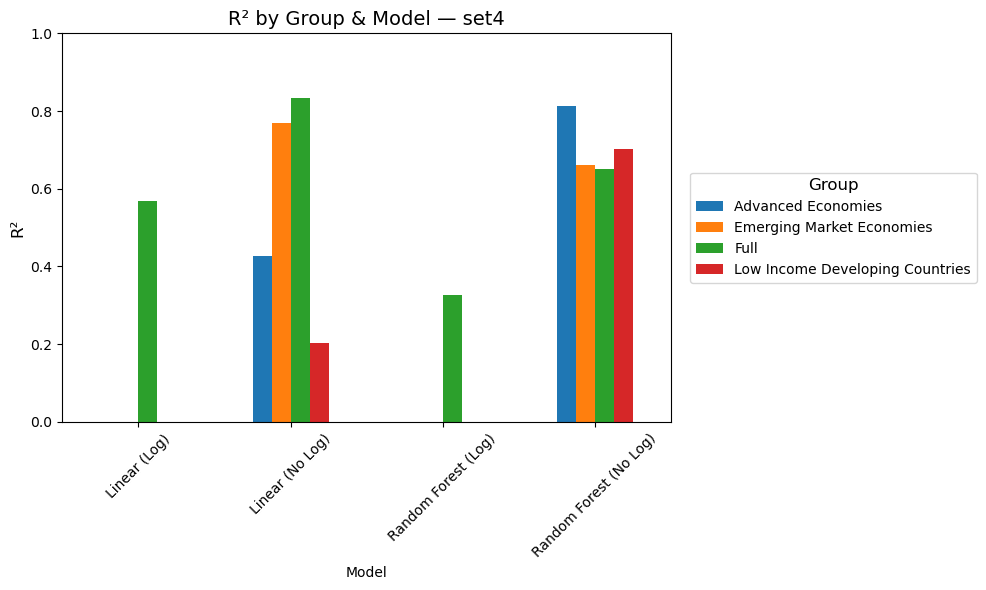

In [65]:
#  Plot per Feature Set
for fs, pivot in set_tables.items():
    fig, ax = plt.subplots(figsize=(10,6))
    pivot.plot.bar(ax=ax)
    ax.set_title(f'R² by Group & Model — {fs}', fontsize=14)
    ax.set_ylim(0,1)
    ax.set_ylabel('R²', fontsize=12)
    ax.tick_params(axis='x', rotation=45)
    ax.legend(
        title='Group',
        bbox_to_anchor=(1.02,0.5),
        loc='center left',
        fontsize=10,
        title_fontsize=12
    )
    fig.tight_layout()
    plt.show()


In [66]:
def print_best(df, group_by, metric='R2'):
    """
    Prints the best row (highest `metric`) for each unique value in `group_by`.
    
    Parameters
    ----------
    df : pd.DataFrame
    group_by : str or list[str]
        Column(s) to group on.
    metric : str
        The numeric column to maximize (default 'R2').
    """
    # find index of max-metric within each group
    idx = df.groupby(group_by)[metric].idxmax()
    best = df.loc[idx].reset_index(drop=True)
    display(best[[*([group_by] if isinstance(group_by, str) else group_by),
                 'Dataset','Feature_Set','Model',metric]])


In [67]:
# best by income‐group
print("Best Model and Set for each Income‐Group:")
print_best(df_clean, 'Group')

# best by feature‐set
print("\nBest Model and Group for each Feature_Set:")
print_best(df_clean, 'Feature_Set')

# best by model type
print("\nBest Dataset and Set for each Model:")
print_best(df_clean, 'Model')


Best Model and Set for each Income‐Group:


Group                                 Dataset  \
0               Advanced Economies               Advanced Economies – set2   
1        Emerging Market Economies        Emerging Market Economies – set1   
2                             Full                             Full – set1   
3  Low Income Developing Countries  Low Income Developing Countries – set2   

  Feature_Set            Model   R2  
0        set2  Linear (No Log) 0.96  
1        set1     Linear (Log) 0.95  
2        set1     Linear (Log) 0.96  
3        set2  Linear (No Log) 0.85


Best Model and Group for each Feature_Set:


Feature_Set                    Dataset Feature_Set            Model   R2
0        set1                Full – set1        set1     Linear (Log) 0.96
1        set2  Advanced Economies – set2        set2  Linear (No Log) 0.96
2        set3  Advanced Economies – set3        set3  Linear (No Log) 0.92
3        set4                Full – set4        set4  Linear (No Log) 0.83


Best Dataset and Set for each Model:


Model                    Dataset Feature_Set  \
0            Linear (Log)                Full – set1        set1   
1         Linear (No Log)  Advanced Economies – set2        set2   
2     Random Forest (Log)                Full – set1        set1   
3  Random Forest (No Log)  Advanced Economies – set1        set1   

                    Model   R2  
0            Linear (Log) 0.96  
1         Linear (No Log) 0.96  
2     Random Forest (Log) 0.93  
3  Random Forest (No Log) 0.91

***PLoT SHAP values and PDP for Each Income Group***

In [69]:
def plot_pdp(model, X_train, features, feature_names, model_label="Model"):
    """Plot Partial Dependence Plot (PDP) for given features."""
    if hasattr(model, "predict"):
        plt.figure(figsize=(14, 6))
        display = PartialDependenceDisplay.from_estimator(
            model, 
            X_train, 
            features=[feature_names.index(f) for f in features],
            feature_names=feature_names,
            kind="average",
            n_cols=2
        )
        plt.suptitle(f'Partial Dependence Plots - {model_label}', fontsize=16)
        plt.tight_layout()
        plt.show()
    else:
        print(f"Model {model_label} does not support PDP.")


In [70]:

def plot_shap(model, X_train, feature_names, model_label="Model"):
    """Plot SHAP summary plot for Random Forest or Tree models."""
    if hasattr(model, "feature_importances_"):
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_train)

        shap.summary_plot(shap_values, X_train, feature_names=feature_names, plot_type="bar", show=True)
        shap.summary_plot(shap_values, X_train, feature_names=feature_names, show=True)
    else:
        print(f"Model {model_label} does not support SHAP plotting.")


In [71]:
def tune_random_forest(X, y, group_name="Group", random_state=42, n_iter=10):
    """Hyperparameter tuning Random Forest using RandomizedSearchCV."""
    print(f"\n==== Hyperparameter Tuning (Random Forest) for {group_name} ====")
    param_dist = {
        'max_depth': [4, 6, 8, 10, 12],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None]
    }
    rf = RandomForestRegressor(n_estimators=100, random_state=random_state)
    rs = RandomizedSearchCV(
        rf, param_distributions=param_dist,
        n_iter=n_iter, cv=TimeSeriesSplit(3), scoring='r2', n_jobs=-1, random_state=random_state
    )
    rs.fit(X, y)
    print("Best Params:", rs.best_params_)
    print(f"Best R² Score: {rs.best_score_:.4f}\n")
    return rs.best_estimator_

In [72]:
def auto_tune_all_groups(groups_data, log_features):
    """Auto tune Random Forest for all groups given in dictionary {'group_name': (X, y)}."""
    models = {}
    for group_name, (X, y) in groups_data.items():
        model = tune_random_forest(X, y, group_name=group_name)
        models[group_name] = model
    return models


In [73]:
def auto_pdp_shap_all_groups(tuned_models, groups_data, log_features):
    """Auto plot PDP and SHAP for each tuned model by group."""
    for group_name, model in tuned_models.items():
        print(f"\n==== PDP and SHAP for {group_name} ====")
        X, _ = groups_data[group_name]

        # Partial Dependence Plot
        plot_pdp(
            model,
            X,
            features=['log_priv_capital', 'log_labor_force'],
            feature_names=log_features,
            model_label=f"Random Forest Tuned - {group_name}"
        )

        # SHAP Values
        plot_shap(
            model,
            X,
            feature_names=log_features,
            model_label=f"Random Forest Tuned - {group_name}"
        )

In [74]:

simple_features = ['priv_capital', 'gov_capital', 'ppp_capital', 'labor_force']
log_features = [f'log_{col}' for col in simple_features]

# Low Income
print("Low Income Developing Countries:")
df_low = df_cleaned[df_cleaned['income_group'] == 'Low Income Developing Countries']
df_low_log = log_transform_features(df_low, simple_features, target_to_log='GDP_rppp')
model_rf_log_low, X_train_rf_log_low, y_train_rf_log_low = train_test_models(df_low_log, log_features, target='log_GDP_rppp', model_type='randomforest')

# Emerging Markets
print("\nEmerging Market Countries:")
df_emerging = df_cleaned[df_cleaned['income_group'] == 'Emerging Market Economies']
df_emerging_log = log_transform_features(df_emerging, simple_features, target_to_log='GDP_rppp')
model_rf_log_emerging, X_train_rf_log_emerging, y_train_rf_log_emerging = train_test_models(df_emerging_log, log_features, target='log_GDP_rppp', model_type='randomforest')

# Advanced Economies
print("\nAdvanced Economies Countries:")
df_advanced = df_cleaned[df_cleaned['income_group'] == 'Advanced Economies']
df_advanced_log = log_transform_features(df_advanced, simple_features, target_to_log='GDP_rppp')
model_rf_log_advanced, X_train_rf_log_advanced, y_train_rf_log_advanced = train_test_models(df_advanced_log, log_features, target='log_GDP_rppp', model_type='randomforest')


Low Income Developing Countries:
Randomforest Model Test Results:
 → Test MSE: 0.3564
 → Test R² : 0.7376


Emerging Market Countries:
Randomforest Model Test Results:
 → Test MSE: 0.1947
 → Test R² : 0.9581


Advanced Economies Countries:
Randomforest Model Test Results:
 → Test MSE: 0.1549
 → Test R² : 0.9487



**PLOTTING PDP & SHAP VALUE FOR THREE INCOME GROUPS**

<Figure size 1400x600 with 0 Axes>

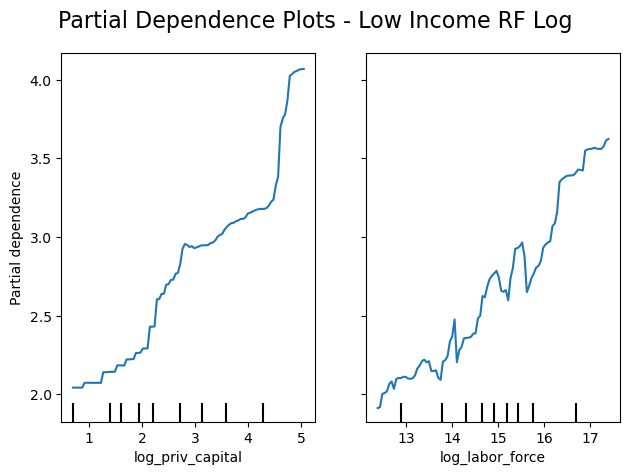

Model Low Income RF Log does not support SHAP plotting.


<Figure size 1400x600 with 0 Axes>

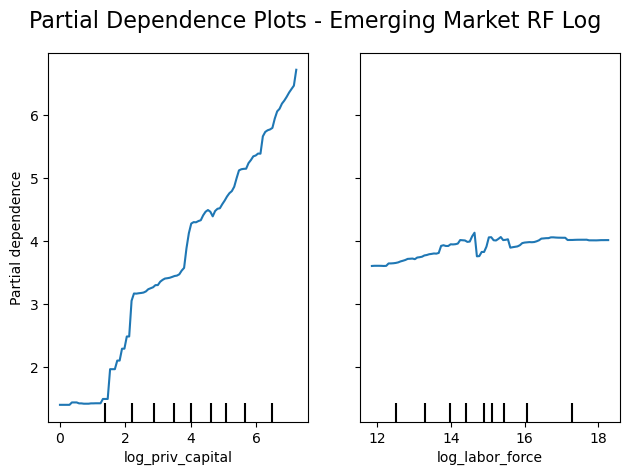

Model Emerging Market RF Log does not support SHAP plotting.


<Figure size 1400x600 with 0 Axes>

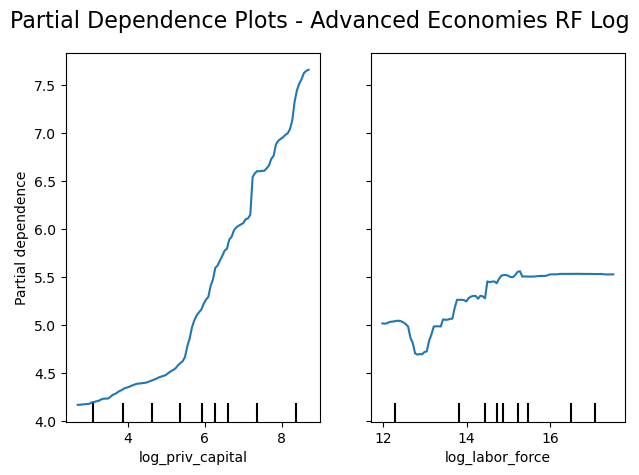

Model Advanced Economies RF Log does not support SHAP plotting.


In [76]:
plot_pdp(model_rf_log_low, X_train_rf_log_low, features=['log_priv_capital', 'log_labor_force'], feature_names=log_features, model_label="Low Income RF Log")
plot_shap(model_rf_log_low, X_train_rf_log_low, feature_names=log_features, model_label="Low Income RF Log")

plot_pdp(model_rf_log_emerging, X_train_rf_log_emerging, features=['log_priv_capital', 'log_labor_force'], feature_names=log_features, model_label="Emerging Market RF Log")
plot_shap(model_rf_log_emerging, X_train_rf_log_emerging, feature_names=log_features, model_label="Emerging Market RF Log")

plot_pdp(model_rf_log_advanced, X_train_rf_log_advanced, features=['log_priv_capital', 'log_labor_force'], feature_names=log_features, model_label="Advanced Economies RF Log")
plot_shap(model_rf_log_advanced, X_train_rf_log_advanced, feature_names=log_features, model_label="Advanced Economies RF Log")


In [77]:
# Define feature columns
log_features = ['log_priv_capital', 'log_gov_capital', 'log_ppp_capital', 'log_labor_force']

# Prepare log-transformed datasets if not done yet
df_low_log = log_transform_features(df_low, ['priv_capital', 'gov_capital', 'ppp_capital', 'labor_force'], target_to_log='GDP_rppp')
df_emerging_log = log_transform_features(df_emerging, ['priv_capital', 'gov_capital', 'ppp_capital', 'labor_force'], target_to_log='GDP_rppp')
df_advanced_log = log_transform_features(df_advanced, ['priv_capital', 'gov_capital', 'ppp_capital', 'labor_force'], target_to_log='GDP_rppp')

# Create X and y for each group
X_low_log = df_low_log[log_features]
y_low_log = df_low_log['log_GDP_rppp']

X_emerging_log = df_emerging_log[log_features]
y_emerging_log = df_emerging_log['log_GDP_rppp']

X_advanced_log = df_advanced_log[log_features]
y_advanced_log = df_advanced_log['log_GDP_rppp']



In [78]:
# Hyperparameter Tuning
groups_data = {
    'Low Income Developing Countries': (X_low_log, y_low_log),
    'Emerging Market Economies': (X_emerging_log, y_emerging_log),
    'Advanced Economies': (X_advanced_log, y_advanced_log)
}

# Call Auto Tune
tuned_models = auto_tune_all_groups(groups_data, log_features)



==== Hyperparameter Tuning (Random Forest) for Low Income Developing Countries ====
Best Params: {'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 12}
Best R² Score: 0.8142


==== Hyperparameter Tuning (Random Forest) for Emerging Market Economies ====
Best Params: {'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 10}
Best R² Score: 0.9283


==== Hyperparameter Tuning (Random Forest) for Advanced Economies ====
Best Params: {'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 8}
Best R² Score: 0.9359




==== PDP and SHAP for Low Income Developing Countries ====


<Figure size 1400x600 with 0 Axes>

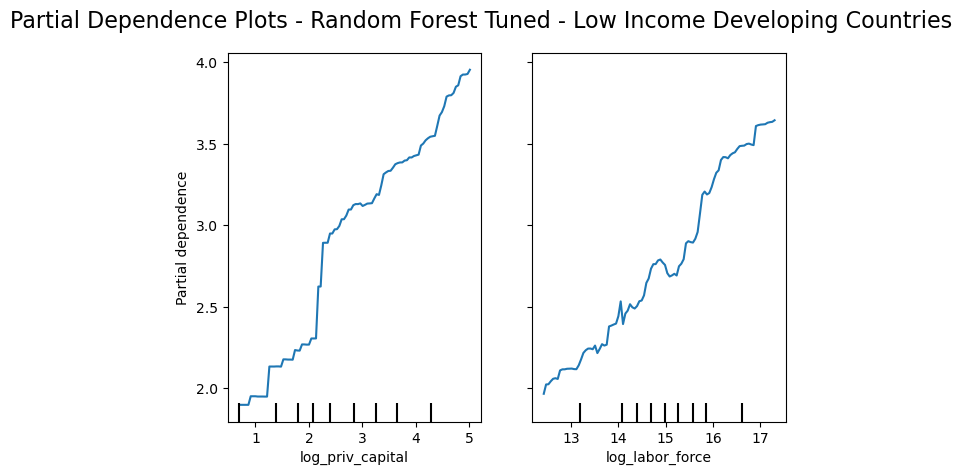

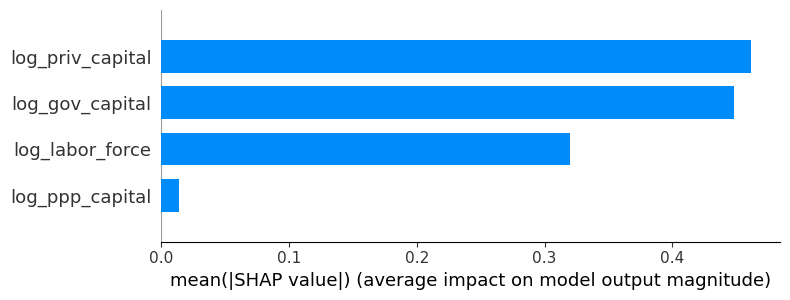

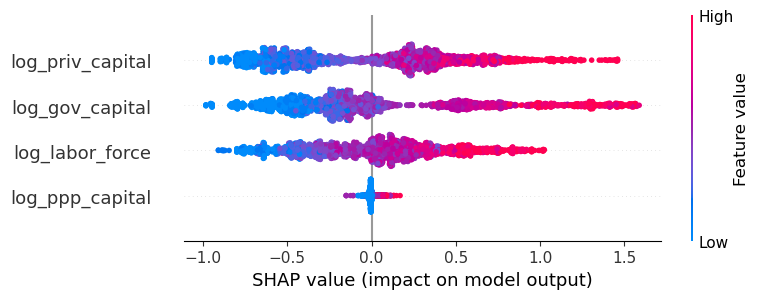


==== PDP and SHAP for Emerging Market Economies ====


<Figure size 1400x600 with 0 Axes>

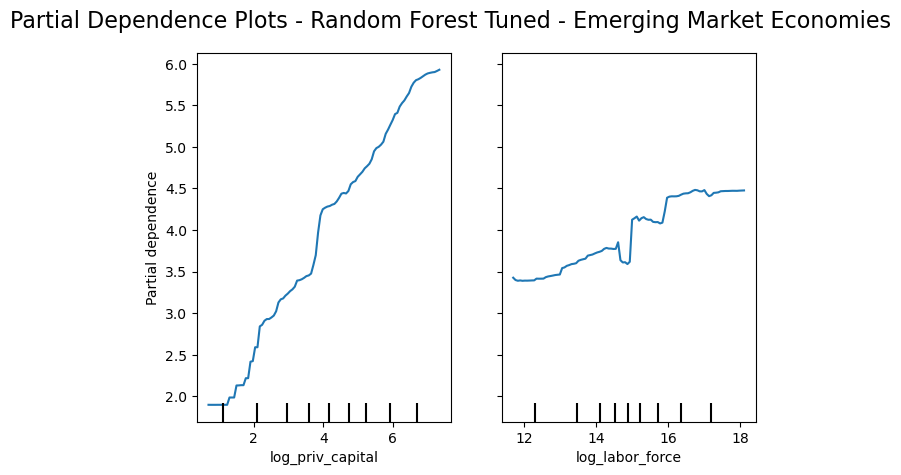

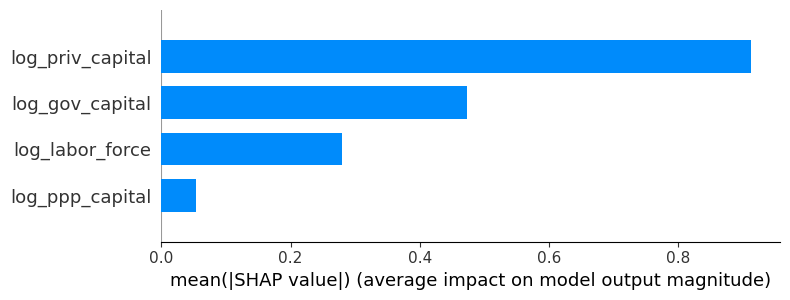

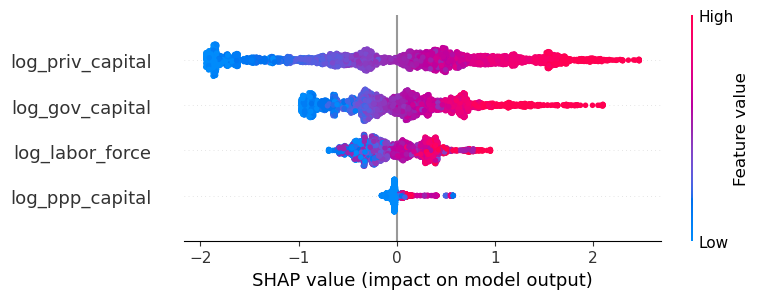


==== PDP and SHAP for Advanced Economies ====


<Figure size 1400x600 with 0 Axes>

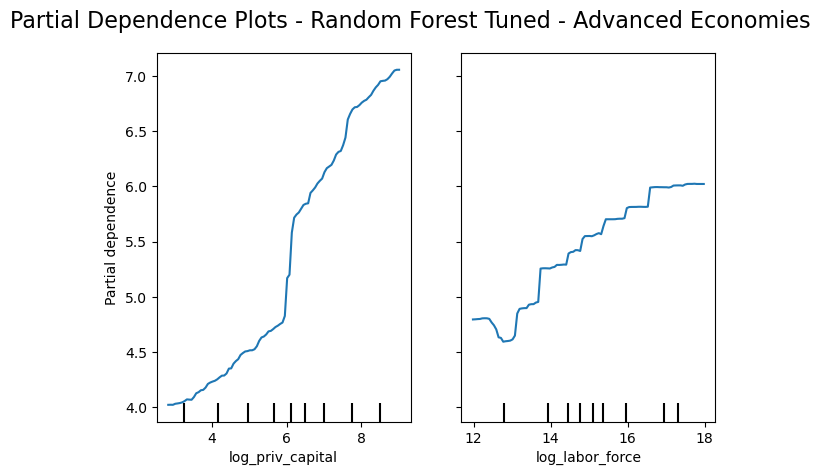

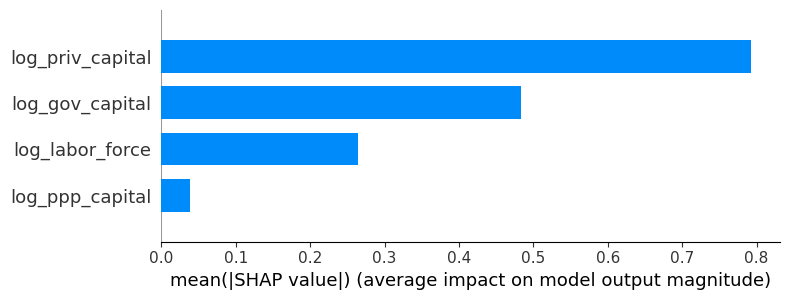

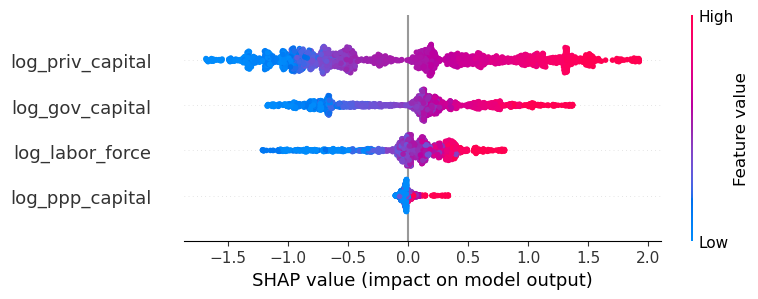

In [79]:
auto_pdp_shap_all_groups(tuned_models, groups_data, log_features)


**XGBOOST**

In [81]:
def train_and_cv_xgb(X, y, group_label="Group"):
    """Train XGBoost model, evaluate test set, and perform 5-fold TimeSeries CV."""
    print(f"\n===== XGBoost Training and Evaluation for {group_label} =====")

    # Split into train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Train XGBoost
    model_xgb = XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        verbosity=0
    )
    model_xgb.fit(X_train, y_train)

    # Test evaluation
    y_pred = model_xgb.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Test MSE: {mse:.4f}")
    print(f"Test R² : {r2:.4f}")

    # 5-Fold CV
    avg_mse, avg_r2 = cross_validate_models(model_xgb, X_train, y_train, cv_type='timeseries', n_splits=5)

    return model_xgb


In [82]:
model_xgb_low = train_and_cv_xgb(X_low_log, y_low_log, group_label="Low Income Developing Countries")
model_xgb_emerging = train_and_cv_xgb(X_emerging_log, y_emerging_log, group_label="Emerging Market Economies")
model_xgb_advanced = train_and_cv_xgb(X_advanced_log, y_advanced_log, group_label="Advanced Economies")



===== XGBoost Training and Evaluation for Low Income Developing Countries =====
Test MSE: 0.3837
Test R² : 0.7175
Fold 1: MSE=0.0673, R²=0.9412
Fold 2: MSE=0.1356, R²=0.9007
Fold 3: MSE=0.2535, R²=0.8085
Fold 4: MSE=0.4878, R²=0.5232
Fold 5: MSE=0.1734, R²=0.9043

Average MSE: 0.2235
Average R² : 0.8156


===== XGBoost Training and Evaluation for Emerging Market Economies =====
Test MSE: 0.2030
Test R² : 0.9564
Fold 1: MSE=0.6023, R²=0.8446
Fold 2: MSE=0.3718, R²=0.8969
Fold 3: MSE=0.1775, R²=0.9612
Fold 4: MSE=0.4205, R²=0.8076
Fold 5: MSE=0.1870, R²=0.9225

Average MSE: 0.3518
Average R² : 0.8866


===== XGBoost Training and Evaluation for Advanced Economies =====
Test MSE: 0.1851
Test R² : 0.9387
Fold 1: MSE=1.9836, R²=-0.2619
Fold 2: MSE=0.2466, R²=0.9521
Fold 3: MSE=0.0550, R²=0.9820
Fold 4: MSE=0.7461, R²=0.2297
Fold 5: MSE=0.0744, R²=0.8662

Average MSE: 0.6211
Average R² : 0.5536



**Panel Data Analysis on R packages**

In [84]:
def run_panel_model_single(panel_df, group_label="All Panel"):
    """Run Fixed Effects and Random Effects models, extract effects for the panel data."""
    print(f"\n===== Panel Modeling for {group_label} =====")

    # Ensure panel_df has the correct structure
    panel_df = panel_df.reset_index() if not {'country', 'year'}.issubset(panel_df.index.names) else panel_df

    # Add log1p columns if not present
    for col in ['priv_capital', 'gov_capital', 'ppp_capital', 'labor_force', 'GDP_rppp']:
        if f'log1p_{col}' not in panel_df.columns:
            panel_df[f'log1p_{col}'] = np.log1p(panel_df[col])

    df_panel = panel_df.set_index(['country', 'year']).sort_index()

    # Define dependent and independent variables
    y = df_panel['log1p_GDP_rppp']
    X = df_panel[['log1p_priv_capital', 'log1p_gov_capital', 'log1p_ppp_capital', 'log1p_labor_force']]
    X = sm.add_constant(X)

    # Fixed Effects (Country)
    fe = PanelOLS(y, X, entity_effects=True)
    fe_res = fe.fit()
    print("===== Fixed Effects Results =====")
    print(fe_res)

    # Random Effects
    re = RandomEffects(y, X)
    re_res = re.fit()
    print("\n===== Random Effects Results =====")
    print(re_res)

    # Hausman Comparison
    cmp = compare({'Fixed': fe_res, 'Random': re_res})
    print("\n===== Hausman Test Comparison =====")
    print(cmp)

    # Extract country fixed effects
    ent = fe_res.estimated_effects
    country_fe = (
        ent
        .groupby('country')['estimated_effects']
        .mean()
        .reset_index()
        .rename(columns={'estimated_effects': 'country_fixed_effect'})
    )

    # Extract time fixed effects
    fe_time_res = PanelOLS(y, X, time_effects=True).fit()
    tim = fe_time_res.estimated_effects
    time_fe = (
        tim
        .groupby('year')['estimated_effects']
        .mean()
        .reset_index()
        .rename(columns={'estimated_effects': 'time_fixed_effect'})
    )

    # Extract random effects
    residuals = re_res.resids
    if isinstance(residuals, pd.Series):
        residuals = residuals.to_frame(name='residuals')
    else:
        residuals = residuals.rename(columns={residuals.columns[0]: 'residuals'})

    country_re = (
        residuals
        .groupby('country')['residuals']
        .mean()
        .reset_index()
        .rename(columns={'residuals': 'country_random_effect'})
    )

    # Compute weights for random effects
    sigma2_e = re_res.variance_decomposition['Residual']
    sigma2_u = re_res.variance_decomposition['Effects']
    panel_sizes = df_panel.groupby('country').size()
    weight = sigma2_u / (sigma2_u + sigma2_e / panel_sizes)
    country_re['country_random_effect'] = country_re['country_random_effect'] * weight.reindex(country_re['country']).values

    # Merge country effects
    country_effects_df = country_re.merge(country_fe, on='country', how='left')[['country', 'country_random_effect', 'country_fixed_effect']]

    # Merge all effects back to original data for future queries
    result_df = (
        panel_df.reset_index()
        .merge(country_re, on='country', how='left')
        .merge(country_fe, on='country', how='left')
        .merge(time_fe, on='year', how='left')
    )[['country', 'year', 'country_random_effect', 'country_fixed_effect', 'time_fixed_effect']]

    # Print country effects (one row per country)
    print(f"\nCountry Effects for {group_label} (Random and Fixed Effects, one row per country):")
    display(country_effects_df)

    # Print time effects (one row per year)
    print(f"\nTime Effects for {group_label} (Fixed Effects, one row per year):")
    display(time_fe)

    return result_df

In [85]:
def display_country_effects(df_cleaned):
    """
    List available countries, prompt for a country name, and display its effects for All Countries
    and its specific income group.
    
    Parameters:
    df_cleaned (pd.DataFrame): The original cleaned DataFrame with income group information
    """
    # Run panel model for All Countries to get the effects for all countries
    panel_all = df_cleaned.sort_values(['country', 'year']).set_index(['country', 'year'])
    result_df_all = run_panel_model_single(panel_all.reset_index(), group_label="All Countries (No Grouping)")

    # List available countries
    print("\nAvailable countries in the dataset:")
    print(result_df_all['country'].unique())

    # Prompt user for a country name
    while True:
        try:
            country_to_print = input("\nEnter a country name to see its effects (or 'stop' to exit): ").strip().lower()
            if country_to_print == 'stop':
                print("Exiting the function.")
                break

            # Check if the country exists in the dataset
            country_data_all = result_df_all[result_df_all['country'].str.lower() == country_to_print]
            if country_data_all.empty:
                print(f"No data found for country: {country_to_print}")
                continue

            # Display effects for the country from All Countries
            print(f"\nEffects for {country_to_print.capitalize()} in All Countries (No Grouping):")
            display(country_data_all)

            # Determine the income group of the country
            country_income_group = df_cleaned[df_cleaned['country'].str.lower() == country_to_print]['income_group'].iloc[0]
            if pd.isna(country_income_group):
                print(f"No income group found for {country_to_print.capitalize()}.")
                continue

            # Run panel model for the specific income group
            income_group_df = (
                df_cleaned[df_cleaned['income_group'] == country_income_group]
                .sort_values(['country', 'year'])
                .set_index(['country', 'year'])
            )
            result_df_income = run_panel_model_single(income_group_df.reset_index(), group_label=country_income_group)

            # Display effects for the country in its income group
            country_data_income = result_df_income[result_df_income['country'].str.lower() == country_to_print]
            print(f"\nEffects for {country_to_print.capitalize()} in {country_income_group}:")
            display(country_data_income)

        except Exception as e:
            print(f"An error occurred: {e}. Please try again or type 'stop' to exit.")

In [86]:


# All Countries
panel_2 = df_cleaned.sort_values(['country', 'year']).set_index(['country', 'year'])
run_panel_model_single(panel_2.reset_index(), group_label="All Countries (No Grouping)")



===== Panel Modeling for All Countries (No Grouping) =====
===== Fixed Effects Results =====
                          PanelOLS Estimation Summary                           
Dep. Variable:         log1p_GDP_rppp   R-squared:                        0.8089
Estimator:                   PanelOLS   R-squared (Between):              0.8943
No. Observations:                8652   R-squared (Within):               0.8089
Date:                Sun, Apr 27 2025   R-squared (Overall):              0.8911
Time:                        01:03:15   Log-likelihood                   -71.788
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      8985.7
Entities:                         155   P-value                           0.0000
Avg Obs:                       55.819   Distribution:                  F(4,8493)
Min Obs:                       11.000                                           
Max Obs:       

C:\Users\Sushil\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Sushil\anaconda3\Lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
C:\Users\Sushil\anaconda3\Lib\site-packages\linearmodels\panel\model.py:2759: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
C:\Users\Sushil\anaconda3\Lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


country  country_random_effect  country_fixed_effect
0            Afghanistan                  -0.04                 -0.53
1                Albania                  -0.00                  0.07
2                Algeria                  -0.01                 -0.19
3                 Angola                  -0.04                 -0.59
4    Antigua and Barbuda                  -0.09                 -1.19
..                   ...                    ...                   ...
150        United States                  -0.04                 -0.74
151              Uruguay                  -0.00                  0.09
152           Uzbekistan                   0.07                  0.86
153               Zambia                   0.01                  0.13
154             Zimbabwe                  -0.01                 -0.23

[155 rows x 3 columns]


Time Effects for All Countries (No Grouping) (Fixed Effects, one row per year):


year  time_fixed_effect
0   1960               0.02
1   1961               0.02
2   1962               0.02
3   1963               0.02
4   1964               0.03
5   1965               0.03
6   1966               0.02
7   1967               0.02
8   1968               0.02
9   1969               0.03
10  1970               0.05
11  1971               0.05
12  1972               0.05
13  1973               0.07
14  1974               0.07
15  1975               0.05
16  1976               0.05
17  1977               0.08
18  1978               0.09
19  1979               0.08
20  1980               0.05
21  1981               0.04
22  1982               0.02
23  1983              -0.00
24  1984               0.00
25  1985               0.00
26  1986               0.00
27  1987               0.00
28  1988               0.01
29  1989               0.01
30  1990               0.01
31  1991              -0.03
32  1992              -0.07
33  1993              -0.08
34  1994              -0.09
35  1995              -0.09
36  1996              -0.07
37  1997              -0.06
38  1998              -0.04
39  1999              -0.04
40  2000              -0.03
41  2001              -0.03
42  2002              -0.03
43  2003              -0.02
44  2004              -0.01
45  2005               0.01
46  2006               0.02
47  2007               0.03
48  2008               0.02
49  2009              -0.02
50  2010              -0.02
51  2011              -0.02
52  2012              -0.01
53  2013              -0.03
54  2014              -0.04
55  2015              -0.05
56  2016              -0.05
57  2017              -0.05
58  2018              -0.05
59  2019              -0.04

country  year  country_random_effect  country_fixed_effect  \
0     Afghanistan  1960                  -0.04                 -0.53   
1     Afghanistan  1961                  -0.04                 -0.53   
2     Afghanistan  1962                  -0.04                 -0.53   
3     Afghanistan  1963                  -0.04                 -0.53   
4     Afghanistan  1964                  -0.04                 -0.53   
...           ...   ...                    ...                   ...   
9137     Zimbabwe  2015                  -0.01                 -0.23   
9138     Zimbabwe  2016                  -0.01                 -0.23   
9139     Zimbabwe  2017                  -0.01                 -0.23   
9140     Zimbabwe  2018                  -0.01                 -0.23   
9141     Zimbabwe  2019                  -0.01                 -0.23   

      time_fixed_effect  
0                  0.02  
1                  0.02  
2                  0.02  
3                  0.02  
4                  0.03  
...                 ...  
9137              -0.05  
9138              -0.05  
9139              -0.05  
9140              -0.05  
9141              -0.04  

[9142 rows x 5 columns]

In [87]:
# Low Income Developing Countries
low_income_df = (
    df_cleaned[df_cleaned['income_group'] == 'Low Income Developing Countries']
    .sort_values(['country', 'year'])
    .set_index(['country', 'year'])
)

run_panel_model_single(low_income_df.reset_index(), group_label="Low Income Developing Countries")


===== Panel Modeling for Low Income Developing Countries =====
===== Fixed Effects Results =====
                          PanelOLS Estimation Summary                           
Dep. Variable:         log1p_GDP_rppp   R-squared:                        0.8110
Estimator:                   PanelOLS   R-squared (Between):              0.8200
No. Observations:                2715   R-squared (Within):               0.8110
Date:                Sun, Apr 27 2025   R-squared (Overall):              0.8209
Time:                        01:03:15   Log-likelihood                    19.332
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      2858.2
Entities:                          46   P-value                           0.0000
Avg Obs:                       59.022   Distribution:                  F(4,2665)
Min Obs:                       36.000                                           
Max Obs:   

country  country_random_effect  country_fixed_effect
0                Afghanistan                  -0.02                 -0.30
1                 Bangladesh                  -0.02                 -0.39
2                      Benin                  -0.03                 -0.41
3                     Bhutan                   0.02                  0.46
4               Burkina Faso                  -0.02                 -0.26
5                    Burundi                  -0.03                 -0.41
6                   Cambodia                  -0.01                 -0.09
7                   Cameroon                  -0.00                 -0.04
8   Central African Republic                  -0.05                 -0.60
9                       Chad                  -0.00                 -0.05
10                   Comoros                   0.06                  0.95
11                  Djibouti                   0.08                  0.97
12                   Eritrea                  -0.02                 -0.16
13                  Ethiopia                  -0.04                 -0.65
14               Gambia, The                   0.06                  0.76
15                     Ghana                  -0.01                 -0.21
16                    Guinea                   0.03                  0.36
17             Guinea-Bissau                   0.03                  0.53
18                     Haiti                   0.00                  0.02
19                  Honduras                  -0.01                 -0.14
20                     Kenya                  -0.01                 -0.14
21                   Lesotho                  -0.01                 -0.03
22                   Liberia                  -0.02                 -0.19
23                Madagascar                   0.01                  0.08
24                    Malawi                  -0.04                 -0.50
25                      Mali                  -0.03                 -0.46
26                Mauritania                   0.02                  0.44
27                   Moldova                   0.08                  1.17
28                Mozambique                  -0.06                 -0.79
29                   Myanmar                  -0.01                 -0.19
30                     Nepal                   0.00                  0.04
31                 Nicaragua                   0.01                  0.23
32                     Niger                  -0.04                 -0.52
33                   Nigeria                  -0.06                 -0.93
34          Papua New Guinea                   0.01                  0.23
35                    Rwanda                   0.00                  0.02
36                   Senegal                   0.02                  0.27
37              Sierra Leone                   0.03                  0.36
38                     Sudan                   0.05                  0.63
39                Tajikistan                   0.01                  0.16
40                  Tanzania                  -0.05                 -0.71
41                      Togo                  -0.03                 -0.28
42                    Uganda                  -0.01                 -0.19
43                Uzbekistan                   0.08                  1.04
44                    Zambia                   0.03                  0.45
45                  Zimbabwe                   0.01                  0.09


Time Effects for Low Income Developing Countries (Fixed Effects, one row per year):


year  time_fixed_effect
0   1960              -0.07
1   1961              -0.07
2   1962              -0.07
3   1963              -0.04
4   1964              -0.03
5   1965              -0.03
6   1966              -0.04
7   1967              -0.04
8   1968              -0.04
9   1969              -0.01
10  1970               0.01
11  1971               0.02
12  1972               0.00
13  1973              -0.00
14  1974               0.01
15  1975              -0.00
16  1976              -0.01
17  1977               0.01
18  1978               0.04
19  1979               0.01
20  1980              -0.03
21  1981              -0.04
22  1982              -0.03
23  1983              -0.06
24  1984              -0.05
25  1985              -0.05
26  1986              -0.03
27  1987              -0.03
28  1988              -0.02
29  1989              -0.02
30  1990              -0.02
31  1991              -0.03
32  1992              -0.06
33  1993              -0.06
34  1994              -0.09
35  1995              -0.08
36  1996              -0.07
37  1997              -0.06
38  1998              -0.05
39  1999              -0.04
40  2000              -0.05
41  2001              -0.02
42  2002              -0.02
43  2003              -0.00
44  2004               0.00
45  2005               0.02
46  2006               0.03
47  2007               0.05
48  2008               0.05
49  2009               0.06
50  2010               0.08
51  2011               0.10
52  2012               0.12
53  2013               0.11
54  2014               0.12
55  2015               0.12
56  2016               0.12
57  2017               0.12
58  2018               0.12
59  2019               0.13

country  year  country_random_effect  country_fixed_effect  \
0     Afghanistan  1960                  -0.02                 -0.30   
1     Afghanistan  1961                  -0.02                 -0.30   
2     Afghanistan  1962                  -0.02                 -0.30   
3     Afghanistan  1963                  -0.02                 -0.30   
4     Afghanistan  1964                  -0.02                 -0.30   
...           ...   ...                    ...                   ...   
2710     Zimbabwe  2015                   0.01                  0.09   
2711     Zimbabwe  2016                   0.01                  0.09   
2712     Zimbabwe  2017                   0.01                  0.09   
2713     Zimbabwe  2018                   0.01                  0.09   
2714     Zimbabwe  2019                   0.01                  0.09   

      time_fixed_effect  
0                 -0.07  
1                 -0.07  
2                 -0.07  
3                 -0.04  
4                 -0.03  
...                 ...  
2710               0.12  
2711               0.12  
2712               0.12  
2713               0.12  
2714               0.13  

[2715 rows x 5 columns]

In [88]:
# Emerging Market Economies
emerging_df = (
    df_cleaned[df_cleaned['income_group'] == 'Emerging Market Economies']
    .sort_values(['country', 'year'])
    .set_index(['country', 'year'])
)
run_panel_model_single(emerging_df.reset_index(), group_label="Emerging Market Economies")



===== Panel Modeling for Emerging Market Economies =====
===== Fixed Effects Results =====
                          PanelOLS Estimation Summary                           
Dep. Variable:         log1p_GDP_rppp   R-squared:                        0.8086
Estimator:                   PanelOLS   R-squared (Between):              0.9128
No. Observations:                4138   R-squared (Within):               0.8086
Date:                Sun, Apr 27 2025   R-squared (Overall):              0.9113
Time:                        01:03:16   Log-likelihood                   -280.90
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      4286.0
Entities:                          77   P-value                           0.0000
Avg Obs:                       53.740   Distribution:                  F(4,4057)
Min Obs:                       11.000                                           
Max Obs:         

C:\Users\Sushil\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Sushil\anaconda3\Lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
C:\Users\Sushil\anaconda3\Lib\site-packages\linearmodels\panel\model.py:2759: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
C:\Users\Sushil\anaconda3\Lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


country  country_random_effect  country_fixed_effect
0                Albania                  -0.01                 -0.09
1                Algeria                  -0.01                 -0.13
2                 Angola                  -0.04                 -0.56
3    Antigua and Barbuda                  -0.09                 -1.21
4              Argentina                   0.03                  0.37
..                   ...                    ...                   ...
72              Thailand                  -0.05                 -0.77
73               Tunisia                  -0.01                 -0.07
74               Ukraine                   0.01                  0.07
75  United Arab Emirates                  -0.01                 -0.02
76               Uruguay                  -0.01                 -0.07

[77 rows x 3 columns]


Time Effects for Emerging Market Economies (Fixed Effects, one row per year):


year  time_fixed_effect
0   1960               0.10
1   1961               0.10
2   1962               0.10
3   1963               0.08
4   1964               0.09
5   1965               0.08
6   1966               0.07
7   1967               0.07
8   1968               0.06
9   1969               0.07
10  1970               0.08
11  1971               0.09
12  1972               0.10
13  1973               0.13
14  1974               0.13
15  1975               0.11
16  1976               0.12
17  1977               0.16
18  1978               0.16
19  1979               0.15
20  1980               0.13
21  1981               0.11
22  1982               0.06
23  1983               0.04
24  1984               0.05
25  1985               0.04
26  1986               0.04
27  1987               0.04
28  1988               0.04
29  1989               0.04
30  1990               0.03
31  1991              -0.04
32  1992              -0.08
33  1993              -0.10
34  1994              -0.10
35  1995              -0.12
36  1996              -0.10
37  1997              -0.10
38  1998              -0.05
39  1999              -0.07
40  2000              -0.07
41  2001              -0.08
42  2002              -0.08
43  2003              -0.07
44  2004              -0.04
45  2005              -0.02
46  2006              -0.01
47  2007               0.00
48  2008              -0.01
49  2009              -0.06
50  2010              -0.07
51  2011              -0.08
52  2012              -0.08
53  2013              -0.10
54  2014              -0.12
55  2015              -0.15
56  2016              -0.15
57  2017              -0.16
58  2018              -0.16
59  2019              -0.16

country  year  country_random_effect  country_fixed_effect  \
0     Albania  1960                  -0.01                 -0.09   
1     Albania  1961                  -0.01                 -0.09   
2     Albania  1962                  -0.01                 -0.09   
3     Albania  1963                  -0.01                 -0.09   
4     Albania  1964                  -0.01                 -0.09   
...       ...   ...                    ...                   ...   
4502  Uruguay  2015                  -0.01                 -0.07   
4503  Uruguay  2016                  -0.01                 -0.07   
4504  Uruguay  2017                  -0.01                 -0.07   
4505  Uruguay  2018                  -0.01                 -0.07   
4506  Uruguay  2019                  -0.01                 -0.07   

      time_fixed_effect  
0                  0.10  
1                  0.10  
2                  0.10  
3                  0.08  
4                  0.09  
...                 ...  
4502              -0.15  
4503              -0.15  
4504              -0.16  
4505              -0.16  
4506              -0.16  

[4507 rows x 5 columns]

In [89]:
# Advanced Economies
advanced_df = (
    df_cleaned[df_cleaned['income_group'] == 'Advanced Economies']
    .sort_values(['country', 'year'])
    .set_index(['country', 'year'])
)
run_panel_model_single(advanced_df.reset_index(), group_label="Advanced Economies")


===== Panel Modeling for Advanced Economies =====


C:\Users\Sushil\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Sushil\anaconda3\Lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


===== Fixed Effects Results =====
                          PanelOLS Estimation Summary                           
Dep. Variable:         log1p_GDP_rppp   R-squared:                        0.8545
Estimator:                   PanelOLS   R-squared (Between):              0.0642
No. Observations:                1799   R-squared (Within):               0.8545
Date:                Sun, Apr 27 2025   R-squared (Overall):              0.1187
Time:                        01:03:16   Log-likelihood                    499.35
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      2588.7
Entities:                          32   P-value                           0.0000
Avg Obs:                       56.219   Distribution:                  F(4,1763)
Min Obs:                       20.000                                           
Max Obs:                       60.000   F-statistic (robust):             2

C:\Users\Sushil\anaconda3\Lib\site-packages\linearmodels\panel\model.py:2759: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
C:\Users\Sushil\anaconda3\Lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


country  country_random_effect  country_fixed_effect
0         Australia                  -0.05                 -0.94
1           Austria                   0.00                 -0.03
2           Belgium                   0.01                 -0.00
3            Canada                  -0.06                 -1.49
4            Cyprus                  -0.02                  1.41
5           Denmark                   0.04                  0.47
6           Estonia                   0.06                  1.82
7           Finland                  -0.00                  0.21
8            France                  -0.04                 -1.92
9           Germany                  -0.06                 -2.34
10           Greece                   0.01                 -0.03
11          Iceland                   0.06                  3.04
12          Ireland                   0.03                  0.81
13           Israel                   0.00                  0.35
14            Italy                  -0.04                 -1.77
15            Japan                  -0.12                 -3.06
16           Latvia                   0.06                  1.56
17        Lithuania                   0.08                  1.26
18       Luxembourg                   0.13                  3.47
19            Malta                   0.08                  3.08
20      Netherlands                  -0.01                 -0.77
21      New Zealand                   0.02                  0.67
22           Norway                   0.00                  0.48
23         Portugal                  -0.02                 -0.43
24        Singapore                   0.02                  0.52
25  Slovak Republic                   0.01                  0.35
26         Slovenia                   0.06                  1.53
27            Spain                  -0.03                 -1.48
28           Sweden                  -0.01                 -0.30
29      Switzerland                  -0.02                 -0.08
30   United Kingdom                  -0.05                 -2.00
31    United States                  -0.11                 -3.50


Time Effects for Advanced Economies (Fixed Effects, one row per year):


year  time_fixed_effect
0   1960              -0.43
1   1961              -0.41
2   1962              -0.38
3   1963              -0.34
4   1964              -0.31
5   1965              -0.30
6   1966              -0.29
7   1967              -0.27
8   1968              -0.25
9   1969              -0.22
10  1970              -0.18
11  1971              -0.19
12  1972              -0.17
13  1973              -0.12
14  1974              -0.13
15  1975              -0.14
16  1976              -0.13
17  1977              -0.10
18  1978              -0.09
19  1979              -0.07
20  1980              -0.07
21  1981              -0.06
22  1982              -0.07
23  1983              -0.07
24  1984              -0.04
25  1985              -0.03
26  1986              -0.01
27  1987               0.00
28  1988               0.02
29  1989               0.05
30  1990               0.06
31  1991               0.04
32  1992               0.01
33  1993              -0.01
34  1994               0.01
35  1995               0.03
36  1996               0.05
37  1997               0.08
38  1998               0.10
39  1999               0.11
40  2000               0.14
41  2001               0.14
42  2002               0.15
43  2003               0.16
44  2004               0.18
45  2005               0.19
46  2006               0.21
47  2007               0.23
48  2008               0.21
49  2009               0.14
50  2010               0.16
51  2011               0.17
52  2012               0.16
53  2013               0.16
54  2014               0.17
55  2015               0.19
56  2016               0.20
57  2017               0.22
58  2018               0.24
59  2019               0.24

country  year  country_random_effect  country_fixed_effect  \
0         Australia  1960                  -0.05                 -0.94   
1         Australia  1961                  -0.05                 -0.94   
2         Australia  1962                  -0.05                 -0.94   
3         Australia  1963                  -0.05                 -0.94   
4         Australia  1964                  -0.05                 -0.94   
...             ...   ...                    ...                   ...   
1915  United States  2015                  -0.11                 -3.50   
1916  United States  2016                  -0.11                 -3.50   
1917  United States  2017                  -0.11                 -3.50   
1918  United States  2018                  -0.11                 -3.50   
1919  United States  2019                  -0.11                 -3.50   

      time_fixed_effect  
0                 -0.43  
1                 -0.41  
2                 -0.38  
3                 -0.34  
4                 -0.31  
...                 ...  
1915               0.19  
1916               0.20  
1917               0.22  
1918               0.24  
1919               0.24  

[1920 rows x 5 columns]

In [90]:
# Run the country effects display function
display_country_effects(df_cleaned)


===== Panel Modeling for All Countries (No Grouping) =====
===== Fixed Effects Results =====


C:\Users\Sushil\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Sushil\anaconda3\Lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                          PanelOLS Estimation Summary                           
Dep. Variable:         log1p_GDP_rppp   R-squared:                        0.8089
Estimator:                   PanelOLS   R-squared (Between):              0.8943
No. Observations:                8652   R-squared (Within):               0.8089
Date:                Sun, Apr 27 2025   R-squared (Overall):              0.8911
Time:                        01:03:16   Log-likelihood                   -71.788
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      8985.7
Entities:                         155   P-value                           0.0000
Avg Obs:                       55.819   Distribution:                  F(4,8493)
Min Obs:                       11.000                                           
Max Obs:                       60.000   F-statistic (robust):             8985.7
                            

C:\Users\Sushil\anaconda3\Lib\site-packages\linearmodels\panel\model.py:2759: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)



===== Random Effects Results =====
                        RandomEffects Estimation Summary                        
Dep. Variable:         log1p_GDP_rppp   R-squared:                        0.8159
Estimator:              RandomEffects   R-squared (Between):              0.9233
No. Observations:                8652   R-squared (Within):               0.8081
Date:                Sun, Apr 27 2025   R-squared (Overall):              0.9176
Time:                        01:03:16   Log-likelihood                   -211.25
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      9578.1
Entities:                         155   P-value                           0.0000
Avg Obs:                       55.819   Distribution:                  F(4,8647)
Min Obs:                       11.000                                           
Max Obs:                       60.000   F-statistic (robust):            

C:\Users\Sushil\anaconda3\Lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


country  country_random_effect  country_fixed_effect
0            Afghanistan                  -0.04                 -0.53
1                Albania                  -0.00                  0.07
2                Algeria                  -0.01                 -0.19
3                 Angola                  -0.04                 -0.59
4    Antigua and Barbuda                  -0.09                 -1.19
..                   ...                    ...                   ...
150        United States                  -0.04                 -0.74
151              Uruguay                  -0.00                  0.09
152           Uzbekistan                   0.07                  0.86
153               Zambia                   0.01                  0.13
154             Zimbabwe                  -0.01                 -0.23

[155 rows x 3 columns]


Time Effects for All Countries (No Grouping) (Fixed Effects, one row per year):


year  time_fixed_effect
0   1960               0.02
1   1961               0.02
2   1962               0.02
3   1963               0.02
4   1964               0.03
5   1965               0.03
6   1966               0.02
7   1967               0.02
8   1968               0.02
9   1969               0.03
10  1970               0.05
11  1971               0.05
12  1972               0.05
13  1973               0.07
14  1974               0.07
15  1975               0.05
16  1976               0.05
17  1977               0.08
18  1978               0.09
19  1979               0.08
20  1980               0.05
21  1981               0.04
22  1982               0.02
23  1983              -0.00
24  1984               0.00
25  1985               0.00
26  1986               0.00
27  1987               0.00
28  1988               0.01
29  1989               0.01
30  1990               0.01
31  1991              -0.03
32  1992              -0.07
33  1993              -0.08
34  1994              -0.09
35  1995              -0.09
36  1996              -0.07
37  1997              -0.06
38  1998              -0.04
39  1999              -0.04
40  2000              -0.03
41  2001              -0.03
42  2002              -0.03
43  2003              -0.02
44  2004              -0.01
45  2005               0.01
46  2006               0.02
47  2007               0.03
48  2008               0.02
49  2009              -0.02
50  2010              -0.02
51  2011              -0.02
52  2012              -0.01
53  2013              -0.03
54  2014              -0.04
55  2015              -0.05
56  2016              -0.05
57  2017              -0.05
58  2018              -0.05
59  2019              -0.04


Available countries in the dataset:
['Afghanistan' 'Albania' 'Algeria' 'Angola' 'Antigua and Barbuda'
 'Argentina' 'Armenia' 'Aruba' 'Australia' 'Austria' 'Azerbaijan'
 'Bahamas, The' 'Bahrain' 'Bangladesh' 'Barbados' 'Belarus' 'Belgium'
 'Belize' 'Benin' 'Bhutan' 'Bolivia' 'Bosnia and Herzegovina' 'Botswana'
 'Brazil' 'Brunei Darussalam' 'Bulgaria' 'Burkina Faso' 'Burundi'
 'Cabo Verde' 'Cambodia' 'Cameroon' 'Canada' 'Central African Republic'
 'Chad' 'Chile' 'China' 'Colombia' 'Comoros' 'Costa Rica' 'Croatia'
 'Cyprus' 'Denmark' 'Djibouti' 'Dominica' 'Dominican Republic' 'Ecuador'
 'El Salvador' 'Equatorial Guinea' 'Eritrea' 'Estonia' 'Eswatini'
 'Ethiopia' 'Fiji' 'Finland' 'France' 'Gabon' 'Gambia, The' 'Georgia'
 'Germany' 'Ghana' 'Greece' 'Grenada' 'Guatemala' 'Guinea' 'Guinea-Bissau'
 'Guyana' 'Haiti' 'Honduras' 'Hungary' 'Iceland' 'India' 'Indonesia'
 'Iraq' 'Ireland' 'Israel' 'Italy' 'Jamaica' 'Japan' 'Jordan' 'Kazakhstan'
 'Kenya' 'Kuwait' 'Latvia' 'Lebanon' 'Lesotho' 'Liberi


Enter a country name to see its effects (or 'stop' to exit):  Nepal



Effects for Nepal in All Countries (No Grouping):


country  year  country_random_effect  country_fixed_effect  \
6133   Nepal  1960                  -0.01                 -0.23   
6134   Nepal  1961                  -0.01                 -0.23   
6135   Nepal  1962                  -0.01                 -0.23   
6136   Nepal  1963                  -0.01                 -0.23   
6137   Nepal  1964                  -0.01                 -0.23   
6138   Nepal  1965                  -0.01                 -0.23   
6139   Nepal  1966                  -0.01                 -0.23   
6140   Nepal  1967                  -0.01                 -0.23   
6141   Nepal  1968                  -0.01                 -0.23   
6142   Nepal  1969                  -0.01                 -0.23   
6143   Nepal  1970                  -0.01                 -0.23   
6144   Nepal  1971                  -0.01                 -0.23   
6145   Nepal  1972                  -0.01                 -0.23   
6146   Nepal  1973                  -0.01                 -0.23   
6147   Nepal  1974                  -0.01                 -0.23   
6148   Nepal  1975                  -0.01                 -0.23   
6149   Nepal  1976                  -0.01                 -0.23   
6150   Nepal  1977                  -0.01                 -0.23   
6151   Nepal  1978                  -0.01                 -0.23   
6152   Nepal  1979                  -0.01                 -0.23   
6153   Nepal  1980                  -0.01                 -0.23   
6154   Nepal  1981                  -0.01                 -0.23   
6155   Nepal  1982                  -0.01                 -0.23   
6156   Nepal  1983                  -0.01                 -0.23   
6157   Nepal  1984                  -0.01                 -0.23   
6158   Nepal  1985                  -0.01                 -0.23   
6159   Nepal  1986                  -0.01                 -0.23   
6160   Nepal  1987                  -0.01                 -0.23   
6161   Nepal  1988                  -0.01                 -0.23   
6162   Nepal  1989                  -0.01                 -0.23   
6163   Nepal  1990                  -0.01                 -0.23   
6164   Nepal  1991                  -0.01                 -0.23   
6165   Nepal  1992                  -0.01                 -0.23   
6166   Nepal  1993                  -0.01                 -0.23   
6167   Nepal  1994                  -0.01                 -0.23   
6168   Nepal  1995                  -0.01                 -0.23   
6169   Nepal  1996                  -0.01                 -0.23   
6170   Nepal  1997                  -0.01                 -0.23   
6171   Nepal  1998                  -0.01                 -0.23   
6172   Nepal  1999                  -0.01                 -0.23   
6173   Nepal  2000                  -0.01                 -0.23   
6174   Nepal  2001                  -0.01                 -0.23   
6175   Nepal  2002                  -0.01                 -0.23   
6176   Nepal  2003                  -0.01                 -0.23   
6177   Nepal  2004                  -0.01                 -0.23   
6178   Nepal  2005                  -0.01                 -0.23   
6179   Nepal  2006                  -0.01                 -0.23   
6180   Nepal  2007                  -0.01                 -0.23   
6181   Nepal  2008                  -0.01                 -0.23   
6182   Nepal  2009                  -0.01                 -0.23   
6183   Nepal  2010                  -0.01                 -0.23   
6184   Nepal  2011                  -0.01                 -0.23   
6185   Nepal  2012                  -0.01                 -0.23   
6186   Nepal  2013                  -0.01                 -0.23   
6187   Nepal  2014                  -0.01                 -0.23   
6188   Nepal  2015                  -0.01                 -0.23   
6189   Nepal  2016                  -0.01                 -0.23   
6190   Nepal  2017                  -0.01                 -0.23   
6191   Nepal  2018                  -0.01           


===== Panel Modeling for Low Income Developing Countries =====
===== Fixed Effects Results =====
                          PanelOLS Estimation Summary                           
Dep. Variable:         log1p_GDP_rppp   R-squared:                        0.8110
Estimator:                   PanelOLS   R-squared (Between):              0.8200
No. Observations:                2715   R-squared (Within):               0.8110
Date:                Sun, Apr 27 2025   R-squared (Overall):              0.8209
Time:                        01:03:24   Log-likelihood                    19.332
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      2858.2
Entities:                          46   P-value                           0.0000
Avg Obs:                       59.022   Distribution:                  F(4,2665)
Min Obs:                       36.000                                           
Max Obs:   

country  country_random_effect  country_fixed_effect
0                Afghanistan                  -0.02                 -0.30
1                 Bangladesh                  -0.02                 -0.39
2                      Benin                  -0.03                 -0.41
3                     Bhutan                   0.02                  0.46
4               Burkina Faso                  -0.02                 -0.26
5                    Burundi                  -0.03                 -0.41
6                   Cambodia                  -0.01                 -0.09
7                   Cameroon                  -0.00                 -0.04
8   Central African Republic                  -0.05                 -0.60
9                       Chad                  -0.00                 -0.05
10                   Comoros                   0.06                  0.95
11                  Djibouti                   0.08                  0.97
12                   Eritrea                  -0.02                 -0.16
13                  Ethiopia                  -0.04                 -0.65
14               Gambia, The                   0.06                  0.76
15                     Ghana                  -0.01                 -0.21
16                    Guinea                   0.03                  0.36
17             Guinea-Bissau                   0.03                  0.53
18                     Haiti                   0.00                  0.02
19                  Honduras                  -0.01                 -0.14
20                     Kenya                  -0.01                 -0.14
21                   Lesotho                  -0.01                 -0.03
22                   Liberia                  -0.02                 -0.19
23                Madagascar                   0.01                  0.08
24                    Malawi                  -0.04                 -0.50
25                      Mali                  -0.03                 -0.46
26                Mauritania                   0.02                  0.44
27                   Moldova                   0.08                  1.17
28                Mozambique                  -0.06                 -0.79
29                   Myanmar                  -0.01                 -0.19
30                     Nepal                   0.00                  0.04
31                 Nicaragua                   0.01                  0.23
32                     Niger                  -0.04                 -0.52
33                   Nigeria                  -0.06                 -0.93
34          Papua New Guinea                   0.01                  0.23
35                    Rwanda                   0.00                  0.02
36                   Senegal                   0.02                  0.27
37              Sierra Leone                   0.03                  0.36
38                     Sudan                   0.05                  0.63
39                Tajikistan                   0.01                  0.16
40                  Tanzania                  -0.05                 -0.71
41                      Togo                  -0.03                 -0.28
42                    Uganda                  -0.01                 -0.19
43                Uzbekistan                   0.08                  1.04
44                    Zambia                   0.03                  0.45
45                  Zimbabwe                   0.01                  0.09


Time Effects for Low Income Developing Countries (Fixed Effects, one row per year):


year  time_fixed_effect
0   1960              -0.07
1   1961              -0.07
2   1962              -0.07
3   1963              -0.04
4   1964              -0.03
5   1965              -0.03
6   1966              -0.04
7   1967              -0.04
8   1968              -0.04
9   1969              -0.01
10  1970               0.01
11  1971               0.02
12  1972               0.00
13  1973              -0.00
14  1974               0.01
15  1975              -0.00
16  1976              -0.01
17  1977               0.01
18  1978               0.04
19  1979               0.01
20  1980              -0.03
21  1981              -0.04
22  1982              -0.03
23  1983              -0.06
24  1984              -0.05
25  1985              -0.05
26  1986              -0.03
27  1987              -0.03
28  1988              -0.02
29  1989              -0.02
30  1990              -0.02
31  1991              -0.03
32  1992              -0.06
33  1993              -0.06
34  1994              -0.09
35  1995              -0.08
36  1996              -0.07
37  1997              -0.06
38  1998              -0.05
39  1999              -0.04
40  2000              -0.05
41  2001              -0.02
42  2002              -0.02
43  2003              -0.00
44  2004               0.00
45  2005               0.02
46  2006               0.03
47  2007               0.05
48  2008               0.05
49  2009               0.06
50  2010               0.08
51  2011               0.10
52  2012               0.12
53  2013               0.11
54  2014               0.12
55  2015               0.12
56  2016               0.12
57  2017               0.12
58  2018               0.12
59  2019               0.13


Effects for Nepal in Low Income Developing Countries:


country  year  country_random_effect  country_fixed_effect  \
1755   Nepal  1960                   0.00                  0.04   
1756   Nepal  1961                   0.00                  0.04   
1757   Nepal  1962                   0.00                  0.04   
1758   Nepal  1963                   0.00                  0.04   
1759   Nepal  1964                   0.00                  0.04   
1760   Nepal  1965                   0.00                  0.04   
1761   Nepal  1966                   0.00                  0.04   
1762   Nepal  1967                   0.00                  0.04   
1763   Nepal  1968                   0.00                  0.04   
1764   Nepal  1969                   0.00                  0.04   
1765   Nepal  1970                   0.00                  0.04   
1766   Nepal  1971                   0.00                  0.04   
1767   Nepal  1972                   0.00                  0.04   
1768   Nepal  1973                   0.00                  0.04   
1769   Nepal  1974                   0.00                  0.04   
1770   Nepal  1975                   0.00                  0.04   
1771   Nepal  1976                   0.00                  0.04   
1772   Nepal  1977                   0.00                  0.04   
1773   Nepal  1978                   0.00                  0.04   
1774   Nepal  1979                   0.00                  0.04   
1775   Nepal  1980                   0.00                  0.04   
1776   Nepal  1981                   0.00                  0.04   
1777   Nepal  1982                   0.00                  0.04   
1778   Nepal  1983                   0.00                  0.04   
1779   Nepal  1984                   0.00                  0.04   
1780   Nepal  1985                   0.00                  0.04   
1781   Nepal  1986                   0.00                  0.04   
1782   Nepal  1987                   0.00                  0.04   
1783   Nepal  1988                   0.00                  0.04   
1784   Nepal  1989                   0.00                  0.04   
1785   Nepal  1990                   0.00                  0.04   
1786   Nepal  1991                   0.00                  0.04   
1787   Nepal  1992                   0.00                  0.04   
1788   Nepal  1993                   0.00                  0.04   
1789   Nepal  1994                   0.00                  0.04   
1790   Nepal  1995                   0.00                  0.04   
1791   Nepal  1996                   0.00                  0.04   
1792   Nepal  1997                   0.00                  0.04   
1793   Nepal  1998                   0.00                  0.04   
1794   Nepal  1999                   0.00                  0.04   
1795   Nepal  2000                   0.00                  0.04   
1796   Nepal  2001                   0.00                  0.04   
1797   Nepal  2002                   0.00                  0.04   
1798   Nepal  2003                   0.00                  0.04   
1799   Nepal  2004                   0.00                  0.04   
1800   Nepal  2005                   0.00                  0.04   
1801   Nepal  2006                   0.00                  0.04   
1802   Nepal  2007                   0.00                  0.04   
1803   Nepal  2008                   0.00                  0.04   
1804   Nepal  2009                   0.00                  0.04   
1805   Nepal  2010                   0.00                  0.04   
1806   Nepal  2011                   0.00                  0.04   
1807   Nepal  2012                   0.00                  0.04   
1808   Nepal  2013                   0.00                  0.04   
1809   Nepal  2014                   0.00                  0.04   
1810   Nepal  2015                   0.00                  0.04   
1811   Nepal  2016                   0.00                  0.04   
1812   Nepal  2017                   0.00                  0.04   
1813   Nepal  2018                   0.00           


Enter a country name to see its effects (or 'stop' to exit):  stop


Exiting the function.
